<a href="https://colab.research.google.com/github/Ruturajsinh2839/Introduction-to-Embedded-Artificial-Intelligence___LAB-reports/blob/main/LAB4/202101146_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Single Input, Single Output (SISO)**

Ruturajsinh Chauhan(202101146)

Devansh Shrimali(202101492)

Raj Chauhan(202101049)

Jalp Patel(202101267)



## OpenLane Colab

This Google Colab notebook will:
* Install OpenLane and its dependencies
* Run a simple design, namely a serial-parallel multiplier, through the flow
  and targeting the [open source sky130 PDK](https://github.com/google/skywater-pdk/)
  by Google and Skywater.

In [176]:
# @title Setup Nix {display-mode: "form"}
# @markdown <img src="https://raw.githubusercontent.com/NixOS/nixos-artwork/master/logo/nix-snowflake.svg" width="32"/>
# @markdown
# @markdown Nix is a package manager with an emphasis on reproducible builds,
# @markdown and it is the primary method for installing OpenLane 2.
# @markdown
# @markdown This step installs the Nix package manager and enables the
# @markdown experimental "flakes" feature.
# @markdown
# @markdown If you're not in a Colab, this just sets the environment variables.
# @markdown You will need to install Nix and enable flakes on your own following
# @markdown [this guide](https://openlane2.readthedocs.io/en/stable/getting_started/common/nix_installation/index.html).
import os
import sys
import shutil

os.environ["LOCALE_ARCHIVE"] = "/usr/lib/locale/locale-archive"

if "google.colab" in sys.modules:
    if shutil.which("nix-env") is None:
        !curl -L https://nixos.org/nix/install | bash -s -- --daemon --yes
        !echo "extra-experimental-features = nix-command flakes" >> /etc/nix/nix.conf
        !killall nix-daemon
else:
    if shutil.which("nix-env") is None:
        raise RuntimeError("Nix is not installed!")

os.environ["PATH"] = f"/nix/var/nix/profiles/default/bin/:{os.getenv('PATH')}"

In [177]:
# @title Get OpenLane {display-mode: "form"}
# @markdown Click the ▷ button to download and install OpenLane.
# @markdown
# @markdown This will install OpenLane's tool dependencies using Nix,
# @markdown and OpenLane itself using PIP.
# @markdown
# @markdown Note that `python3-tk` may need to be installed using your OS's
# @markdown package manager.
import os
import subprocess
import IPython

openlane_version = "version-2.1"  # @param {key:"OpenLane Version", type:"string"}

if openlane_version == "latest":
    openlane_version = "main"

pdk_root = "~/.volare"  # @param {key:"PDK Root", type:"string"}

pdk_root = os.path.expanduser(pdk_root)

pdk = "sky130"  # @param {key:"PDK (without the variant)", type:"string"}

openlane_ipynb_path = os.path.join(os.getcwd(), "openlane_ipynb")

display(IPython.display.HTML("<h3>Downloading OpenLane…</a>"))


TESTING_LOCALLY = False
!rm -rf {openlane_ipynb_path}
!mkdir -p {openlane_ipynb_path}
if TESTING_LOCALLY:
    !ln -s {os.getcwd()} {openlane_ipynb_path}
else:
    !curl -L "https://github.com/efabless/openlane2/tarball/{openlane_version}" | tar -xzC {openlane_ipynb_path} --strip-components 1

try:
    import tkinter
except ImportError:
    if "google.colab" in sys.modules:
        !sudo apt-get install python-tk

try:
    import tkinter
except ImportError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to import the <code>tkinter</code> library for Python, which is required to load PDK configuration values. Make sure <code>python3-tk</code> or equivalent is installed on your system.</a>'
        )
    )
    raise e from None


display(IPython.display.HTML("<h3>Downloading OpenLane's dependencies…</a>"))
try:
    subprocess.check_call(
        ["nix", "profile", "install", ".#colab-env", "--accept-flake-config"],
        cwd=openlane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install binary dependencies using Nix…</h3>'
        )
    )

display(IPython.display.HTML("<h3>Downloading Python dependencies using PIP…</a>"))
try:
    subprocess.check_call(
        ["pip3", "install", "."],
        cwd=openlane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install Python dependencies using PIP…</h3>'
        )
    )
    raise e from None

display(IPython.display.HTML("<h3>Downloading PDK…</a>"))
import volare

volare.enable(
    volare.get_volare_home(pdk_root),
    pdk,
    open(
        os.path.join(openlane_ipynb_path, "openlane", "open_pdks_rev"),
        encoding="utf8",
    )
    .read()
    .strip(),
)

sys.path.insert(0, openlane_ipynb_path)
display(IPython.display.HTML("<h3>⭕️ Done.</a>"))

import logging

# Remove the stupid default colab logging handler
logging.getLogger().handlers.clear()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 9491k  100 9491k    0     0  10.7M      0 --:--:-- --:--:-- --:--:-- 27.7M


Version bdc9412b3e468c102d01b7cf6337be06ec6e9c9a enabled for the sky130 PDK.

In [178]:
import openlane

print(openlane.__version__)

2.1.11


### Creating the design

Now that OpenLane is set up, we can write a Verilog file as follows:

In [277]:
%%writefile SISO.v


module SISO(
    input [31:0] x,            // Single input
    output [63:0] y            // Single output
);

    reg [3:0] weight;
    wire [63:0] bias = 1;
    wire [63:0] neuron_output;
    wire [63:0] relu_output;

    initial begin
        weight = 4'b0101;
    end

    neuron n1 (
        .out_neuron(neuron_output),
        .input_neuron(x),
        .weight_value(weight)
    );

    ReLU r1 (
        .in(neuron_output),
        .out(relu_output)
    );

    assign y = relu_output;

endmodule

module neuron(
    output reg [63:0] out_neuron,
    input [31:0] input_neuron,
    input [3:0] weight_value
);

    wire [63:0] bias = 1;

    reg [63:0] out_mul;

    always @(*) begin
        out_mul = weight_value * input_neuron;
        out_neuron = out_mul + bias;
    end

endmodule

module ReLU(
    input signed [31:0] in,
    output reg [63:0] out
);

    always @(*) begin
        if (in < 0) begin
            out = 0;
        end else begin
            out = in;
        end
    end

endmodule






Overwriting SISO.v


### Setting up the configuration

OpenLane requries you to configure any Flow before using it. This is done using
the `config` module.

For colaboratories, REPLs and other interactive environments where there is no
concrete Flow object, the Configuration may be initialized using `Config.interactive`,
which will automatically propagate the configuration to any future steps.

You can find the documentation for `Config.interactive` [here](https://openlane2.readthedocs.io/en/latest/reference/api/config/index.html#openlane.config.Config.interactive).



In [278]:
from openlane.config import Config

Config.interactive(
    "SISO",
    PDK="sky130A",
    CLOCK_PORT="clk",
    CLOCK_NET="clk",
    CLOCK_PERIOD=10,
    PRIMARY_GDSII_STREAMOUT_TOOL="klayout",
)


### Interactive Configuration
#### Initial Values

<br />

```yaml
CELL_BB_VERILOG_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd__blackbox.v
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd__blackbox_pp.v
CELL_GDS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/gds/sky130_fd_sc_hd.gds
CELL_LEFS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef
CELL_PAD_EXCLUDE:
- sky130_fd_sc_hd__tap*
- sky130_fd_sc_hd__decap*
- sky130_ef_sc_hd__decap*
- sky130_fd_sc_hd__fill*
CELL_SPICE_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__decap_12.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_12.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_4.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_8.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice
CELL_VERILOG_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/primitives.v
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd.v
CLOCK_NET: clk
CLOCK_PERIOD: 10
CLOCK_PORT: clk
CLOCK_TRANSITION_CONSTRAINT: 0.15
CLOCK_UNCERTAINTY_CONSTRAINT: 0.25
CLOCK_WIRE_RC_LAYERS: null
DECAP_CELL:
- sky130_ef_sc_hd__decap_12
- sky130_fd_sc_hd__decap_8
- sky130_fd_sc_hd__decap_6
- sky130_fd_sc_hd__decap_4
- sky130_fd_sc_hd__decap_3
DEFAULT_CORNER: nom_tt_025C_1v80
DEFAULT_MAX_TRAN: null
DESIGN_DIR: .
DESIGN_NAME: SISO
DIE_AREA: null
DIODE_CELL: sky130_fd_sc_hd__diode_2/DIODE
ENDCAP_CELL: sky130_fd_sc_hd__decap_3
EXTRA_EXCLUDED_CELLS: null
EXTRA_GDS_FILES: null
EXTRA_LEFS: null
EXTRA_LIBS: null
EXTRA_SPICE_MODELS: null
EXTRA_VERILOG_MODELS: null
FALLBACK_SDC_FILE: /content/openlane_ipynb/openlane/scripts/base.sdc
FILL_CELL:
- sky130_fd_sc_hd__fill*
FP_IO_HLAYER: met3
FP_IO_VLAYER: met2
FP_TAPCELL_DIST: 13
FP_TRACKS_INFO: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tracks.info
GND_NETS: null
GND_PIN: VGND
GPIO_PADS_LEF:
- /root/.volare/sky130A/libs.ref/sky130_fd_io/lef/sky130_fd_io.lef
- /root/.volare/sky130A/libs.ref/sky130_fd_io/lef/sky130_ef_io.lef
GPIO_PADS_LEF_CORE_SIDE:
- /root/.volare/sky130A/libs.tech/openlane/custom_cells/lef/sky130_fd_io_core.lef
- /root/.volare/sky130A/libs.tech/openlane/custom_cells/lef/sky130_ef_io_core.lef
GPIO_PADS_VERILOG:
- /root/.volare/sky130A/libs.ref/sky130_fd_io/verilog/sky130_ef_io.v
GPIO_PAD_CELLS:
- sky130_fd_io*
- sky130_ef_io*
IO_DELAY_CONSTRAINT: 20
LIB:
  '*_ff_n40C_1v95':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ff_n40C_1v95.lib
  '*_ss_100C_1v60':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ss_100C_1v60.lib
  '*_tt_025C_1v80':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib
MACROS: null
MAX_CAPACITANCE_CONSTRAINT: 0.2
MAX_FANOUT_CONSTRAINT: 10
MAX_TRANSITION_CONSTRAINT: 0.75
OUTPUT_CAP_LOAD: 33.442
PDK: sky130A
PDK_ROOT: /root/.volare
PLACE_SITE: unithd
PNR_EXCLUDED_CELL_FILE: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/drc_exclude.cells
PRIMARY_GDSII_STREAMOUT_TOOL: klayout
RT_MAX_LAYER: met5
RT_MIN_LAYER: met1
SCL_GROUND_PINS:
- VGND
- VNB
SCL_POWER_PINS:
- VPWR
- VPB
SIGNAL_WIRE_RC_LAYERS: null
STA_CORNERS:
- nom_tt_025C_1v80
- nom_ss_100C_1v60
- nom_ff_n40C_1v95
- min_tt_025C_1v80
- min_ss_100C_1v60
- min_ff_n40C_1v95
- max_tt_025C_1v80
- max_ss_100C_1v60
- max_ff_n40C_1v95
STD_CELL_LIBRARY: sky130_fd_sc_hd
SYNTH_BUFFER_CELL: sky130_fd_sc_hd__buf_2/A/X
SYNTH_CLK_DRIVING_CELL: null
SYNTH_DRIVING_CELL: sky130_fd_sc_hd__inv_2/Y
SYNTH_EXCLUDED_CELL_FILE: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/no_synth.cells
SYNTH_TIEHI_CELL: sky130_fd_sc_hd__conb_1/HI
SYNTH_TIELO_CELL: sky130_fd_sc_hd__conb_1/LO
TECH_LEFS:
  max_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__max.tlef
  min_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__min.tlef
  nom_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef
TIME_DERATING_CONSTRAINT: 5
TRISTATE_CELLS:
- sky130_fd_sc_hd__ebuf*
VDD_NETS: null
VDD_PIN: VPWR
VDD_PIN_VOLTAGE: 1.8
WELLTAP_CELL: sky130_fd_sc_hd__tapvpwrvgnd_1
WIRE_LENGTH_THRESHOLD: null
meta:
  flow: null
  openlane_version: 2.1.11
  step: null
  substituting_steps: null
  version: 1

```


### Running implementation steps

There are two ways to obtain OpenLane's built-in implementation steps:

* via directly importing from the `steps` module using its category:
    * `from openlane.steps import Yosys` then `Synthesis = Yosys.Synthesis`
* by using the step's id from the registry:
    * `from openlane.steps import Step` then `Synthesis = Step.factory.get("Yosys.Synthesis")`

You can find a full list of included steps here: https://openlane2.readthedocs.io/en/latest/reference/step_config_vars.html

In [279]:
from openlane.steps import Step

* First, get the step (and display its help)...

In [280]:
Synthesis = Step.factory.get("Yosys.Synthesis")

Synthesis.display_help()


(step-yosys-synthesis)=
### Synthesis

```{eval-rst}

Performs synthesis and technology mapping on Verilog RTL files
using Yosys and ABC, emitting a netlist.

Some metrics will also be extracted and updated, namely:

* ``design__instance__count``
* ``design__instance_unmapped__count``
* ``design__instance__area``

```

#### Importing
```python
from openlane.steps.yosys import Synthesis

# or

from openlane.steps import Step

Synthesis = Step.factory.get("Yosys.Synthesis")
```


#### Inputs and Outputs

| Inputs | Outputs |
| - | - |
|  | Verilog Netlist (.nl.v) |

(yosys.synthesis-configuration-variables)=
#### Configuration Variables

| Variable Name | Type | Description | Default | Units |
| - | - | - | - | - |
| `SYNTH_LATCH_MAP`{#var-yosys-synthesis-synth_latch_map}<sup>PDK</sup> | Path? | A path to a file containing the latch mapping for Yosys. | `None` |  |
| `SYNTH_TRISTATE_MAP`{#var-yosys-synthesis-synth_tristate_map}<sup>PDK</sup> | Path? | A path to a file containing the tri-state buffer mapping for Yosys. | `None` |  |
| `SYNTH_CSA_MAP`{#var-yosys-synthesis-synth_csa_map}<sup>PDK</sup> | Path? | A path to a file containing the carry-select adder mapping for Yosys. | `None` |  |
| `SYNTH_RCA_MAP`{#var-yosys-synthesis-synth_rca_map}<sup>PDK</sup> | Path? | A path to a file containing the ripple-carry adder mapping for Yosys. | `None` |  |
| `SYNTH_FA_MAP`{#var-yosys-synthesis-synth_fa_map}<sup>PDK</sup> | Path? | A path to a file containing the full adder mapping for Yosys. | `None` |  |
| `SYNTH_MUX_MAP`{#var-yosys-synthesis-synth_mux_map}<sup>PDK</sup> | Path? | A path to a file containing the mux mapping for Yosys. | `None` |  |
| `SYNTH_MUX4_MAP`{#var-yosys-synthesis-synth_mux4_map}<sup>PDK</sup> | Path? | A path to a file containing the mux4 mapping for Yosys. | `None` |  |
| `USE_LIGHTER`{#var-yosys-synthesis-use_lighter} | bool | Activates Lighter, an experimental plugin that attempts to optimize clock-gated flip-flops. | `False` |  |
| `LIGHTER_DFF_MAP`{#var-yosys-synthesis-lighter_dff_map} | Path? | An override to the custom DFF map file provided for the given SCL by Lighter. | `None` |  |
| `YOSYS_LOG_LEVEL`{#var-yosys-synthesis-yosys_log_level} | 'ALL'｜<br />'WARNING'｜<br />'ERROR' | Which log level for Yosys. At WARNING or higher, the initialization splash is also disabled. | `ALL` |  |
| `SYNTH_CHECKS_ALLOW_TRISTATE`{#var-yosys-synthesis-synth_checks_allow_tristate} | bool | Ignore multiple-driver warnings if they are connected to tri-state buffers on a best-effort basis. | `True` |  |
| `SYNTH_AUTONAME`{#var-yosys-synthesis-synth_autoname} | bool | Generates names for netlist instances. This results in instance names that can be extremely long, but are more human-readable. | `False` |  |
| `SYNTH_STRATEGY`{#var-yosys-synthesis-synth_strategy} | 'AREA 0'｜<br />'AREA 1'｜<br />'AREA 2'｜<br />'AREA 3'｜<br />'DELAY 0'｜<br />'DELAY 1'｜<br />'DELAY 2'｜<br />'DELAY 3'｜<br />'DELAY 4' | Strategies for abc logic synthesis and technology mapping. AREA strategies usually result in a more compact design, while DELAY strategies usually result in a design that runs at a higher frequency. Please note that there is no way to know which strategy is the best before trying them. | `AREA 0` |  |
| `SYNTH_ABC_BUFFERING`{#var-yosys-synthesis-synth_abc_buffering} | bool | Enables `abc` cell buffering. | `False` |  |
| `SYNTH_ABC_LEGACY_REFACTOR`{#var-yosys-synthesis-synth_abc_legacy_refactor} | bool | Replaces the ABC command `drf -l` with `refactor` which matches older versions of OpenLane but is more unstable. | `False` |  |
| `SYNTH_ABC_LEGACY_REWRITE`{#var-yosys-synthesis-synth_abc_legacy_rewrite} | bool | Replaces the ABC command `drw -l` with `rewrite` which matches older versions of OpenLane but is more unstable. | `False` |  |
| `SYNTH_DIRECT_WIRE_BUFFERING`{#var-yosys-synthesis-synth_direct_wire_buffering} | bool | Enables inserting buffer cells for directly connected wires. | `True` |  |
| `SYNTH_SPLITNETS`{#var-yosys-synthesis-synth_splitnets} | bool | Splits multi-bit nets into single-bit nets. Easier to trace but may not be supported by all tools. | `True` |  |
| `SYNTH_SIZING`{#var-yosys-synthesis-synth_sizing} | bool | Enables `abc` cell sizing (instead of buffering). | `False` |  |
| `SYNTH_NO_FLAT`{#var-yosys-synthesis-synth_no_flat} | bool | A flag that disables flattening the hierarchy during synthesis, only flattening it after synthesis, mapping and optimizations. | `False` |  |
| `SYNTH_SHARE_RESOURCES`{#var-yosys-synthesis-synth_share_resources} | bool | A flag that enables yosys to reduce the number of cells by determining shareable resources and merging them. | `True` |  |
| `SYNTH_ADDER_TYPE`{#var-yosys-synthesis-synth_adder_type} | 'YOSYS'｜<br />'FA'｜<br />'RCA'｜<br />'CSA' | Adder type to which the $add and $sub operators are mapped to.  Possible values are `YOSYS/FA/RCA/CSA`; where `YOSYS` refers to using Yosys internal adder definition, `FA` refers to full-adder structure, `RCA` refers to ripple carry adder structure, and `CSA` refers to carry select adder. | `YOSYS` |  |
| `SYNTH_EXTRA_MAPPING_FILE`{#var-yosys-synthesis-synth_extra_mapping_file} | Path? | Points to an extra techmap file for yosys that runs right after yosys `synth` before generic techmap. | `None` |  |
| `SYNTH_PARAMETERS`{#var-yosys-synthesis-synth_parameters} | List[str]? | Key-value pairs to be `chparam`ed in Yosys, in the format `key1=value1`. | `None` |  |
| `SYNTH_ELABORATE_ONLY`{#var-yosys-synthesis-synth_elaborate_only} | bool | "Elaborate" the design only without attempting any logic mapping. Useful when dealing with structural Verilog netlists. | `False` |  |
| `SYNTH_ELABORATE_FLATTEN`{#var-yosys-synthesis-synth_elaborate_flatten} | bool | If `SYNTH_ELABORATE_ONLY` is specified, this variable controls whether or not the top level should be flattened. | `True` |  |
| `VERILOG_FILES`{#var-yosys-synthesis-verilog_files} | List[Path] | The paths of the design's Verilog files. | `None` |  |
| `VERILOG_DEFINES`{#var-yosys-synthesis-verilog_defines} | List[str]? | Preprocessor defines for input Verilog files. | `None` |  |
| `VERILOG_POWER_DEFINE`{#var-yosys-synthesis-verilog_power_define} | str | Specifies the name of the define used to guard power and ground connections in the input RTL. | `USE_POWER_PINS` |  |
| `VERILOG_INCLUDE_DIRS`{#var-yosys-synthesis-verilog_include_dirs} | List[str]? | Specifies the Verilog `include` directories. | `None` |  |
| `USE_SYNLIG`{#var-yosys-synthesis-use_synlig} | bool | Use the Synlig plugin to process files, which has better SystemVerilog parsing capabilities but may not be compatible with all Yosys commands and attributes. | `False` |  |
| `SYNLIG_DEFER`{#var-yosys-synthesis-synlig_defer} | bool | Uses -defer flag when reading files the Synlig plugin, which may improve performance by reading each file separately, but is experimental. | `False` |  |



* Then run it. Note you can pass step-specific configs using Python keyword
  arguments.

### Synthesis

We need to start by converting our high-level Verilog to one that just shows
the connections between small silicon patterns called "standard cells" in process
called Synthesis. We can do this by passing the Verilog files as a configuration
variable to `Yosys.Synthesis` as follows, then running it.

As this is the first step, we need to create an empty state and pass it to it.

In [281]:
from openlane.state import State

synthesis = Synthesis(
    VERILOG_FILES=["./SISO.v"],
    state_in=State(),
)
synthesis.start()

──────────────────────────────────────────────────── Synthesis ────────────────────────────────────────────────────

[18:47:55] VERBOSE  Running 'Yosys.Synthesis'…                                                         ]8;id=493415;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=936970;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:47:55] VERBOSE  Logging subprocess to ]8;id=812340;file:///content/openlane_run/114-yosys-synthesis/yosys-synthesis.log\openlane_run/]8;;\]8;id=570912;file:///content/openlane_run/114-yosys-synthesis/yosys-synthesis.log\114]8;;\]8;id=812340;file:///content/openlane_run/114-yosys-synthesis/yosys-synthesis.log\-yosys-synthesis/yosys-synthesis.log]8;;\…        ]8;id=851257;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=837374;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

/----------------------------------------------------------------------------\

|                                                                            |

|  yosys -- Yosys Open SYnthesis Suite                                       |

|                                                                            |

|  Copyright (C) 2012 - 2020  Claire Xenia Wolf <claire@yosyshq.com>         |

|                                                                            |

|  Permission to use, copy, modify, and/or distribute this software for any  |

|  purpose with or without fee is hereby granted, provided that the above    |

|  copyright notice and this permission notice appear in all copies.         |

|                                                                            |

|  THE SOFTWARE IS PROVIDED "AS IS" AND THE AUTHOR DISCLAIMS ALL WARRANTIES  |

|  WITH REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES OF          |

|  MERCHANTABILITY AND FITNESS. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR   |

|  ANY SPECIAL, DIRECT, INDIRECT, OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES    |

|  WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN AN     |

|  ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION, ARISING OUT OF   |

|  OR IN CONNECTION WITH THE USE OR PERFORMANCE OF THIS SOFTWARE.            |

|                                                                            |

\----------------------------------------------------------------------------/

Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)

Loaded SDC plugin

[TCL: yosys -import] Command name collision: found pre-existing command `cd' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `eval' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `exec' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `read' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `trace' -> skip.

1. Executing Liberty frontend: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib

Imported 428 cell types from liberty file.

2. Executing Verilog-2005 frontend: ./SISO.v

Parsing SystemVerilog input from `./SISO.v' to AST representation.

Generating RTLIL representation for module `\SISO'.

Generating RTLIL representation for module `\neuron'.

Generating RTLIL representation for module `\ReLU'.

Successfully finished Verilog frontend.

3. Executing HIERARCHY pass (managing design hierarchy).

3.1. Analyzing design hierarchy..

Top module:  \SISO

Used module:     \ReLU

Used module:     \neuron

3.2. Analyzing design hierarchy..

Top module:  \SISO

Used module:     \ReLU

Used module:     \neuron

Removed 0 unused modules.

Warning: Resizing cell port SISO.r1.in from 64 bits to 32 bits.

Renaming module SISO to SISO.

4. Generating Graphviz representation of design.

Writing dot description to `/content/openlane_run/114-yosys-synthesis/hierarchy.dot'.

Dumping module SISO to page 1.

5. Executing TRIBUF pass.

6. Executing HIERARCHY pass (managing design hierarchy).

6.1. Analyzing design hierarchy..

Top module:  \SISO

Used module:     \ReLU

Used module:     \neuron

6.2. Analyzing design hierarchy..

Top module:  \SISO

Used module:     \ReLU

Used module:     \neuron

Removed 0 unused modules.

7. Executing PROC_CLEAN pass (remove empty switches from decision trees).

Cleaned up 0 empty switches.

8. Executing PROC_RMDEAD pass (remove dead branches from decision trees).

Marked 1 switch rules as full_case in process $proc$./SISO.v:54$5 in module ReLU.

Removed a total of 0 dead cases.

9. Executing PROC_PRUNE pass (remove redundant assignments in processes).

Removed 0 redundant assignments.

Promoted 4 assignments to connections.

10. Executing PROC_INIT pass (extract init attributes).

11. Executing PROC_ARST pass (detect async resets in processes).

12. Executing PROC_ROM pass (convert switches to ROMs).

Converted 0 switches.

<suppressed ~1 debug messages>

13. Executing PROC_MUX pass (convert decision trees to multiplexers).

Creating decoders for process `\SISO.$proc$./SISO.v:0$1'.

Creating decoders for process `\neuron.$proc$./SISO.v:42$2'.

Creating decoders for process `\ReLU.$proc$./SISO.v:54$5'.

1/1: $1\out[63:0]

14. Executing PROC_DLATCH pass (convert process syncs to latches).

No latch inferred for signal `\SISO.\weight' from process `\SISO.$proc$./SISO.v:0$1'.

No latch inferred for signal `\neuron.\out_neuron' from process `\neuron.$proc$./SISO.v:42$2'.

No latch inferred for signal `\neuron.\out_mul' from process `\neuron.$proc$./SISO.v:42$2'.

No latch inferred for signal `\ReLU.\out' from process `\ReLU.$proc$./SISO.v:54$5'.

15. Executing PROC_DFF pass (convert process syncs to FFs).

16. Executing PROC_MEMWR pass (convert process memory writes to cells).

17. Executing PROC_CLEAN pass (remove empty switches from decision trees).

Removing empty process `SISO.$proc$./SISO.v:0$1'.

Removing empty process `neuron.$proc$./SISO.v:42$2'.

Found and cleaned up 1 empty switch in `\ReLU.$proc$./SISO.v:54$5'.

Removing empty process `ReLU.$proc$./SISO.v:54$5'.

Cleaned up 1 empty switch.

18. Executing CHECK pass (checking for obvious problems).

Checking module SISO...

Checking module neuron...

Checking module ReLU...

Found and reported 0 problems.

19. Executing OPT_EXPR pass (perform const folding).

Optimizing module SISO.

Optimizing module neuron.

Optimizing module ReLU.

20. Executing FLATTEN pass (flatten design).

Deleting now unused module neuron.

Deleting now unused module ReLU.

<suppressed ~2 debug messages>

21. Executing OPT_EXPR pass (perform const folding).

Optimizing module SISO.

22. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \SISO..

Removed 0 unused cells and 9 unused wires.

<suppressed ~1 debug messages>

23. Executing OPT pass (performing simple optimizations).

23.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module SISO.

23.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\SISO'.

Removed a total of 0 cells.

23.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \SISO..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~1 debug messages>

23.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \SISO.

Performed a total of 0 changes.

23.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\SISO'.

Removed a total of 0 cells.

23.6. Executing OPT_DFF pass (perform DFF optimizations).

23.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \SISO..

23.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module SISO.

23.9. Finished OPT passes. (There is nothing left to do.)

24. Executing FSM pass (extract and optimize FSM).

24.1. Executing FSM_DETECT pass (finding FSMs in design).

24.2. Executing FSM_EXTRACT pass (extracting FSM from design).

24.3. Executing FSM_OPT pass (simple optimizations of FSMs).

24.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \SISO..

24.5. Executing FSM_OPT pass (simple optimizations of FSMs).

24.6. Executing FSM_RECODE pass (re-assigning FSM state encoding).

24.7. Executing FSM_INFO pass (dumping all available information on FSM cells).

24.8. Executing FSM_MAP pass (mapping FSMs to basic logic).

25. Executing OPT pass (performing simple optimizations).

25.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module SISO.

25.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\SISO'.

Removed a total of 0 cells.

25.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \SISO..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~1 debug messages>

25.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \SISO.

Performed a total of 0 changes.

25.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\SISO'.

Removed a total of 0 cells.

25.6. Executing OPT_DFF pass (perform DFF optimizations).

25.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \SISO..

25.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module SISO.

25.9. Finished OPT passes. (There is nothing left to do.)

26. Executing WREDUCE pass (reducing word size of cells).

Removed top 63 bits (of 64) from port B of cell SISO.$flatten\n1.$add$./SISO.v:44$4 ($add).

Removed top 32 bits (of 64) from port Y of cell SISO.$flatten\n1.$add$./SISO.v:44$4 ($add).

Removed top 32 bits (of 64) from port A of cell SISO.$flatten\n1.$add$./SISO.v:44$4 ($add).

Removed top 1 bits (of 4) from port A of cell SISO.$flatten\n1.$mul$./SISO.v:43$3 ($mul).

Removed top 32 bits (of 64) from port Y of cell SISO.$flatten\n1.$mul$./SISO.v:43$3 ($mul).

Removed top 31 bits (of 32) from port B of cell SISO.$flatten\r1.$lt$./SISO.v:55$6 ($lt).

27. Executing PEEPOPT pass (run peephole optimizers).

28. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \SISO..

29. Executing ALUMACC pass (create $alu and $macc cells).

Extracting $alu and $macc cells in module SISO:

creating $macc model for $flatten\n1.$add$./SISO.v:44$4 ($add).

creating $macc model for $flatten\n1.$mul$./SISO.v:43$3 ($mul).

merging $macc model for $flatten\n1.$mul$./SISO.v:43$3 into $flatten\n1.$add$./SISO.v:44$4.

creating $macc cell for $flatten\n1.$add$./SISO.v:44$4: $auto$alumacc.cc:365:replace_macc$10

creating $alu model for $flatten\r1.$lt$./SISO.v:55$6 ($lt): new $alu

creating $alu cell for $flatten\r1.$lt$./SISO.v:55$6: $auto$alumacc.cc:485:replace_alu$12

created 1 $alu and 1 $macc cells.

30. Executing SHARE pass (SAT-based resource sharing).

31. Executing OPT pass (performing simple optimizations).

31.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module SISO.

<suppressed ~1 debug messages>

31.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\SISO'.

Removed a total of 0 cells.

31.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \SISO..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~1 debug messages>

31.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \SISO.

Performed a total of 0 changes.

31.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\SISO'.

Removed a total of 0 cells.

31.6. Executing OPT_DFF pass (perform DFF optimizations).

31.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \SISO..

Removed 2 unused cells and 3 unused wires.

<suppressed ~4 debug messages>

31.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module SISO.

31.9. Rerunning OPT passes. (Maybe there is more to do..)

31.10. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \SISO..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~1 debug messages>

31.11. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \SISO.

Performed a total of 0 changes.

31.12. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\SISO'.

Removed a total of 0 cells.

31.13. Executing OPT_DFF pass (perform DFF optimizations).

31.14. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \SISO..

31.15. Executing OPT_EXPR pass (perform const folding).

Optimizing module SISO.

31.16. Finished OPT passes. (There is nothing left to do.)

32. Executing MEMORY pass.

32.1. Executing OPT_MEM pass (optimize memories).

Performed a total of 0 transformations.

32.2. Executing OPT_MEM_PRIORITY pass (removing unnecessary memory write priority relations).

Performed a total of 0 transformations.

32.3. Executing OPT_MEM_FEEDBACK pass (finding memory read-to-write feedback paths).

32.4. Executing MEMORY_BMUX2ROM pass (converting muxes to ROMs).

32.5. Executing MEMORY_DFF pass (merging $dff cells to $memrd).

32.6. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \SISO..

32.7. Executing MEMORY_SHARE pass (consolidating $memrd/$memwr cells).

32.8. Executing OPT_MEM_WIDEN pass (optimize memories where all ports are wide).

Performed a total of 0 transformations.

32.9. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \SISO..

32.10. Executing MEMORY_COLLECT pass (generating $mem cells).

33. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \SISO..

34. Executing OPT pass (performing simple optimizations).

34.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module SISO.

<suppressed ~6 debug messages>

34.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\SISO'.

Removed a total of 0 cells.

34.3. Executing OPT_DFF pass (perform DFF optimizations).

34.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \SISO..

34.5. Finished fast OPT passes.

35. Executing MEMORY_MAP pass (converting memories to logic and flip-flops).

36. Executing OPT pass (performing simple optimizations).

36.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module SISO.

36.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\SISO'.

Removed a total of 0 cells.

36.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \SISO..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~1 debug messages>

36.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \SISO.

Consolidated identical input bits for $mux cell $flatten\r1.$procmux$8:

Old ports: A=64'0000000000000000000000000000000000000000000000000000000000000000, B={ \r1.in [31] \r1.in [31]      
\r1.in [31] \r1.in [31] \r1.in [31] \r1.in [31] \r1.in [31] \r1.in [31] \r1.in [31] \r1.in [31] \r1.in [31] \r1.in 
[31] \r1.in [31] \r1.in [31] \r1.in [31] \r1.in [31] \r1.in [31] \r1.in [31] \r1.in [31] \r1.in [31] \r1.in [31]   
\r1.in [31] \r1.in [31] \r1.in [31] \r1.in [31] \r1.in [31] \r1.in [31] \r1.in [31] \r1.in [31] \r1.in [31] \r1.in 
[31] \r1.in [31] \r1.in }, Y=\y

New ports: A=0, B=\r1.in, Y=\y [31:0]

New connections: \y [63:32] = { \y [31] \y [31] \y [31] \y [31] \y [31] \y [31] \y [31] \y [31] \y [31] \y [31] \y 
[31] \y [31] \y [31] \y [31] \y [31] \y [31] \y [31] \y [31] \y [31] \y [31] \y [31] \y [31] \y [31] \y [31] \y    
[31] \y [31] \y [31] \y [31] \y [31] \y [31] \y [31] \y [31] }

Optimizing cells in module \SISO.

Performed a total of 1 changes.

36.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\SISO'.

Removed a total of 0 cells.

36.6. Executing OPT_SHARE pass.

36.7. Executing OPT_DFF pass (perform DFF optimizations).

36.8. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \SISO..

36.9. Executing OPT_EXPR pass (perform const folding).

Optimizing module SISO.

36.10. Rerunning OPT passes. (Maybe there is more to do..)

36.11. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \SISO..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~1 debug messages>

36.12. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \SISO.

Performed a total of 0 changes.

36.13. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\SISO'.

Removed a total of 0 cells.

36.14. Executing OPT_SHARE pass.

36.15. Executing OPT_DFF pass (perform DFF optimizations).

36.16. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \SISO..

36.17. Executing OPT_EXPR pass (perform const folding).

Optimizing module SISO.

36.18. Finished OPT passes. (There is nothing left to do.)

37. Executing TECHMAP pass (map to technology primitives).

37.1. Executing Verilog-2005 frontend:                                                                             
/nix/store/sx2v0i73mn1ih2z1nk61pm9n5gjgpidy-yosys/bin/../share/yosys/techmap.v

Parsing Verilog input from `/nix/store/sx2v0i73mn1ih2z1nk61pm9n5gjgpidy-yosys/bin/../share/yosys/techmap.v' to AST 
representation.

Generating RTLIL representation for module `\_90_simplemap_bool_ops'.

Generating RTLIL representation for module `\_90_simplemap_reduce_ops'.

Generating RTLIL representation for module `\_90_simplemap_logic_ops'.

Generating RTLIL representation for module `\_90_simplemap_compare_ops'.

Generating RTLIL representation for module `\_90_simplemap_various'.

Generating RTLIL representation for module `\_90_simplemap_registers'.

Generating RTLIL representation for module `\_90_shift_ops_shr_shl_sshl_sshr'.

Generating RTLIL representation for module `\_90_shift_shiftx'.

Generating RTLIL representation for module `\_90_fa'.

Generating RTLIL representation for module `\_90_lcu'.

Generating RTLIL representation for module `\_90_alu'.

Generating RTLIL representation for module `\_90_macc'.

Generating RTLIL representation for module `\_90_alumacc'.

Generating RTLIL representation for module `\$__div_mod_u'.

Generating RTLIL representation for module `\$__div_mod_trunc'.

Generating RTLIL representation for module `\_90_div'.

Generating RTLIL representation for module `\_90_mod'.

Generating RTLIL representation for module `\$__div_mod_floor'.

Generating RTLIL representation for module `\_90_divfloor'.

Generating RTLIL representation for module `\_90_modfloor'.

Generating RTLIL representation for module `\_90_pow'.

Generating RTLIL representation for module `\_90_pmux'.

Generating RTLIL representation for module `\_90_demux'.

Generating RTLIL representation for module `\_90_lut'.

Successfully finished Verilog frontend.

37.2. Continuing TECHMAP pass.

Using extmapper simplemap for cells of type $reduce_and.

Using extmapper simplemap for cells of type $xor.

Using extmapper simplemap for cells of type $or.

Using template $paramod$7b00947614a4c48e09c066dca449366ddfa907a5\_90_alu for cells of type $alu.

Using extmapper maccmap for cells of type $macc.

add \x * 3'101 (32x3 bits, unsigned)

add 1 (32 bits, unsigned)

packed 1 (1) bits / 1 words into adder tree

Using extmapper simplemap for cells of type $mux.

Using extmapper simplemap for cells of type $and.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000100000 for cells of type $lcu.

Using extmapper simplemap for cells of type $pos.

Using extmapper simplemap for cells of type $not.

Using template $paramod\_90_fa\WIDTH=32'00000000000000000000000000100000 for cells of type $fa.

Using template $paramod$fbc7873bff55778c0b3173955b7e4bce1d9d6834\_90_alu for cells of type $alu.

No more expansions possible.

<suppressed ~576 debug messages>

38. Executing OPT pass (performing simple optimizations).

38.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module SISO.

<suppressed ~430 debug messages>

38.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\SISO'.

<suppressed ~96 debug messages>

Removed a total of 32 cells.

38.3. Executing OPT_DFF pass (perform DFF optimizations).

38.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \SISO..

Removed 97 unused cells and 199 unused wires.

<suppressed ~98 debug messages>

38.5. Finished fast OPT passes.

39. Executing ABC pass (technology mapping using ABC).

39.1. Extracting gate netlist of module `\SISO' to `<abc-temp-dir>/input.blif'..

Extracted 372 gates and 405 wires to a netlist network with 32 inputs and 32 outputs.

39.1.1. Executing ABC.

Running ABC command: "/nix/store/wq2q0njg3sx8wvj2akz7x1qxwyrv9xlr-yosys-abc/bin/abc" -s -f                         
<abc-temp-dir>/abc.script 2>&1

ABC: ABC command line: "source <abc-temp-dir>/abc.script".

ABC:

ABC: + read_blif <abc-temp-dir>/input.blif

ABC: + read_library <abc-temp-dir>/stdcells.genlib

ABC: Entered genlib library with 13 gates from file "<abc-temp-dir>/stdcells.genlib".

ABC: + strash

ABC: + dretime

ABC: + map

ABC: + write_blif <abc-temp-dir>/output.blif

39.1.2. Re-integrating ABC results.

ABC RESULTS:               AND cells:       30

ABC RESULTS:              XNOR cells:       23

ABC RESULTS:             ORNOT cells:       28

ABC RESULTS:              NAND cells:       13

ABC RESULTS:                OR cells:       28

ABC RESULTS:               NOR cells:       33

ABC RESULTS:               XOR cells:       67

ABC RESULTS:            ANDNOT cells:      111

ABC RESULTS:        internal signals:      341

ABC RESULTS:           input signals:       32

ABC RESULTS:          output signals:       32

Removing temp directory.

40. Executing OPT pass (performing simple optimizations).

40.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module SISO.

40.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\SISO'.

<suppressed ~3 debug messages>

Removed a total of 1 cells.

40.3. Executing OPT_DFF pass (perform DFF optimizations).

40.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \SISO..

Removed 0 unused cells and 172 unused wires.

<suppressed ~1 debug messages>

40.5. Finished fast OPT passes.

41. Executing HIERARCHY pass (managing design hierarchy).

41.1. Analyzing design hierarchy..

Top module:  \SISO

41.2. Analyzing design hierarchy..

Top module:  \SISO

Removed 0 unused modules.

42. Printing statistics.

=== SISO ===

Number of wires:                312

Number of wire bits:            852

Number of public wires:          12

Number of public wire bits:     552

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                332

$_ANDNOT_                     111

$_AND_                         30

$_NAND_                        12

$_NOR_                         33

$_ORNOT_                       28

$_OR_                          28

$_XNOR_                        23

$_XOR_                         67

43. Executing CHECK pass (checking for obvious problems).

Checking module SISO...

Found and reported 0 problems.

44. Generating Graphviz representation of design.

Writing dot description to `/content/openlane_run/114-yosys-synthesis/primitive_techmap.dot'.

Dumping module SISO to page 1.

45. Executing OPT pass (performing simple optimizations).

45.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module SISO.

45.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\SISO'.

Removed a total of 0 cells.

45.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \SISO..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

45.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \SISO.

Performed a total of 0 changes.

45.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\SISO'.

Removed a total of 0 cells.

45.6. Executing OPT_DFF pass (perform DFF optimizations).

45.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \SISO..

45.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module SISO.

45.9. Finished OPT passes. (There is nothing left to do.)

46. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \SISO..

Removed 0 unused cells and 10 unused wires.

<suppressed ~10 debug messages>

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/23845090cd2f4908b09ddda6a1305a83.lib ",

"modules": {

"\\SISO": {

"num_wires":         302,

"num_wire_bits":     396,

"num_pub_wires":     2,

"num_pub_wire_bits": 96,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         332,

"num_cells_by_type": {

"$_ANDNOT_": 111,

"$_AND_": 30,

"$_NAND_": 12,

"$_NOR_": 33,

"$_ORNOT_": 28,

"$_OR_": 28,

"$_XNOR_": 23,

"$_XOR_": 67

}

}

},

"design": {

"num_wires":         302,

"num_wire_bits":     396,

"num_pub_wires":     2,

"num_pub_wire_bits": 96,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         332,

"num_cells_by_type": {

"$_ANDNOT_": 111,

"$_AND_": 30,

"$_NAND_": 12,

"$_NOR_": 33,

"$_ORNOT_": 28,

"$_OR_": 28,

"$_XNOR_": 23,

"$_XOR_": 67

}

}

}

47. Printing statistics.

=== SISO ===

Number of wires:                302

Number of wire bits:            396

Number of public wires:           2

Number of public wire bits:      96

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                332

$_ANDNOT_                     111

$_AND_                         30

$_NAND_                        12

$_NOR_                         33

$_ORNOT_                       28

$_OR_                          28

$_XNOR_                        23

$_XOR_                         67

Area for cell type $_AND_ is unknown!

Area for cell type $_NAND_ is unknown!

Area for cell type $_OR_ is unknown!

Area for cell type $_NOR_ is unknown!

Area for cell type $_XOR_ is unknown!

Area for cell type $_XNOR_ is unknown!

Area for cell type $_ANDNOT_ is unknown!

Area for cell type $_ORNOT_ is unknown!

mapping tbuf

[INFO] Applying tri-state buffer mapping from                                                                      
'/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v'...

48. Executing TECHMAP pass (map to technology primitives).

48.1. Executing Verilog-2005 frontend: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v

Parsing Verilog input from `/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v' to AST         
representation.

Generating RTLIL representation for module `\$_TBUF_'.

Successfully finished Verilog frontend.

48.2. Continuing TECHMAP pass.

No more expansions possible.

<suppressed ~3 debug messages>

49. Executing SIMPLEMAP pass (map simple cells to gate primitives).

[INFO] Applying latch mapping from '/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v'...

50. Executing TECHMAP pass (map to technology primitives).

50.1. Executing Verilog-2005 frontend: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v

Parsing Verilog input from `/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v' to AST           
representation.

Generating RTLIL representation for module `\$_DLATCH_P_'.

Generating RTLIL representation for module `\$_DLATCH_N_'.

Successfully finished Verilog frontend.

50.2. Continuing TECHMAP pass.

No more expansions possible.

<suppressed ~4 debug messages>

51. Executing SIMPLEMAP pass (map simple cells to gate primitives).

52. Executing DFFLIBMAP pass (mapping DFF cells to sequential cells from liberty file).

cell sky130_fd_sc_hd__dfxtp_2 (noninv, pins=3, area=21.27) is a direct match for cell type $_DFF_P_.

cell sky130_fd_sc_hd__dfrtp_2 (noninv, pins=4, area=26.28) is a direct match for cell type $_DFF_PN0_.

cell sky130_fd_sc_hd__dfstp_2 (noninv, pins=4, area=26.28) is a direct match for cell type $_DFF_PN1_.

cell sky130_fd_sc_hd__dfbbn_2 (noninv, pins=6, area=35.03) is a direct match for cell type $_DFFSR_NNN_.

final dff cell mappings:

unmapped dff cell: $_DFF_N_

\sky130_fd_sc_hd__dfxtp_2 _DFF_P_ (.CLK( C), .D( D), .Q( Q));

unmapped dff cell: $_DFF_NN0_

unmapped dff cell: $_DFF_NN1_

unmapped dff cell: $_DFF_NP0_

unmapped dff cell: $_DFF_NP1_

\sky130_fd_sc_hd__dfrtp_2 _DFF_PN0_ (.CLK( C), .D( D), .Q( Q), .RESET_B( R));

\sky130_fd_sc_hd__dfstp_2 _DFF_PN1_ (.CLK( C), .D( D), .Q( Q), .SET_B( R));

unmapped dff cell: $_DFF_PP0_

unmapped dff cell: $_DFF_PP1_

\sky130_fd_sc_hd__dfbbn_2 _DFFSR_NNN_ (.CLK_N( C), .D( D), .Q( Q), .Q_N(~Q), .RESET_B( R), .SET_B( S));

unmapped dff cell: $_DFFSR_NNP_

unmapped dff cell: $_DFFSR_NPN_

unmapped dff cell: $_DFFSR_NPP_

unmapped dff cell: $_DFFSR_PNN_

unmapped dff cell: $_DFFSR_PNP_

unmapped dff cell: $_DFFSR_PPN_

unmapped dff cell: $_DFFSR_PPP_

52.1. Executing DFFLEGALIZE pass (convert FFs to types supported by the target).

Mapping DFF cells in module `\SISO':

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/23845090cd2f4908b09ddda6a1305a83.lib ",

"modules": {

"\\SISO": {

"num_wires":         302,

"num_wire_bits":     396,

"num_pub_wires":     2,

"num_pub_wire_bits": 96,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         332,

"num_cells_by_type": {

"$_ANDNOT_": 111,

"$_AND_": 30,

"$_NAND_": 12,

"$_NOR_": 33,

"$_ORNOT_": 28,

"$_OR_": 28,

"$_XNOR_": 23,

"$_XOR_": 67

}

}

},

"design": {

"num_wires":         302,

"num_wire_bits":     396,

"num_pub_wires":     2,

"num_pub_wire_bits": 96,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         332,

"num_cells_by_type": {

"$_ANDNOT_": 111,

"$_AND_": 30,

"$_NAND_": 12,

"$_NOR_": 33,

"$_ORNOT_": 28,

"$_OR_": 28,

"$_XNOR_": 23,

"$_XOR_": 67

}

}

}

53. Printing statistics.

=== SISO ===

Number of wires:                302

Number of wire bits:            396

Number of public wires:           2

Number of public wire bits:      96

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                332

$_ANDNOT_                     111

$_AND_                         30

$_NAND_                        12

$_NOR_                         33

$_ORNOT_                       28

$_OR_                          28

$_XNOR_                        23

$_XOR_                         67

Area for cell type $_AND_ is unknown!

Area for cell type $_NAND_ is unknown!

Area for cell type $_OR_ is unknown!

Area for cell type $_NOR_ is unknown!

Area for cell type $_XOR_ is unknown!

Area for cell type $_XNOR_ is unknown!

Area for cell type $_ANDNOT_ is unknown!

Area for cell type $_ORNOT_ is unknown!

[INFO] Using strategy "AREA 0"...

54. Executing ABC pass (technology mapping using ABC).

54.1. Extracting gate netlist of module `\SISO' to `/tmp/yosys-abc-NgjJpo/input.blif'..

Extracted 332 gates and 364 wires to a netlist network with 32 inputs and 32 outputs.

54.1.1. Executing ABC.

Running ABC command: "/nix/store/wq2q0njg3sx8wvj2akz7x1qxwyrv9xlr-yosys-abc/bin/abc" -s -f                         
/tmp/yosys-abc-NgjJpo/abc.script 2>&1

ABC: ABC command line: "source /tmp/yosys-abc-NgjJpo/abc.script".

ABC:

ABC: + read_blif /tmp/yosys-abc-NgjJpo/input.blif

ABC: + read_lib -w /content/openlane_run/tmp/23845090cd2f4908b09ddda6a1305a83.lib

ABC: Parsing finished successfully.  Parsing time =     0.18 sec

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfbbn_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrtp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrtp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfsbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfstp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfstp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxtp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxtp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtp_1".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_2".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_4".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_8".

ABC: Library "sky130_fd_sc_hd__tt_025C_1v80" from "/content/openlane_run/tmp/23845090cd2f4908b09ddda6a1305a83.lib" 
has 175 cells (17 skipped: 14 seq; 3 tri-state; 0 no func; 0 dont_use).  Time =     0.25 sec

ABC: Memory =    9.54 MB. Time =     0.25 sec

ABC: Warning: Detected 2 multi-output gates (for example, "sky130_fd_sc_hd__fa_1").

ABC: + read_constr -v /content/openlane_run/114-yosys-synthesis/synthesis.sdc

ABC: Setting driving cell to be "sky130_fd_sc_hd__inv_2/Y".

ABC: Setting output load to be 33.442001.

ABC: + read_constr /content/openlane_run/114-yosys-synthesis/synthesis.sdc

ABC: + fx

ABC: + mfs

ABC: + strash

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + retime -D -D 10000 -M 5

ABC: + scleanup

ABC: Error: The network is combinational.

ABC: + fraig_store

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + fraig_restore

ABC: + amap -m -Q 0.1 -F 20 -A 20 -C 5000

ABC: + retime -D -D 10000

ABC: + &get -n

ABC: + &st

ABC: + &dch

ABC: + &nf

ABC: + &put

ABC: +

ABC: + stime -p

ABC: Cannot find the default PI driving cell (sky130_fd_sc_hd__inv_2/Y) in the library.

ABC: WireLoad = "none"  Gates =    261 (  2.7 %)   Cap = 11.8 ff (  0.9 %)   Area =     2501.15 ( 95.8 %)   Delay =
3615.36 ps  (  7.3 %)

ABC: Path  0 --      10 : 0    6 pi                        A =   0.00  Df =   0.0   -0.0 ps  S =   0.0 ps  Cin =   
0.0 ff  Cout =  22.6 ff  Cmax =   0.0 ff  G =    0

ABC: Path  1 --     151 : 2    2 sky130_fd_sc_hd__or2_2    A =   6.26  Df = 285.7 -193.4 ps  S =  64.1 ps  Cin =   
1.5 ff  Cout =   6.2 ff  Cmax = 299.4 ff  G =  400

ABC: Path  2 --     152 : 4    4 sky130_fd_sc_hd__and4_2   A =  10.01  Df = 551.9 -193.5 ps  S = 103.0 ps  Cin =   
1.5 ff  Cout =  13.4 ff  Cmax = 300.3 ff  G =  830

ABC: Path  3 --     154 : 2    4 sky130_fd_sc_hd__or2_2    A =   6.26  Df = 872.8 -316.4 ps  S =  73.1 ps  Cin =   
1.5 ff  Cout =   9.6 ff  Cmax = 299.4 ff  G =  626

ABC: Path  4 --     163 : 3    2 sky130_fd_sc_hd__or3_2    A =   7.51  Df =1328.2 -661.0 ps  S =  80.7 ps  Cin =   
1.5 ff  Cout =   4.1 ff  Cmax = 310.4 ff  G =  257

ABC: Path  5 --     175 : 2    2 sky130_fd_sc_hd__or2_2    A =   6.26  Df =1638.0 -620.3 ps  S =  61.4 ps  Cin =   
1.5 ff  Cout =   5.1 ff  Cmax = 299.4 ff  G =  330

ABC: Path  6 --     184 : 5    2 sky130_fd_sc_hd__a2111o_2 A =  12.51  Df =2054.4 -563.0 ps  S =  75.3 ps  Cin =   
2.4 ff  Cout =   7.0 ff  Cmax = 324.1 ff  G =  281

ABC: Path  7 --     213 : 3    2 sky130_fd_sc_hd__a21o_2   A =   8.76  Df =2261.1 -644.7 ps  S =  49.8 ps  Cin =   
2.4 ff  Cout =   7.0 ff  Cmax = 309.5 ff  G =  288

ABC: Path  8 --     227 : 3    2 sky130_fd_sc_hd__a21o_2   A =   8.76  Df =2452.4 -715.4 ps  S =  45.5 ps  Cin =   
2.4 ff  Cout =   6.1 ff  Cmax = 309.5 ff  G =  249

ABC: Path  9 --     229 : 4    5 sky130_fd_sc_hd__a31oi_2  A =  12.51  Df =2736.5 -868.0 ps  S = 299.3 ps  Cin =   
4.4 ff  Cout =  18.2 ff  Cmax = 118.1 ff  G =  390

ABC: Path 10 --     232 : 3    4 sky130_fd_sc_hd__nor3_2   A =  10.01  Df =2865.8 -652.5 ps  S = 351.4 ps  Cin =   
4.4 ff  Cout =  18.5 ff  Cmax =  92.5 ff  G =  400

ABC: Path 11 --     315 : 4    1 sky130_fd_sc_hd__nor4b_2  A =  15.01  Df =3615.4 -534.4 ps  S = 822.2 ps  Cin =   
3.7 ff  Cout =  33.4 ff  Cmax =  65.0 ff  G =  915

ABC: Start-point = pi9 (\x [22]).  End-point = po26 (\y [26]).

ABC: + print_stats -m

ABC: netlist                       : i/o =   32/   32  lat =    0  nd =   261  edge =    673  area =2501.79  delay 
=11.00  lev = 11

ABC: + write_blif /tmp/yosys-abc-NgjJpo/output.blif

54.1.2. Re-integrating ABC results.

ABC RESULTS:   sky130_fd_sc_hd__a32o_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__a221o_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__and4bb_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__or4b_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__a22oi_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__a2111o_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__o2bb2a_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__o32a_2 cells:        3

ABC RESULTS:   sky130_fd_sc_hd__nand4_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__a22o_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__nand3_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__inv_2 cells:        7

ABC RESULTS:   sky130_fd_sc_hd__or4_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__o31a_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__o221a_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__a31oi_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__or3_2 cells:        6

ABC RESULTS:   sky130_fd_sc_hd__and3b_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__o2111a_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__and4b_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__nor2_2 cells:        6

ABC RESULTS:   sky130_fd_sc_hd__and2_2 cells:       12

ABC RESULTS:   sky130_fd_sc_hd__a31o_2 cells:        3

ABC RESULTS:   sky130_fd_sc_hd__o21ai_2 cells:        5

ABC RESULTS:   sky130_fd_sc_hd__a21bo_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__nand2b_2 cells:        3

ABC RESULTS:   sky130_fd_sc_hd__and2b_2 cells:        3

ABC RESULTS:   sky130_fd_sc_hd__o21bai_2 cells:        4

ABC RESULTS:   sky130_fd_sc_hd__a211o_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__or2_2 cells:       21

ABC RESULTS:   sky130_fd_sc_hd__nand2_2 cells:       43

ABC RESULTS:   sky130_fd_sc_hd__a21boi_2 cells:        4

ABC RESULTS:   sky130_fd_sc_hd__nor3_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__o21a_2 cells:        5

ABC RESULTS:   sky130_fd_sc_hd__o22a_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__xnor2_2 cells:       31

ABC RESULTS:   sky130_fd_sc_hd__or3b_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__nor4b_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__a21oi_2 cells:        7

ABC RESULTS:   sky130_fd_sc_hd__o211a_2 cells:        3

ABC RESULTS:   sky130_fd_sc_hd__a21o_2 cells:        9

ABC RESULTS:   sky130_fd_sc_hd__xor2_2 cells:       20

ABC RESULTS:   sky130_fd_sc_hd__and3_2 cells:       28

ABC RESULTS:   sky130_fd_sc_hd__and4_2 cells:        6

ABC RESULTS:   sky130_fd_sc_hd__nor4_2 cells:        3

ABC RESULTS:          _const0_ cells:        1

ABC RESULTS:        internal signals:      300

ABC RESULTS:           input signals:       32

ABC RESULTS:          output signals:       32

Removing temp directory.

55. Executing SETUNDEF pass (replace undef values with defined constants).

56. Executing HILOMAP pass (mapping to constant drivers).

57. Executing SPLITNETS pass (splitting up multi-bit signals).

58. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \SISO..

Removed 0 unused cells and 365 unused wires.

<suppressed ~1 debug messages>

59. Executing INSBUF pass (insert buffer cells for connected wires).

Add SISO/$auto$insbuf.cc:97:execute$1842: \y [63] -> \y [31]

Add SISO/$auto$insbuf.cc:97:execute$1843: \y [63] -> \y [32]

Add SISO/$auto$insbuf.cc:97:execute$1844: \y [63] -> \y [33]

Add SISO/$auto$insbuf.cc:97:execute$1845: \y [63] -> \y [34]

Add SISO/$auto$insbuf.cc:97:execute$1846: \y [63] -> \y [35]

Add SISO/$auto$insbuf.cc:97:execute$1847: \y [63] -> \y [36]

Add SISO/$auto$insbuf.cc:97:execute$1848: \y [63] -> \y [37]

Add SISO/$auto$insbuf.cc:97:execute$1849: \y [63] -> \y [38]

Add SISO/$auto$insbuf.cc:97:execute$1850: \y [63] -> \y [39]

Add SISO/$auto$insbuf.cc:97:execute$1851: \y [63] -> \y [40]

Add SISO/$auto$insbuf.cc:97:execute$1852: \y [63] -> \y [41]

Add SISO/$auto$insbuf.cc:97:execute$1853: \y [63] -> \y [42]

Add SISO/$auto$insbuf.cc:97:execute$1854: \y [63] -> \y [43]

Add SISO/$auto$insbuf.cc:97:execute$1855: \y [63] -> \y [44]

Add SISO/$auto$insbuf.cc:97:execute$1856: \y [63] -> \y [45]

Add SISO/$auto$insbuf.cc:97:execute$1857: \y [63] -> \y [46]

Add SISO/$auto$insbuf.cc:97:execute$1858: \y [63] -> \y [47]

Add SISO/$auto$insbuf.cc:97:execute$1859: \y [63] -> \y [48]

Add SISO/$auto$insbuf.cc:97:execute$1860: \y [63] -> \y [49]

Add SISO/$auto$insbuf.cc:97:execute$1861: \y [63] -> \y [50]

Add SISO/$auto$insbuf.cc:97:execute$1862: \y [63] -> \y [51]

Add SISO/$auto$insbuf.cc:97:execute$1863: \y [63] -> \y [52]

Add SISO/$auto$insbuf.cc:97:execute$1864: \y [63] -> \y [53]

Add SISO/$auto$insbuf.cc:97:execute$1865: \y [63] -> \y [54]

Add SISO/$auto$insbuf.cc:97:execute$1866: \y [63] -> \y [55]

Add SISO/$auto$insbuf.cc:97:execute$1867: \y [63] -> \y [56]

Add SISO/$auto$insbuf.cc:97:execute$1868: \y [63] -> \y [57]

Add SISO/$auto$insbuf.cc:97:execute$1869: \y [63] -> \y [58]

Add SISO/$auto$insbuf.cc:97:execute$1870: \y [63] -> \y [59]

Add SISO/$auto$insbuf.cc:97:execute$1871: \y [63] -> \y [60]

Add SISO/$auto$insbuf.cc:97:execute$1872: \y [63] -> \y [61]

Add SISO/$auto$insbuf.cc:97:execute$1873: \y [63] -> \y [62]

60. Executing CHECK pass (checking for obvious problems).

Checking module SISO...

Found and reported 0 problems.

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/23845090cd2f4908b09ddda6a1305a83.lib ",

"modules": {

"\\SISO": {

"num_wires":         231,

"num_wire_bits":     325,

"num_pub_wires":     2,

"num_pub_wire_bits": 96,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         293,

"area":              2665.056000,

"num_cells_by_type": {

"sky130_fd_sc_hd__a2111o_2": 1,

"sky130_fd_sc_hd__a211o_2": 1,

"sky130_fd_sc_hd__a21bo_2": 2,

"sky130_fd_sc_hd__a21boi_2": 4,

"sky130_fd_sc_hd__a21o_2": 9,

"sky130_fd_sc_hd__a21oi_2": 7,

"sky130_fd_sc_hd__a221o_2": 1,

"sky130_fd_sc_hd__a22o_2": 1,

"sky130_fd_sc_hd__a22oi_2": 1,

"sky130_fd_sc_hd__a31o_2": 3,

"sky130_fd_sc_hd__a31oi_2": 1,

"sky130_fd_sc_hd__a32o_2": 1,

"sky130_fd_sc_hd__and2_2": 12,

"sky130_fd_sc_hd__and2b_2": 3,

"sky130_fd_sc_hd__and3_2": 28,

"sky130_fd_sc_hd__and3b_2": 1,

"sky130_fd_sc_hd__and4_2": 6,

"sky130_fd_sc_hd__and4b_2": 2,

"sky130_fd_sc_hd__and4bb_2": 1,

"sky130_fd_sc_hd__buf_2": 32,

"sky130_fd_sc_hd__conb_1": 1,

"sky130_fd_sc_hd__inv_2": 7,

"sky130_fd_sc_hd__nand2_2": 43,

"sky130_fd_sc_hd__nand2b_2": 3,

"sky130_fd_sc_hd__nand3_2": 1,

"sky130_fd_sc_hd__nand4_2": 1,

"sky130_fd_sc_hd__nor2_2": 6,

"sky130_fd_sc_hd__nor3_2": 2,

"sky130_fd_sc_hd__nor4_2": 3,

"sky130_fd_sc_hd__nor4b_2": 1,

"sky130_fd_sc_hd__o2111a_2": 1,

"sky130_fd_sc_hd__o211a_2": 3,

"sky130_fd_sc_hd__o21a_2": 5,

"sky130_fd_sc_hd__o21ai_2": 5,

"sky130_fd_sc_hd__o21bai_2": 4,

"sky130_fd_sc_hd__o221a_2": 1,

"sky130_fd_sc_hd__o22a_2": 2,

"sky130_fd_sc_hd__o2bb2a_2": 1,

"sky130_fd_sc_hd__o31a_2": 1,

"sky130_fd_sc_hd__o32a_2": 3,

"sky130_fd_sc_hd__or2_2": 21,

"sky130_fd_sc_hd__or3_2": 6,

"sky130_fd_sc_hd__or3b_2": 2,

"sky130_fd_sc_hd__or4_2": 1,

"sky130_fd_sc_hd__or4b_2": 1,

"sky130_fd_sc_hd__xnor2_2": 31,

"sky130_fd_sc_hd__xor2_2": 20

}

}

},

"design": {

"num_wires":         231,

"num_wire_bits":     325,

"num_pub_wires":     2,

"num_pub_wire_bits": 96,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         293,

"area":              2665.056000,

"num_cells_by_type": {

"sky130_fd_sc_hd__a2111o_2": 1,

"sky130_fd_sc_hd__a211o_2": 1,

"sky130_fd_sc_hd__a21bo_2": 2,

"sky130_fd_sc_hd__a21boi_2": 4,

"sky130_fd_sc_hd__a21o_2": 9,

"sky130_fd_sc_hd__a21oi_2": 7,

"sky130_fd_sc_hd__a221o_2": 1,

"sky130_fd_sc_hd__a22o_2": 1,

"sky130_fd_sc_hd__a22oi_2": 1,

"sky130_fd_sc_hd__a31o_2": 3,

"sky130_fd_sc_hd__a31oi_2": 1,

"sky130_fd_sc_hd__a32o_2": 1,

"sky130_fd_sc_hd__and2_2": 12,

"sky130_fd_sc_hd__and2b_2": 3,

"sky130_fd_sc_hd__and3_2": 28,

"sky130_fd_sc_hd__and3b_2": 1,

"sky130_fd_sc_hd__and4_2": 6,

"sky130_fd_sc_hd__and4b_2": 2,

"sky130_fd_sc_hd__and4bb_2": 1,

"sky130_fd_sc_hd__buf_2": 32,

"sky130_fd_sc_hd__conb_1": 1,

"sky130_fd_sc_hd__inv_2": 7,

"sky130_fd_sc_hd__nand2_2": 43,

"sky130_fd_sc_hd__nand2b_2": 3,

"sky130_fd_sc_hd__nand3_2": 1,

"sky130_fd_sc_hd__nand4_2": 1,

"sky130_fd_sc_hd__nor2_2": 6,

"sky130_fd_sc_hd__nor3_2": 2,

"sky130_fd_sc_hd__nor4_2": 3,

"sky130_fd_sc_hd__nor4b_2": 1,

"sky130_fd_sc_hd__o2111a_2": 1,

"sky130_fd_sc_hd__o211a_2": 3,

"sky130_fd_sc_hd__o21a_2": 5,

"sky130_fd_sc_hd__o21ai_2": 5,

"sky130_fd_sc_hd__o21bai_2": 4,

"sky130_fd_sc_hd__o221a_2": 1,

"sky130_fd_sc_hd__o22a_2": 2,

"sky130_fd_sc_hd__o2bb2a_2": 1,

"sky130_fd_sc_hd__o31a_2": 1,

"sky130_fd_sc_hd__o32a_2": 3,

"sky130_fd_sc_hd__or2_2": 21,

"sky130_fd_sc_hd__or3_2": 6,

"sky130_fd_sc_hd__or3b_2": 2,

"sky130_fd_sc_hd__or4_2": 1,

"sky130_fd_sc_hd__or4b_2": 1,

"sky130_fd_sc_hd__xnor2_2": 31,

"sky130_fd_sc_hd__xor2_2": 20

}

}

}

61. Printing statistics.

=== SISO ===

Number of wires:                231

Number of wire bits:            325

Number of public wires:           2

Number of public wire bits:      96

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                293

sky130_fd_sc_hd__a2111o_2       1

sky130_fd_sc_hd__a211o_2        1

sky130_fd_sc_hd__a21bo_2        2

sky130_fd_sc_hd__a21boi_2       4

sky130_fd_sc_hd__a21o_2         9

sky130_fd_sc_hd__a21oi_2        7

sky130_fd_sc_hd__a221o_2        1

sky130_fd_sc_hd__a22o_2         1

sky130_fd_sc_hd__a22oi_2        1

sky130_fd_sc_hd__a31o_2         3

sky130_fd_sc_hd__a31oi_2        1

sky130_fd_sc_hd__a32o_2         1

sky130_fd_sc_hd__and2_2        12

sky130_fd_sc_hd__and2b_2        3

sky130_fd_sc_hd__and3_2        28

sky130_fd_sc_hd__and3b_2        1

sky130_fd_sc_hd__and4_2         6

sky130_fd_sc_hd__and4b_2        2

sky130_fd_sc_hd__and4bb_2       1

sky130_fd_sc_hd__buf_2         32

sky130_fd_sc_hd__conb_1         1

sky130_fd_sc_hd__inv_2          7

sky130_fd_sc_hd__nand2_2       43

sky130_fd_sc_hd__nand2b_2       3

sky130_fd_sc_hd__nand3_2        1

sky130_fd_sc_hd__nand4_2        1

sky130_fd_sc_hd__nor2_2         6

sky130_fd_sc_hd__nor3_2         2

sky130_fd_sc_hd__nor4_2         3

sky130_fd_sc_hd__nor4b_2        1

sky130_fd_sc_hd__o2111a_2       1

sky130_fd_sc_hd__o211a_2        3

sky130_fd_sc_hd__o21a_2         5

sky130_fd_sc_hd__o21ai_2        5

sky130_fd_sc_hd__o21bai_2       4

sky130_fd_sc_hd__o221a_2        1

sky130_fd_sc_hd__o22a_2         2

sky130_fd_sc_hd__o2bb2a_2       1

sky130_fd_sc_hd__o31a_2         1

sky130_fd_sc_hd__o32a_2         3

sky130_fd_sc_hd__or2_2         21

sky130_fd_sc_hd__or3_2          6

sky130_fd_sc_hd__or3b_2         2

sky130_fd_sc_hd__or4_2          1

sky130_fd_sc_hd__or4b_2         1

sky130_fd_sc_hd__xnor2_2       31

sky130_fd_sc_hd__xor2_2        20

Chip area for module '\SISO': 2665.056000

62. Executing Verilog backend.

Dumping module `\SISO'.

63. Executing JSON backend.

Warnings: 1 unique messages, 1 total

End of script. Logfile hash: 66b6e7cf15, CPU: user 2.14s system 0.10s, MEM: 254.99 MB peak

Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)

Time spent: 35% 7x stat (1 sec), 33% 2x abc (1 sec), ...

[18:48:02] VERBOSE  Parsing synthesis checks…                                                           ]8;id=655030;file:///content/openlane_ipynb/openlane/steps/yosys.py\yosys.py]8;;\:]8;id=715861;file:///content/openlane_ipynb/openlane/steps/yosys.py#58\58]8;;\

{'nl': Path('/content/openlane_run/114-yosys-synthesis/SISO.nl.v'), 'pnl': None, 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': None, 'lef': None, 'openroad-lef': None, 'odb': None, 'sdc': None, 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 293, 'design__instance__area': Decimal('2665.056000'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0}}

In [282]:
display(synthesis)

#### Time Elapsed: 7.03s
#### Views updated:
* Verilog Netlist


### Floorplanning

Floorplanning does two things:

* Determines the dimensions of the final chip.
* Creates the "cell placement grid" which placed cells must be aligned to.
    * Each cell in the grid is called a "site." Cells can occupy multiple
      sites, with the overwhelming majority of cells occupying multiple sites
      by width, and some standard cell libraries supporting varying heights as well.

> Don't forget- you may call `display_help()` on any Step class to get a full
> list of configuration variables.


In [283]:
Floorplan = Step.factory.get("OpenROAD.Floorplan")

floorplan = Floorplan(state_in=synthesis.state_out)
floorplan.start()

──────────────────────────────────────────── Floorplan Initialization ─────────────────────────────────────────────

[18:48:03] VERBOSE  Running 'OpenROAD.Floorplan'…                                                      ]8;id=940939;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=247707;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:48:03] VERBOSE  Logging subprocess to ]8;id=725641;file:///content/openlane_run/115-openroad-floorplan/openroad-floorplan.log\openlane_run/]8;;\]8;id=54397;file:///content/openlane_run/115-openroad-floorplan/openroad-floorplan.log\115]8;;\]8;id=725641;file:///content/openlane_run/115-openroad-floorplan/openroad-floorplan.log\-openroad-floorplan/openroad-floorplan.log]8;;\…  ]8;id=563249;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=165817;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading technology LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef'…

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef, created
13 layers, 25 vias

Reading cell LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef'…

The NOWIREEXTENSIONATPIN statement will be ignored. See file                                                       
/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef at line 2.

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef, created 437      
library cells

Reading cell LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef'…

The NOWIREEXTENSIONATPIN statement will be ignored. See file                                                       
/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef at line 2.

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef, created 4 library
cells

Reading top-level netlist at '/content/openlane_run/114-yosys-synthesis/SISO.nl.v'…

Linking design 'SISO' from netlist…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[18:48:04] WARNING  [STA-0366] port 'clk' not found.                                                ]8;id=267559;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=843143;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[18:48:04] WARNING  [STA-0366] port 'clk' not found.                                                ]8;id=281374;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=596101;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[18:48:04] WARNING  [STA-0419] transition time can not be specified for virtual clocks.             ]8;id=24708;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=709448;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting timing derate to: 5%

[18:48:04] WARNING  [STA-0450] virtual clock clk can not be propagated.                             ]8;id=351750;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=176298;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

Using site height: 2.72 and site width: 0.46…

[INFO] Using relative sizing for the floorplan.

[INFO IFP-0001] Added 26 rows of 158 site unithd.

[INFO IFP-0030] Inserted 0 tiecells using sky130_fd_sc_hd__conb_1/LO.

[INFO IFP-0030] Inserted 0 tiecells using sky130_fd_sc_hd__conb_1/HI.

[INFO] Extracting DIE_AREA and CORE_AREA from the floorplan

[INFO] Floorplanned on a die area of 0.0 0.0 84.045 94.765 (µm).

[INFO] Floorplanned on a core area of 5.52 10.88 78.2 81.6 (µm).

Writing metric design__die__bbox: 0.0 0.0 84.045 94.765

Writing metric design__core__bbox: 5.52 10.88 78.2 81.6

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/115-openroad-floorplan/SISO.odb'…

Writing netlist to '/content/openlane_run/115-openroad-floorplan/SISO.nl.v'…

Writing powered netlist to '/content/openlane_run/115-openroad-floorplan/SISO.pnl.v'…

Writing layout to '/content/openlane_run/115-openroad-floorplan/SISO.def'…

Writing timing constraints to '/content/openlane_run/115-openroad-floorplan/SISO.sdc'…

{'nl': Path('/content/openlane_run/115-openroad-floorplan/SISO.nl.v'), 'pnl': Path('/content/openlane_run/115-openroad-floorplan/SISO.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/115-openroad-floorplan/SISO.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/115-openroad-floorplan/SISO.odb'), 'sdc': Path('/content/openlane_run/115-openroad-floorplan/SISO.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 293, 'design__instance__area': Decimal('2665.056000'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 84.045 94.765', 'design__core__bbox': '5.52 10.88 78.2 81.6', 'flow__warnings__count': 6, 'flow__errors__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[18:48:04] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=446130;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=509538;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:48:04] VERBOSE  Logging subprocess to ]8;id=73859;file:///tmp/openlane_klayout_tmp_6gtfow4j/klayout-render.log\..]8;;\]8;id=462463;file:///tmp/openlane_klayout_tmp_6gtfow4j/klayout-render.log\/tmp/openlane_klayout_tmp_6gtfow4j/]8;;\]8;id=229961;file:///tmp/openlane_klayout_tmp_6gtfow4j/klayout-render.log\klayout-render.log]8;;\…     ]8;id=673117;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=151414;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 1.65s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
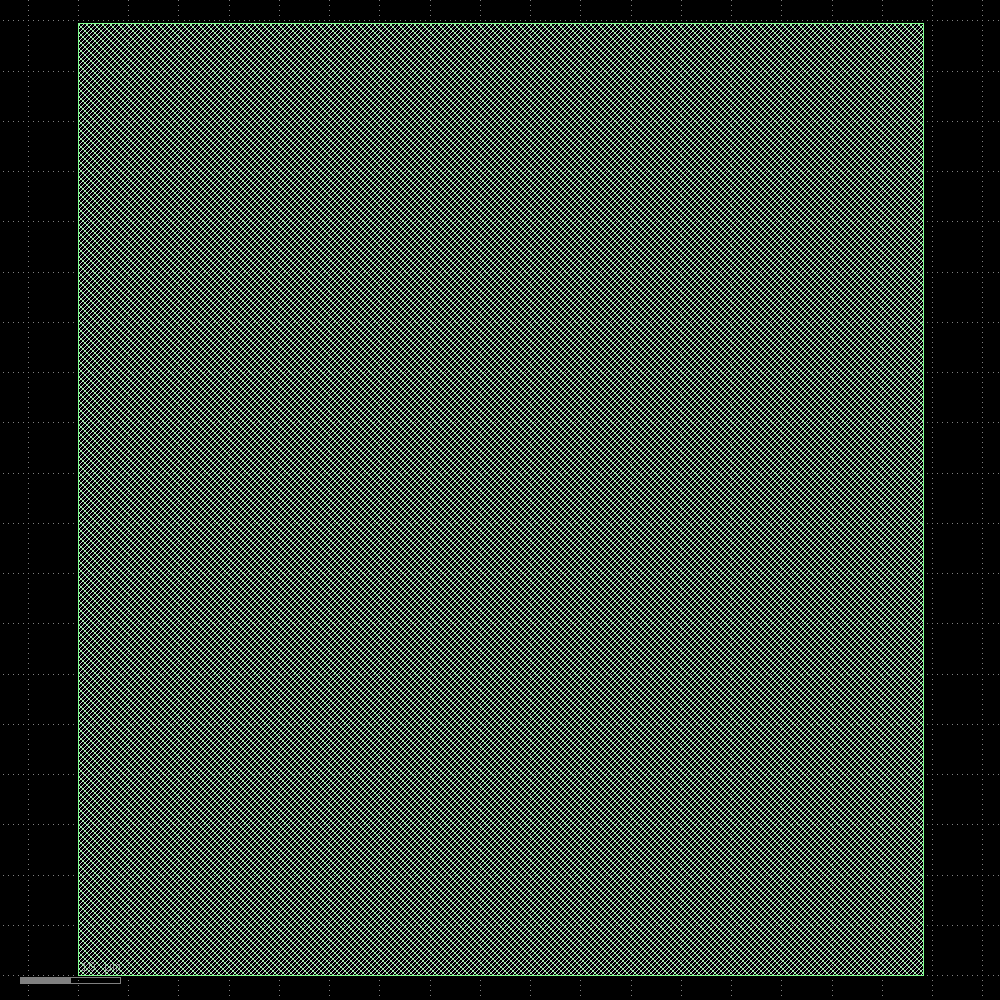

In [284]:
display(floorplan)

### Tap/Endcap Cell Insertion

This places two kinds of cells on the floorplan:

* End cap/boundary cells: Added at the beginning and end of each row. True to
  their name, they "cap off" the core area of a design.
* Tap cells: Placed in a polka dot-ish fashion across the rows. Tap cells
  connect VDD to the nwell and the psubstrate to VSS, which the majority of cells
  do not do themselves to save area- but if you go long enough without one such
  connection you end up with the cell "latching-up"; i.e.; refusing to switch
  back to LO from HI.

  There is a maximum distance between tap cells enforced as part of every
  foundry process.

In [285]:
TapEndcapInsertion = Step.factory.get("OpenROAD.TapEndcapInsertion")

tdi = TapEndcapInsertion(state_in=floorplan.state_out)
tdi.start()

─────────────────────────────────────────────── Tap/Decap Insertion ───────────────────────────────────────────────

[18:48:05] VERBOSE  Running 'OpenROAD.TapEndcapInsertion'…                                             ]8;id=323852;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=982959;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:48:05] VERBOSE  Logging subprocess to                                                              ]8;id=711086;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=879866;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=932809;file:///content/openlane_run/116-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\openlane_run/]8;;\]8;id=331528;file:///content/openlane_run/116-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\116]8;;\]8;id=932809;file:///content/openlane_run/116-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log]8;;\…                  

Reading OpenROAD database at '/content/openlane_run/115-openroad-floorplan/SISO.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[18:48:06] WARNING  [STA-0366] port 'clk' not found.                                                ]8;id=929041;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=555912;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[18:48:06] WARNING  [STA-0366] port 'clk' not found.                                                ]8;id=442516;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=306587;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[18:48:06] WARNING  [STA-0419] transition time can not be specified for virtual clocks.             ]8;id=377786;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=590845;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting timing derate to: 5%

[18:48:06] WARNING  [STA-0450] virtual clock clk can not be propagated.                             ]8;id=512415;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=558530;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO TAP-0004] Inserted 52 endcaps.

[INFO TAP-0005] Inserted 70 tapcells.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/116-openroad-tapendcapinsertion/SISO.odb'…

Writing netlist to '/content/openlane_run/116-openroad-tapendcapinsertion/SISO.nl.v'…

Writing powered netlist to '/content/openlane_run/116-openroad-tapendcapinsertion/SISO.pnl.v'…

Writing layout to '/content/openlane_run/116-openroad-tapendcapinsertion/SISO.def'…

Writing timing constraints to '/content/openlane_run/116-openroad-tapendcapinsertion/SISO.sdc'…

{'nl': Path('/content/openlane_run/116-openroad-tapendcapinsertion/SISO.nl.v'), 'pnl': Path('/content/openlane_run/116-openroad-tapendcapinsertion/SISO.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/116-openroad-tapendcapinsertion/SISO.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/116-openroad-tapendcapinsertion/SISO.odb'), 'sdc': Path('/content/openlane_run/116-openroad-tapendcapinsertion/SISO.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 363, 'design__instance__area': Decimal('2752.64'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 84.045 94.765', 'design__core__bbox': '5.52 10.88 78.2 81.6', 'flow__warnings__count': 4, 'flow__errors__count': 0, 'design__io': 96, 'design__die__area': Decimal('7964.52'), 'design__core__area': Decimal('5139.93'), 'design__instance__count__stdcell': 363, 'design__instance__area__stdcell': Decimal('2752.64'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.53554'), 'design__instance__utilization__stdcell': Decimal('0.53554')}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[18:48:07] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=763800;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=155134;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:48:07] VERBOSE  Logging subprocess to ]8;id=462372;file:///tmp/openlane_klayout_tmp_0kz_04hr/klayout-render.log\..]8;;\]8;id=526914;file:///tmp/openlane_klayout_tmp_0kz_04hr/klayout-render.log\/tmp/openlane_klayout_tmp_0kz_04hr/]8;;\]8;id=19;file:///tmp/openlane_klayout_tmp_0kz_04hr/klayout-render.log\klayout-render.log]8;;\…     ]8;id=557859;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=369862;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 1.43s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
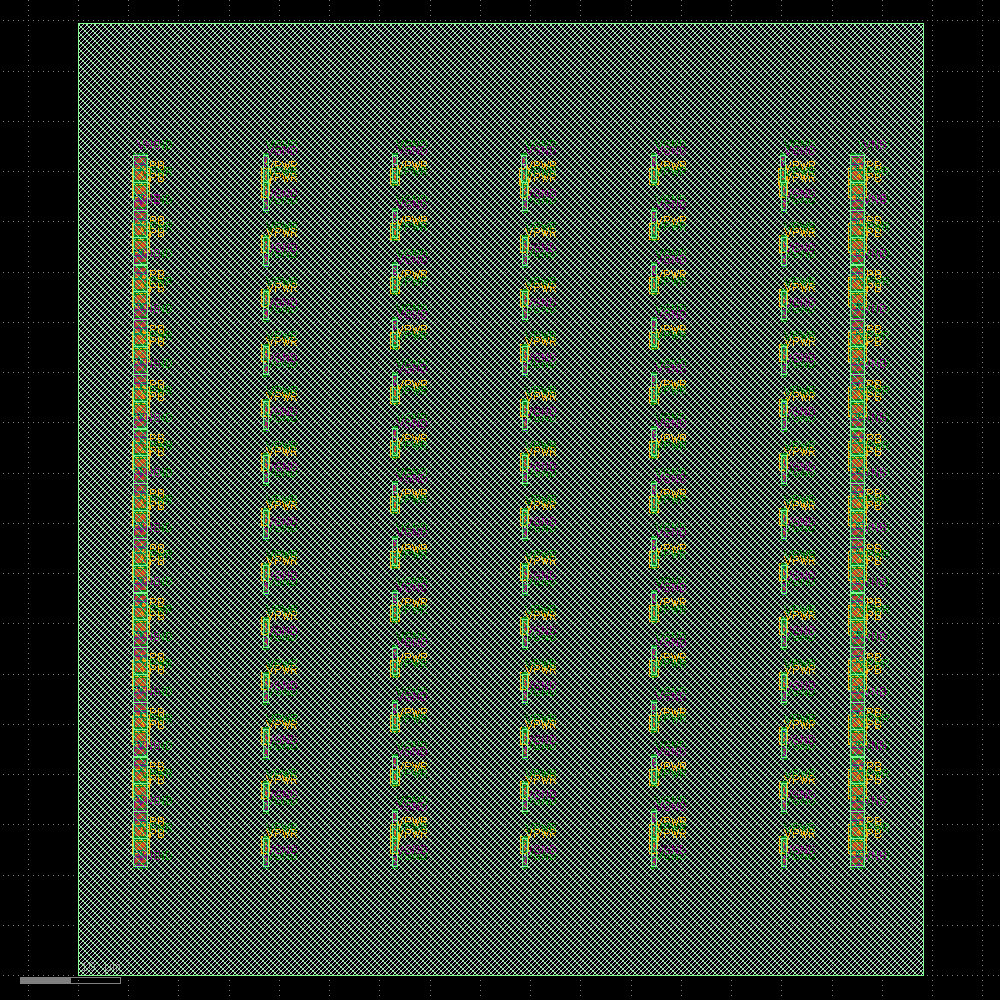

In [286]:
display(tdi)

### I/O Placement

This places metal pins at the edges of the design corresponding to the top level
inputs and outputs for your design. These pins act as the interface with other
designs when you integrate it with other designs.

In [287]:
IOPlacement = Step.factory.get("OpenROAD.IOPlacement")

ioplace = IOPlacement(state_in=tdi.state_out)
ioplace.start()

────────────────────────────────────────────────── I/O Placement ──────────────────────────────────────────────────

[18:48:08] VERBOSE  Running 'OpenROAD.IOPlacement'…                                                    ]8;id=285428;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=363880;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:48:08] VERBOSE  Logging subprocess to                                                              ]8;id=505277;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=339639;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=580609;file:///content/openlane_run/117-openroad-ioplacement/openroad-ioplacement.log\openlane_run/]8;;\]8;id=692922;file:///content/openlane_run/117-openroad-ioplacement/openroad-ioplacement.log\117]8;;\]8;id=580609;file:///content/openlane_run/117-openroad-ioplacement/openroad-ioplacement.log\-openroad-ioplacement/openroad-ioplacement.log]8;;\…                                

Reading OpenROAD database at '/content/openlane_run/116-openroad-tapendcapinsertion/SISO.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[18:48:08] WARNING  [STA-0366] port 'clk' not found.                                                ]8;id=462502;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=491221;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[18:48:09] WARNING  [STA-0366] port 'clk' not found.                                                ]8;id=795180;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=41575;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[18:48:09] WARNING  [STA-0419] transition time can not be specified for virtual clocks.             ]8;id=386838;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=933717;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting timing derate to: 5%

[18:48:09] WARNING  [STA-0450] virtual clock clk can not be propagated.                             ]8;id=234874;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=59407;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] place_pins args: -min_distance 3

Found 0 macro blocks.

[INFO PPL-0010] Tentative 0 to set up sections.

[INFO PPL-0001] Number of slots           108

[INFO PPL-0002] Number of I/O             96

[INFO PPL-0003] Number of I/O w/sink      96

[INFO PPL-0004] Number of I/O w/o sink    0

[INFO PPL-0005] Slots per section         200

[INFO PPL-0006] Slots increase factor     0.01

[INFO PPL-0008] Successfully assigned pins to sections.

[INFO PPL-0012] I/O nets HPWL: 6283.33 um.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/117-openroad-ioplacement/SISO.odb'…

Writing netlist to '/content/openlane_run/117-openroad-ioplacement/SISO.nl.v'…

Writing powered netlist to '/content/openlane_run/117-openroad-ioplacement/SISO.pnl.v'…

Writing layout to '/content/openlane_run/117-openroad-ioplacement/SISO.def'…

Writing timing constraints to '/content/openlane_run/117-openroad-ioplacement/SISO.sdc'…

{'nl': Path('/content/openlane_run/117-openroad-ioplacement/SISO.nl.v'), 'pnl': Path('/content/openlane_run/117-openroad-ioplacement/SISO.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/117-openroad-ioplacement/SISO.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/117-openroad-ioplacement/SISO.odb'), 'sdc': Path('/content/openlane_run/117-openroad-ioplacement/SISO.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 363, 'design__instance__area': Decimal('2752.64'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 84.045 94.765', 'design__core__bbox': '5.52 10.88 78.2 81.6', 'flow__warnings__count': 4, 'flow__errors__count': 0, 'design__io': 96, 'design__die__area': Decimal('7964.52'), 'design__core__area': Decimal('5139.93'), 'design__instance__count__stdcell': 363, 'design__instance__area__stdcell': Decimal('2752.64'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.53554'), 'design__instance__utilization__stdcell': Decimal('0.53554'), 'floorplan__design__io': 96, 'design__io__hpwl': 6283326}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[18:48:09] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=593908;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=758616;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:48:09] VERBOSE  Logging subprocess to ]8;id=417074;file:///tmp/openlane_klayout_tmp_z34_qiwm/klayout-render.log\..]8;;\]8;id=181268;file:///tmp/openlane_klayout_tmp_z34_qiwm/klayout-render.log\/tmp/openlane_klayout_tmp_z34_qiwm/]8;;\]8;id=903140;file:///tmp/openlane_klayout_tmp_z34_qiwm/klayout-render.log\klayout-render.log]8;;\…     ]8;id=298725;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=99997;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 1.23s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
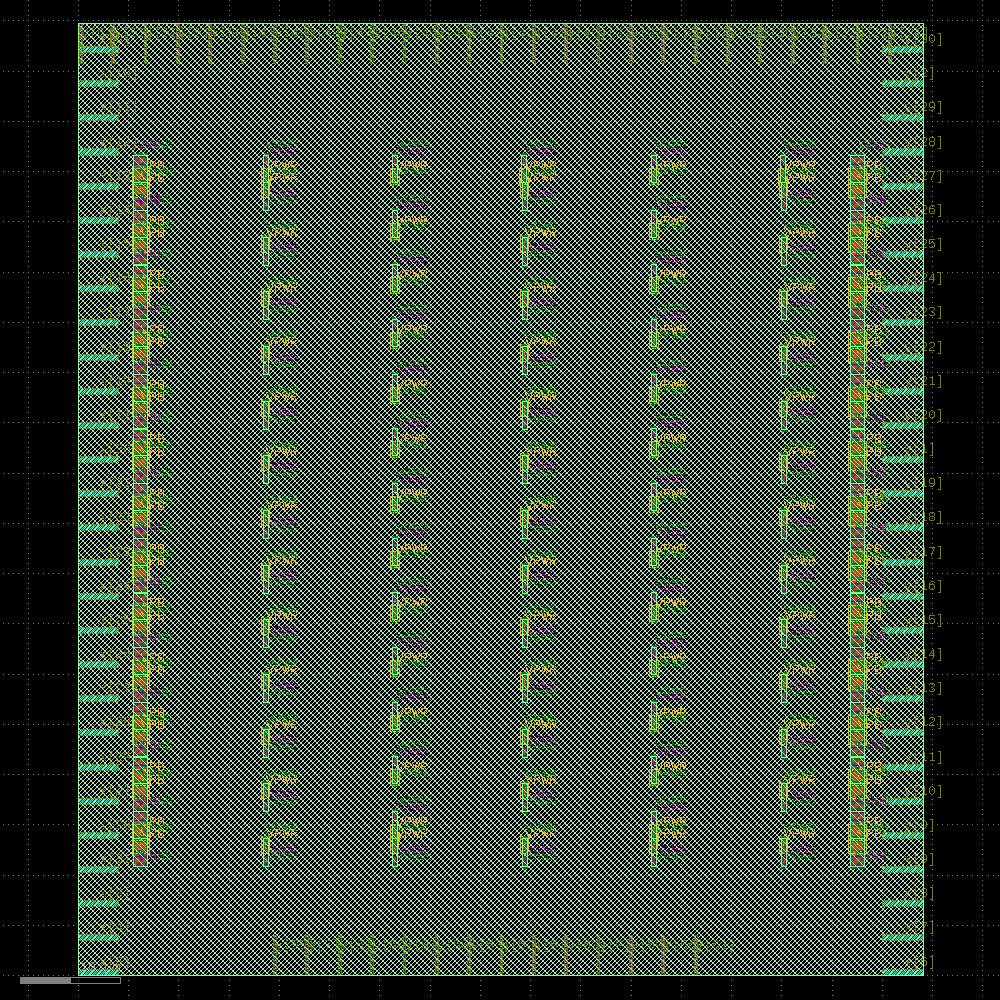

In [288]:
display(ioplace)

### Generating the Power Distribution Network (PDN)

This creates the power distribution network for your design, which is essentially
a plaid pattern of horizontal and vertical "straps" across the design that is
then connected to the rails' VDD and VSS (via the tap cells.)

You can find an explanation of how the power distribution network works at this
link: https://openlane2.readthedocs.io/en/latest/usage/hardening_macros.html#pdn-generation

While we typically don't need to mess with the PDN too much, the SPM is a small
design, so we're going to need to make the plaid pattern formed by the PDN a bit
smaller.

In [289]:
GeneratePDN = Step.factory.get("OpenROAD.GeneratePDN")

pdn = GeneratePDN(
    state_in=ioplace.state_out,
    FP_PDN_VWIDTH=2,
    FP_PDN_HWIDTH=2,
    FP_PDN_VPITCH=30,
    FP_PDN_HPITCH=30,
)
pdn.start()

────────────────────────────────────── Power Distribution Network Generation ──────────────────────────────────────

[18:48:10] VERBOSE  Running 'OpenROAD.GeneratePDN'…                                                    ]8;id=355184;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=658329;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:48:10] INFO     'FP_PDN_CFG' not explicitly set, setting it to                                 ]8;id=254646;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=346315;file:///content/openlane_ipynb/openlane/steps/openroad.py#1174\1174]8;;\
                    /content/openlane_ipynb/openlane/scripts/openroad/common/pdn_cfg.tcl…                          

[18:48:10] VERBOSE  Logging subprocess to                                                              ]8;id=945691;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=144474;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=338925;file:///content/openlane_run/118-openroad-generatepdn/openroad-generatepdn.log\openlane_run/]8;;\]8;id=115918;file:///content/openlane_run/118-openroad-generatepdn/openroad-generatepdn.log\118]8;;\]8;id=338925;file:///content/openlane_run/118-openroad-generatepdn/openroad-generatepdn.log\-openroad-generatepdn/openroad-generatepdn.log]8;;\…                                

Reading OpenROAD database at '/content/openlane_run/117-openroad-ioplacement/SISO.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[18:48:11] WARNING  [STA-0366] port 'clk' not found.                                                ]8;id=73718;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=317561;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[18:48:11] WARNING  [STA-0366] port 'clk' not found.                                                ]8;id=958256;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=873394;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[18:48:11] WARNING  [STA-0419] transition time can not be specified for virtual clocks.             ]8;id=326778;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=744464;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting timing derate to: 5%

[18:48:11] WARNING  [STA-0450] virtual clock clk can not be propagated.                             ]8;id=450984;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=636579;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting global connections...

[INFO PDN-0001] Inserting grid: stdcell_grid

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/118-openroad-generatepdn/SISO.odb'…

Writing netlist to '/content/openlane_run/118-openroad-generatepdn/SISO.nl.v'…

Writing powered netlist to '/content/openlane_run/118-openroad-generatepdn/SISO.pnl.v'…

Writing layout to '/content/openlane_run/118-openroad-generatepdn/SISO.def'…

Writing timing constraints to '/content/openlane_run/118-openroad-generatepdn/SISO.sdc'…

[INFO PSM-0040] All shapes on net VPWR are connected.

[INFO PSM-0040] All shapes on net VGND are connected.

{'nl': Path('/content/openlane_run/118-openroad-generatepdn/SISO.nl.v'), 'pnl': Path('/content/openlane_run/118-openroad-generatepdn/SISO.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/118-openroad-generatepdn/SISO.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/118-openroad-generatepdn/SISO.odb'), 'sdc': Path('/content/openlane_run/118-openroad-generatepdn/SISO.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 363, 'design__instance__area': Decimal('2752.64'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 84.045 94.765', 'design__core__bbox': '5.52 10.88 78.2 81.6', 'flow__warnings__count': 4, 'flow__errors__count': 0, 'design__io': 98, 'design__die__area': Decimal('7964.52'), 'design__core__area': Decimal('5139.93'), 'design__instance__count__stdcell': 363, 'design__instance__area__stdcell': Decimal('2752.64'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.53554'), 'design__instance__utilization__stdcell': Decimal('0.53554'), 'floorplan__design__io': 96, 'design__io__hpwl': 6283326, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[18:48:11] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=824150;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=480399;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:48:11] VERBOSE  Logging subprocess to ]8;id=791262;file:///tmp/openlane_klayout_tmp_abaiir9w/klayout-render.log\..]8;;\]8;id=411806;file:///tmp/openlane_klayout_tmp_abaiir9w/klayout-render.log\/tmp/openlane_klayout_tmp_abaiir9w/]8;;\]8;id=45560;file:///tmp/openlane_klayout_tmp_abaiir9w/klayout-render.log\klayout-render.log]8;;\…     ]8;id=918568;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=627067;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 1.33s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
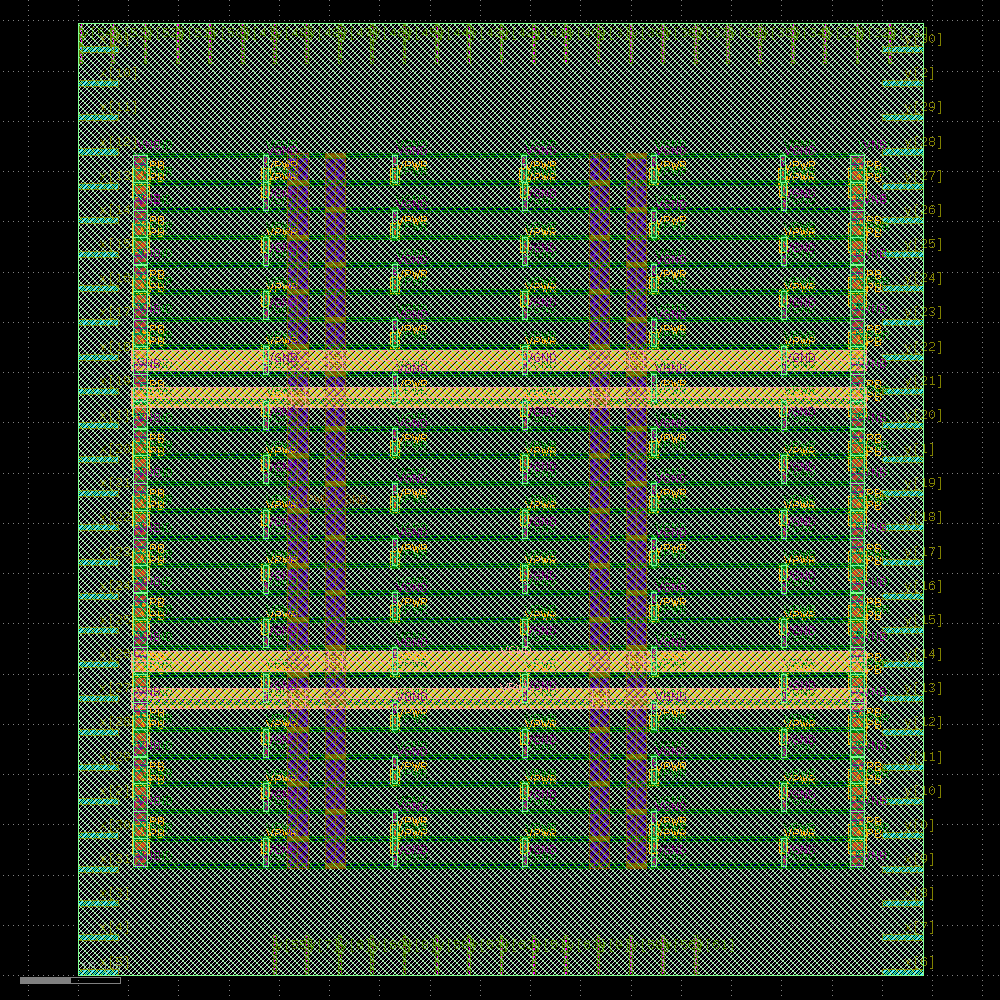

In [290]:
display(pdn)

### Global Placement

Global Placement is deciding on a fuzzy, non-final location for each of the cells,
with the aim of minimizing the distance between cells that are connected
together (more specifically, the total length of the not-yet-created wires that
will connect them).

As you will see in the `.display()` in the second cell below, the placement is
considered "illegal", i.e., not properly aligned with the cell placement grid.
This is addressed by "Detailed Placement", also referred to as "placement
legalization", which is the next step.

In [291]:
GlobalPlacement = Step.factory.get("OpenROAD.GlobalPlacement")

gpl = GlobalPlacement(state_in=pdn.state_out)
gpl.start()

──────────────────────────────────────────────── Global Placement ─────────────────────────────────────────────────

[18:48:12] VERBOSE  Running 'OpenROAD.GlobalPlacement'…                                                ]8;id=413950;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=985428;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:48:12] INFO     'PL_TARGET_DENSITY_PCT' not explicitly set, using dynamically calculated       ]8;id=351433;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=130033;file:///content/openlane_ipynb/openlane/steps/openroad.py#1260\1260]8;;\
                    target density: 63.55400…                                                                      

[18:48:12] VERBOSE  Logging subprocess to                                                              ]8;id=562272;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=757474;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=800781;file:///content/openlane_run/119-openroad-globalplacement/openroad-globalplacement.log\openlane_run/]8;;\]8;id=634174;file:///content/openlane_run/119-openroad-globalplacement/openroad-globalplacement.log\119]8;;\]8;id=800781;file:///content/openlane_run/119-openroad-globalplacement/openroad-globalplacement.log\-openroad-globalplacement/openroad-globalplacement.log]8;;\…                        

Reading OpenROAD database at '/content/openlane_run/118-openroad-generatepdn/SISO.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[18:48:13] WARNING  [STA-0366] port 'clk' not found.                                                ]8;id=184477;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=397965;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[18:48:13] WARNING  [STA-0366] port 'clk' not found.                                                ]8;id=593823;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=484497;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[18:48:13] WARNING  [STA-0419] transition time can not be specified for virtual clocks.             ]8;id=554110;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=332641;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting timing derate to: 5%

[18:48:13] WARNING  [STA-0450] virtual clock clk can not be propagated.                             ]8;id=999185;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=728808;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting RC values…

[INFO] Setting signal min routing layer to: met1 and clock min routing layer to met1.

[INFO] Setting signal max routing layer to: met5 and clock max routing layer to met5.

[INFO GPL-0002] DBU: 1000

[INFO GPL-0003] SiteSize: (  0.460  2.720 ) um

[INFO GPL-0004] CoreBBox: (  5.520 10.880 ) ( 78.200 81.600 ) um

[INFO GPL-0006] NumInstances:               415

[INFO GPL-0007] NumPlaceInstances:          293

[INFO GPL-0008] NumFixedInstances:          122

[INFO GPL-0009] NumDummyInstances:            0

[INFO GPL-0010] NumNets:                    325

[INFO GPL-0011] NumPins:                   1094

[INFO GPL-0012] DieBBox:  (  0.000  0.000 ) ( 84.045 94.765 ) um

[INFO GPL-0013] CoreBBox: (  5.520 10.880 ) ( 78.200 81.600 ) um

[INFO GPL-0016] CoreArea:              5139.930 um^2

[INFO GPL-0017] NonPlaceInstsArea:      282.771 um^2

[INFO GPL-0018] PlaceInstsArea:        2665.056 um^2

[INFO GPL-0019] Util:                    54.869 %

[INFO GPL-0020] StdInstsArea:          2665.056 um^2

[INFO GPL-0021] MacroInstsArea:           0.000 um^2

[InitialPlace]  Iter: 1 CG residual: 0.00000010 HPWL: 10984720

[InitialPlace]  Iter: 2 CG residual: 0.00000010 HPWL: 7240658

[InitialPlace]  Iter: 3 CG residual: 0.00000010 HPWL: 6595639

[InitialPlace]  Iter: 4 CG residual: 0.00000011 HPWL: 6574643

[InitialPlace]  Iter: 5 CG residual: 0.00000009 HPWL: 6560245

[INFO GPL-0031] FillerInit:NumGCells:       340

[INFO GPL-0032] FillerInit:NumGNets:        325

[INFO GPL-0033] FillerInit:NumGPins:       1094

[INFO GPL-0023] TargetDensity:            0.636

[INFO GPL-0024] AvrgPlaceInstArea:        9.096 um^2

[INFO GPL-0025] IdealBinArea:            14.312 um^2

[INFO GPL-0026] IdealBinCnt:                359

[INFO GPL-0027] TotalBinArea:          5139.930 um^2

[INFO GPL-0028] BinCnt:        16     16

[INFO GPL-0029] BinSize: (  4.543  4.420 )

[INFO GPL-0030] NumBins: 256

[NesterovSolve] Iter:    1 overflow: 0.703 HPWL: 5494123

[INFO GPL-0100] worst slack 2.51e-09

[INFO GPL-0103] Weighted 29 nets.

[INFO GPL-0100] worst slack 2.48e-09

[INFO GPL-0103] Weighted 29 nets.

[NesterovSolve] Snapshot saved at iter = 3

[NesterovSolve] Iter:   10 overflow: 0.526 HPWL: 5927586

[NesterovSolve] Iter:   20 overflow: 0.524 HPWL: 5898256

[NesterovSolve] Iter:   30 overflow: 0.522 HPWL: 5892824

[NesterovSolve] Iter:   40 overflow: 0.523 HPWL: 5893540

[NesterovSolve] Iter:   50 overflow: 0.524 HPWL: 5894015

[NesterovSolve] Iter:   60 overflow: 0.523 HPWL: 5894909

[NesterovSolve] Iter:   70 overflow: 0.523 HPWL: 5895107

[NesterovSolve] Iter:   80 overflow: 0.523 HPWL: 5894031

[NesterovSolve] Iter:   90 overflow: 0.523 HPWL: 5893681

[NesterovSolve] Iter:  100 overflow: 0.523 HPWL: 5894881

[NesterovSolve] Iter:  110 overflow: 0.522 HPWL: 5895901

[NesterovSolve] Iter:  120 overflow: 0.522 HPWL: 5895926

[NesterovSolve] Iter:  130 overflow: 0.521 HPWL: 5896003

[NesterovSolve] Iter:  140 overflow: 0.519 HPWL: 5897195

[NesterovSolve] Iter:  150 overflow: 0.517 HPWL: 5899558

[NesterovSolve] Iter:  160 overflow: 0.513 HPWL: 5901736

[NesterovSolve] Iter:  170 overflow: 0.509 HPWL: 5904488

[NesterovSolve] Iter:  180 overflow: 0.503 HPWL: 5910052

[NesterovSolve] Iter:  190 overflow: 0.491 HPWL: 5913349

[INFO GPL-0100] worst slack 2.47e-09

[INFO GPL-0103] Weighted 29 nets.

[NesterovSolve] Iter:  200 overflow: 0.467 HPWL: 5902360

[NesterovSolve] Iter:  210 overflow: 0.438 HPWL: 5847206

[NesterovSolve] Iter:  220 overflow: 0.403 HPWL: 5770373

[NesterovSolve] Iter:  230 overflow: 0.370 HPWL: 5723600

[NesterovSolve] Iter:  240 overflow: 0.344 HPWL: 5721253

[NesterovSolve] Iter:  250 overflow: 0.316 HPWL: 5711731

[NesterovSolve] Iter:  260 overflow: 0.289 HPWL: 5716790

[INFO GPL-0100] worst slack 2.38e-09

[INFO GPL-0103] Weighted 29 nets.

[NesterovSolve] Iter:  270 overflow: 0.264 HPWL: 5742151

[NesterovSolve] Iter:  280 overflow: 0.242 HPWL: 5759494

[NesterovSolve] Iter:  290 overflow: 0.220 HPWL: 5778022

[INFO GPL-0100] worst slack 2.3e-09

[INFO GPL-0103] Weighted 29 nets.

[NesterovSolve] Iter:  300 overflow: 0.201 HPWL: 5802950

[INFO GPL-0075] Routability numCall: 1 inflationIterCnt: 1 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:      12   13

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 156

[INFO GPL-0063] TotalRouteOverflowH2: 0

[INFO GPL-0064] TotalRouteOverflowV2: 0

[INFO GPL-0065] OverflowTileCnt2: 0

[INFO GPL-0066] 0.5%RC: 1.0000

[INFO GPL-0067] 1.0%RC: 1.0000

[INFO GPL-0068] 2.0%RC: 1.0000

[INFO GPL-0069] 5.0%RC: 0.9591

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0000

[INFO GPL-0078] FinalRC lower than minRC (1e+30), min RC updated.

[INFO GPL-0045] InflatedAreaDelta:        0.000 um^2

[INFO GPL-0046] TargetDensity:            0.636

[INFO GPL-0049] WhiteSpaceArea:        4857.158 um^2

[INFO GPL-0050] NesterovInstsArea:     2665.056 um^2

[INFO GPL-0051] TotalFillerArea:        421.863 um^2

[INFO GPL-0052] TotalGCellsArea:       3086.919 um^2

[INFO GPL-0053] ExpectedGCellsArea:    3086.919 um^2

[INFO GPL-0054] NewTargetDensity:         0.636

[INFO GPL-0055] NewWhiteSpaceArea:     4857.158 um^2

[INFO GPL-0056] MovableArea:           3086.919 um^2

[INFO GPL-0057] NewNesterovInstArea:   2665.056 um^2

[INFO GPL-0058] NewTotalFillerArea:     421.863 um^2

[INFO GPL-0059] NewTotalGCellsArea:    3086.919 um^2

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter:  310 overflow: 0.523 HPWL: 5872113

[NesterovSolve] Iter:  320 overflow: 0.515 HPWL: 5847346

[NesterovSolve] Iter:  330 overflow: 0.518 HPWL: 5839385

[NesterovSolve] Iter:  340 overflow: 0.519 HPWL: 5845360

[NesterovSolve] Iter:  350 overflow: 0.517 HPWL: 5844672

[NesterovSolve] Iter:  360 overflow: 0.517 HPWL: 5841758

[NesterovSolve] Iter:  370 overflow: 0.518 HPWL: 5841458

[NesterovSolve] Iter:  380 overflow: 0.518 HPWL: 5842074

[NesterovSolve] Iter:  390 overflow: 0.517 HPWL: 5841996

[NesterovSolve] Iter:  400 overflow: 0.517 HPWL: 5841511

[NesterovSolve] Iter:  410 overflow: 0.517 HPWL: 5841986

[NesterovSolve] Iter:  420 overflow: 0.517 HPWL: 5842356

[NesterovSolve] Iter:  430 overflow: 0.516 HPWL: 5841580

[NesterovSolve] Iter:  440 overflow: 0.516 HPWL: 5841206

[NesterovSolve] Iter:  450 overflow: 0.516 HPWL: 5841962

[NesterovSolve] Iter:  460 overflow: 0.514 HPWL: 5842613

[NesterovSolve] Iter:  470 overflow: 0.513 HPWL: 5843282

[NesterovSolve] Iter:  480 overflow: 0.511 HPWL: 5843867

[NesterovSolve] Iter:  490 overflow: 0.509 HPWL: 5844726

[NesterovSolve] Iter:  500 overflow: 0.505 HPWL: 5842983

[NesterovSolve] Iter:  510 overflow: 0.497 HPWL: 5835551

[NesterovSolve] Iter:  520 overflow: 0.488 HPWL: 5826159

[NesterovSolve] Iter:  530 overflow: 0.479 HPWL: 5815501

[NesterovSolve] Iter:  540 overflow: 0.467 HPWL: 5801815

[NesterovSolve] Iter:  550 overflow: 0.449 HPWL: 5785749

[NesterovSolve] Iter:  560 overflow: 0.423 HPWL: 5735741

[NesterovSolve] Iter:  570 overflow: 0.396 HPWL: 5682331

[NesterovSolve] Iter:  580 overflow: 0.378 HPWL: 5669610

[NesterovSolve] Iter:  590 overflow: 0.355 HPWL: 5662115

[NesterovSolve] Iter:  600 overflow: 0.328 HPWL: 5649687

[NesterovSolve] Iter:  610 overflow: 0.302 HPWL: 5657538

[NesterovSolve] Iter:  620 overflow: 0.278 HPWL: 5679598

[NesterovSolve] Iter:  630 overflow: 0.258 HPWL: 5706224

[NesterovSolve] Iter:  640 overflow: 0.233 HPWL: 5720087

[NesterovSolve] Iter:  650 overflow: 0.215 HPWL: 5754183

[INFO GPL-0075] Routability numCall: 2 inflationIterCnt: 2 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:      12   13

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 156

[INFO GPL-0063] TotalRouteOverflowH2: 0

[INFO GPL-0064] TotalRouteOverflowV2: 0

[INFO GPL-0065] OverflowTileCnt2: 0

[INFO GPL-0066] 0.5%RC: 1.0000

[INFO GPL-0067] 1.0%RC: 1.0000

[INFO GPL-0068] 2.0%RC: 0.9889

[INFO GPL-0069] 5.0%RC: 0.9386

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0000

[INFO GPL-0079] MinRC (1) violation occurred, total count: 1.

[INFO GPL-0045] InflatedAreaDelta:        0.000 um^2

[INFO GPL-0046] TargetDensity:            0.636

[INFO GPL-0049] WhiteSpaceArea:        4857.158 um^2

[INFO GPL-0050] NesterovInstsArea:     2665.056 um^2

[INFO GPL-0051] TotalFillerArea:        421.863 um^2

[INFO GPL-0052] TotalGCellsArea:       3086.919 um^2

[INFO GPL-0053] ExpectedGCellsArea:    3086.919 um^2

[INFO GPL-0054] NewTargetDensity:         0.636

[INFO GPL-0055] NewWhiteSpaceArea:     4857.158 um^2

[INFO GPL-0056] MovableArea:           3086.919 um^2

[INFO GPL-0057] NewNesterovInstArea:   2665.056 um^2

[INFO GPL-0058] NewTotalFillerArea:     421.863 um^2

[INFO GPL-0059] NewTotalGCellsArea:    3086.919 um^2

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter:  660 overflow: 0.535 HPWL: 5973975

[NesterovSolve] Iter:  670 overflow: 0.520 HPWL: 5853490

[NesterovSolve] Iter:  680 overflow: 0.516 HPWL: 5838952

[NesterovSolve] Iter:  690 overflow: 0.520 HPWL: 5838857

[NesterovSolve] Iter:  700 overflow: 0.518 HPWL: 5843701

[NesterovSolve] Iter:  710 overflow: 0.517 HPWL: 5842741

[NesterovSolve] Iter:  720 overflow: 0.518 HPWL: 5840770

[NesterovSolve] Iter:  730 overflow: 0.518 HPWL: 5840981

[NesterovSolve] Iter:  740 overflow: 0.517 HPWL: 5841943

[NesterovSolve] Iter:  750 overflow: 0.517 HPWL: 5841280

[NesterovSolve] Iter:  760 overflow: 0.517 HPWL: 5841217

[NesterovSolve] Iter:  770 overflow: 0.517 HPWL: 5841740

[NesterovSolve] Iter:  780 overflow: 0.517 HPWL: 5841573

[NesterovSolve] Iter:  790 overflow: 0.516 HPWL: 5840480

[NesterovSolve] Iter:  800 overflow: 0.516 HPWL: 5840297

[NesterovSolve] Iter:  810 overflow: 0.515 HPWL: 5840933

[NesterovSolve] Iter:  820 overflow: 0.514 HPWL: 5840916

[NesterovSolve] Iter:  830 overflow: 0.513 HPWL: 5840673

[NesterovSolve] Iter:  840 overflow: 0.511 HPWL: 5840888

[NesterovSolve] Iter:  850 overflow: 0.508 HPWL: 5841242

[NesterovSolve] Iter:  860 overflow: 0.503 HPWL: 5838654

[NesterovSolve] Iter:  870 overflow: 0.494 HPWL: 5829441

[NesterovSolve] Iter:  880 overflow: 0.486 HPWL: 5819330

[NesterovSolve] Iter:  890 overflow: 0.475 HPWL: 5807768

[NesterovSolve] Iter:  900 overflow: 0.464 HPWL: 5796692

[NesterovSolve] Iter:  910 overflow: 0.443 HPWL: 5768619

[NesterovSolve] Iter:  920 overflow: 0.414 HPWL: 5717789

[NesterovSolve] Iter:  930 overflow: 0.390 HPWL: 5672429

[NesterovSolve] Iter:  940 overflow: 0.371 HPWL: 5667287

[NesterovSolve] Iter:  950 overflow: 0.347 HPWL: 5656782

[NesterovSolve] Iter:  960 overflow: 0.321 HPWL: 5653017

[NesterovSolve] Iter:  970 overflow: 0.294 HPWL: 5660951

[NesterovSolve] Iter:  980 overflow: 0.273 HPWL: 5682496

[NesterovSolve] Iter:  990 overflow: 0.252 HPWL: 5710917

[NesterovSolve] Iter: 1000 overflow: 0.227 HPWL: 5724906

[NesterovSolve] Iter: 1010 overflow: 0.209 HPWL: 5763050

[INFO GPL-0075] Routability numCall: 3 inflationIterCnt: 3 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:      12   13

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 156

[INFO GPL-0063] TotalRouteOverflowH2: 0

[INFO GPL-0064] TotalRouteOverflowV2: 0

[INFO GPL-0065] OverflowTileCnt2: 0

[INFO GPL-0066] 0.5%RC: 1.0000

[INFO GPL-0067] 1.0%RC: 1.0000

[INFO GPL-0068] 2.0%RC: 0.9889

[INFO GPL-0069] 5.0%RC: 0.9386

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0000

[INFO GPL-0079] MinRC (1) violation occurred, total count: 2.

[INFO GPL-0045] InflatedAreaDelta:        0.000 um^2

[INFO GPL-0046] TargetDensity:            0.636

[INFO GPL-0049] WhiteSpaceArea:        4857.158 um^2

[INFO GPL-0050] NesterovInstsArea:     2665.056 um^2

[INFO GPL-0051] TotalFillerArea:        421.863 um^2

[INFO GPL-0052] TotalGCellsArea:       3086.919 um^2

[INFO GPL-0053] ExpectedGCellsArea:    3086.919 um^2

[INFO GPL-0054] NewTargetDensity:         0.636

[INFO GPL-0055] NewWhiteSpaceArea:     4857.158 um^2

[INFO GPL-0056] MovableArea:           3086.919 um^2

[INFO GPL-0057] NewNesterovInstArea:   2665.056 um^2

[INFO GPL-0058] NewTotalFillerArea:     421.863 um^2

[INFO GPL-0059] NewTotalGCellsArea:    3086.919 um^2

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter: 1020 overflow: 0.521 HPWL: 5925600

[NesterovSolve] Iter: 1030 overflow: 0.517 HPWL: 5854950

[NesterovSolve] Iter: 1040 overflow: 0.517 HPWL: 5839530

[NesterovSolve] Iter: 1050 overflow: 0.520 HPWL: 5843892

[NesterovSolve] Iter: 1060 overflow: 0.518 HPWL: 5845493

[NesterovSolve] Iter: 1070 overflow: 0.517 HPWL: 5842872

[NesterovSolve] Iter: 1080 overflow: 0.518 HPWL: 5841330

[NesterovSolve] Iter: 1090 overflow: 0.518 HPWL: 5841766

[NesterovSolve] Iter: 1100 overflow: 0.517 HPWL: 5842235

[NesterovSolve] Iter: 1110 overflow: 0.517 HPWL: 5841584

[NesterovSolve] Iter: 1120 overflow: 0.517 HPWL: 5841699

[NesterovSolve] Iter: 1130 overflow: 0.517 HPWL: 5842332

[NesterovSolve] Iter: 1140 overflow: 0.516 HPWL: 5841975

[NesterovSolve] Iter: 1150 overflow: 0.516 HPWL: 5841170

[NesterovSolve] Iter: 1160 overflow: 0.516 HPWL: 5841595

[NesterovSolve] Iter: 1170 overflow: 0.515 HPWL: 5842439

[NesterovSolve] Iter: 1180 overflow: 0.514 HPWL: 5842978

[NesterovSolve] Iter: 1190 overflow: 0.512 HPWL: 5843372

[NesterovSolve] Iter: 1200 overflow: 0.510 HPWL: 5844514

[NesterovSolve] Iter: 1210 overflow: 0.507 HPWL: 5844212

[NesterovSolve] Iter: 1220 overflow: 0.500 HPWL: 5839553

[NesterovSolve] Iter: 1230 overflow: 0.492 HPWL: 5829843

[NesterovSolve] Iter: 1240 overflow: 0.483 HPWL: 5819255

[NesterovSolve] Iter: 1250 overflow: 0.472 HPWL: 5805943

[NesterovSolve] Iter: 1260 overflow: 0.459 HPWL: 5796319

[NesterovSolve] Iter: 1270 overflow: 0.434 HPWL: 5758446

[NesterovSolve] Iter: 1280 overflow: 0.405 HPWL: 5701832

[NesterovSolve] Iter: 1290 overflow: 0.385 HPWL: 5667659

[NesterovSolve] Iter: 1300 overflow: 0.365 HPWL: 5664282

[NesterovSolve] Iter: 1310 overflow: 0.338 HPWL: 5654438

[NesterovSolve] Iter: 1320 overflow: 0.312 HPWL: 5655942

[NesterovSolve] Iter: 1330 overflow: 0.288 HPWL: 5669394

[NesterovSolve] Iter: 1340 overflow: 0.267 HPWL: 5692861

[NesterovSolve] Iter: 1350 overflow: 0.242 HPWL: 5716796

[NesterovSolve] Iter: 1360 overflow: 0.221 HPWL: 5739099

[NesterovSolve] Iter: 1370 overflow: 0.203 HPWL: 5773801

[INFO GPL-0075] Routability numCall: 4 inflationIterCnt: 4 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:      12   13

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 156

[INFO GPL-0063] TotalRouteOverflowH2: 0

[INFO GPL-0064] TotalRouteOverflowV2: 0

[INFO GPL-0065] OverflowTileCnt2: 0

[INFO GPL-0066] 0.5%RC: 1.0000

[INFO GPL-0067] 1.0%RC: 1.0000

[INFO GPL-0068] 2.0%RC: 0.9889

[INFO GPL-0069] 5.0%RC: 0.9364

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0000

[INFO GPL-0079] MinRC (1) violation occurred, total count: 3.

[INFO GPL-0045] InflatedAreaDelta:        0.000 um^2

[INFO GPL-0046] TargetDensity:            0.636

Revert Routability Procedure. Target density higher than max, or minRC max violations.

[INFO GPL-0080] minRcViolatedCnt: 3

[INFO GPL-0047] SavedMinRC: 1.0000

[INFO GPL-0048] SavedTargetDensity: 0.6355

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter: 1380 overflow: 0.521 HPWL: 5873273

[NesterovSolve] Iter: 1390 overflow: 0.515 HPWL: 5844760

[NesterovSolve] Iter: 1400 overflow: 0.518 HPWL: 5836387

[NesterovSolve] Iter: 1410 overflow: 0.519 HPWL: 5843121

[NesterovSolve] Iter: 1420 overflow: 0.517 HPWL: 5843366

[NesterovSolve] Iter: 1430 overflow: 0.517 HPWL: 5841554

[NesterovSolve] Iter: 1440 overflow: 0.518 HPWL: 5840667

[NesterovSolve] Iter: 1450 overflow: 0.518 HPWL: 5841802

[NesterovSolve] Iter: 1460 overflow: 0.517 HPWL: 5841620

[NesterovSolve] Iter: 1470 overflow: 0.517 HPWL: 5841148

[NesterovSolve] Iter: 1480 overflow: 0.517 HPWL: 5841469

[NesterovSolve] Iter: 1490 overflow: 0.517 HPWL: 5841774

[NesterovSolve] Iter: 1500 overflow: 0.516 HPWL: 5840955

[NesterovSolve] Iter: 1510 overflow: 0.516 HPWL: 5840204

[NesterovSolve] Iter: 1520 overflow: 0.516 HPWL: 5840662

[NesterovSolve] Iter: 1530 overflow: 0.514 HPWL: 5840981

[NesterovSolve] Iter: 1540 overflow: 0.513 HPWL: 5840821

[NesterovSolve] Iter: 1550 overflow: 0.512 HPWL: 5840679

[NesterovSolve] Iter: 1560 overflow: 0.509 HPWL: 5841205

[NesterovSolve] Iter: 1570 overflow: 0.505 HPWL: 5840322

[NesterovSolve] Iter: 1580 overflow: 0.498 HPWL: 5833822

[NesterovSolve] Iter: 1590 overflow: 0.489 HPWL: 5823627

[NesterovSolve] Iter: 1600 overflow: 0.480 HPWL: 5812783

[NesterovSolve] Iter: 1610 overflow: 0.468 HPWL: 5799940

[NesterovSolve] Iter: 1620 overflow: 0.452 HPWL: 5786200

[NesterovSolve] Iter: 1630 overflow: 0.425 HPWL: 5739269

[NesterovSolve] Iter: 1640 overflow: 0.399 HPWL: 5683577

[NesterovSolve] Iter: 1650 overflow: 0.381 HPWL: 5667059

[NesterovSolve] Iter: 1660 overflow: 0.358 HPWL: 5661713

[NesterovSolve] Iter: 1670 overflow: 0.331 HPWL: 5649790

[NesterovSolve] Iter: 1680 overflow: 0.304 HPWL: 5655514

[NesterovSolve] Iter: 1690 overflow: 0.281 HPWL: 5676007

[NesterovSolve] Iter: 1700 overflow: 0.261 HPWL: 5700535

[NesterovSolve] Iter: 1710 overflow: 0.236 HPWL: 5715523

[NesterovSolve] Iter: 1720 overflow: 0.216 HPWL: 5748367

[NesterovSolve] Iter: 1730 overflow: 0.196 HPWL: 5779845

[NesterovSolve] Iter: 1740 overflow: 0.174 HPWL: 5798781

[NesterovSolve] Iter: 1750 overflow: 0.155 HPWL: 5827150

[INFO GPL-0100] worst slack 2.34e-09

[INFO GPL-0103] Weighted 29 nets.

[NesterovSolve] Iter: 1760 overflow: 0.136 HPWL: 5852645

[NesterovSolve] Iter: 1770 overflow: 0.122 HPWL: 5918162

[NesterovSolve] Iter: 1780 overflow: 0.106 HPWL: 5933938

[NesterovSolve] Finished with Overflow: 0.098937

[INFO] Setting RC values…

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/119-openroad-globalplacement/SISO.odb'…

Writing netlist to '/content/openlane_run/119-openroad-globalplacement/SISO.nl.v'…

Writing powered netlist to '/content/openlane_run/119-openroad-globalplacement/SISO.pnl.v'…

Writing layout to '/content/openlane_run/119-openroad-globalplacement/SISO.def'…

Writing timing constraints to '/content/openlane_run/119-openroad-globalplacement/SISO.sdc'…

{'nl': Path('/content/openlane_run/119-openroad-globalplacement/SISO.nl.v'), 'pnl': Path('/content/openlane_run/119-openroad-globalplacement/SISO.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/119-openroad-globalplacement/SISO.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/119-openroad-globalplacement/SISO.odb'), 'sdc': Path('/content/openlane_run/119-openroad-globalplacement/SISO.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 363, 'design__instance__area': Decimal('2752.64'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 84.045 94.765', 'design__core__bbox': '5.52 10.88 78.2 81.6', 'flow__warnings__count': 4, 'flow__errors__count': 0, 'design__io': 98, 'design__die__area': Decimal('7964.52'), 'design__core__area': Decimal('5139.93'), 'design__instance__count__stdcell': 363, 'design__instance__area__stdcell': Decimal('2752.64'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.53554'), 'design__instance__utilization__stdcell': Decimal('0.53554'), 'floorplan__design__io': 96, 'design__io__hpwl': 6283326, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[18:48:16] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=448778;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=685977;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:48:16] VERBOSE  Logging subprocess to ]8;id=589157;file:///tmp/openlane_klayout_tmp__sh9z5gu/klayout-render.log\..]8;;\]8;id=487881;file:///tmp/openlane_klayout_tmp__sh9z5gu/klayout-render.log\/tmp/openlane_klayout_tmp__sh9z5gu/]8;;\]8;id=960879;file:///tmp/openlane_klayout_tmp__sh9z5gu/klayout-render.log\klayout-render.log]8;;\…     ]8;id=506019;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=302343;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 3.88s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
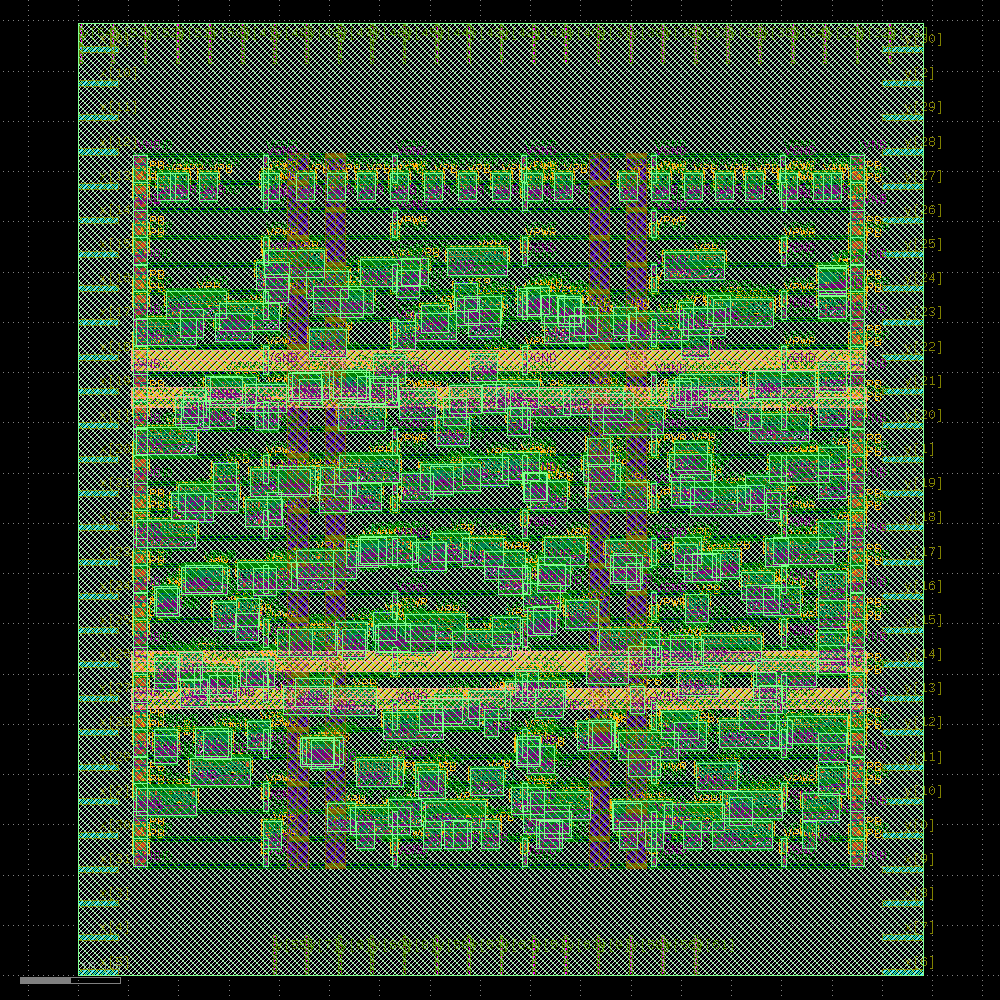

In [292]:
display(gpl)

### Detailed Placement

This aligns the fuzzy placement from before with the grid, "legalizing" it.

In [293]:
DetailedPlacement = Step.factory.get("OpenROAD.DetailedPlacement")

dpl = DetailedPlacement(state_in=gpl.state_out)
dpl.start()

─────────────────────────────────────────────── Detailed Placement ────────────────────────────────────────────────

[18:48:17] VERBOSE  Running 'OpenROAD.DetailedPlacement'…                                              ]8;id=545907;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=930194;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:48:17] VERBOSE  Logging subprocess to                                                              ]8;id=709242;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=93520;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=918814;file:///content/openlane_run/120-openroad-detailedplacement/openroad-detailedplacement.log\openlane_run/]8;;\]8;id=340393;file:///content/openlane_run/120-openroad-detailedplacement/openroad-detailedplacement.log\120]8;;\]8;id=918814;file:///content/openlane_run/120-openroad-detailedplacement/openroad-detailedplacement.log\-openroad-detailedplacement/openroad-detailedplacement.log]8;;\…                    

Reading OpenROAD database at '/content/openlane_run/119-openroad-globalplacement/SISO.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[18:48:18] WARNING  [STA-0366] port 'clk' not found.                                                ]8;id=291854;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=532094;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[18:48:18] WARNING  [STA-0366] port 'clk' not found.                                                ]8;id=102328;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=841438;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[18:48:18] WARNING  [STA-0419] transition time can not be specified for virtual clocks.             ]8;id=366282;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=900259;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting timing derate to: 5%

[18:48:18] WARNING  [STA-0450] virtual clock clk can not be propagated.                             ]8;id=679442;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=315297;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

Placement Analysis

---------------------------------

total displacement        625.7 u

average displacement        1.5 u

max displacement            7.6 u

original HPWL            5934.9 u

legalized HPWL           6534.3 u

delta HPWL                   10 %

[INFO DPL-0020] Mirrored 84 instances

[INFO DPL-0021] HPWL before            6534.3 u

[INFO DPL-0022] HPWL after             6411.8 u

[INFO DPL-0023] HPWL delta               -1.9 %

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/120-openroad-detailedplacement/SISO.odb'…

Writing netlist to '/content/openlane_run/120-openroad-detailedplacement/SISO.nl.v'…

Writing powered netlist to '/content/openlane_run/120-openroad-detailedplacement/SISO.pnl.v'…

Writing layout to '/content/openlane_run/120-openroad-detailedplacement/SISO.def'…

Writing timing constraints to '/content/openlane_run/120-openroad-detailedplacement/SISO.sdc'…

{'nl': Path('/content/openlane_run/120-openroad-detailedplacement/SISO.nl.v'), 'pnl': Path('/content/openlane_run/120-openroad-detailedplacement/SISO.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/120-openroad-detailedplacement/SISO.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/120-openroad-detailedplacement/SISO.odb'), 'sdc': Path('/content/openlane_run/120-openroad-detailedplacement/SISO.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 363, 'design__instance__area': Decimal('2752.64'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 84.045 94.765', 'design__core__bbox': '5.52 10.88 78.2 81.6', 'flow__warnings__count': 4, 'flow__errors__count': 0, 'design__io': 98, 'design__die__area': Decimal('7964.52'), 'design__core__area': Decimal('5139.93'), 'design__instance__count__stdcell': 363, 'design__instance__area__stdcell': Decimal('2752.64'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.53554'), 'design__instance__utilization__stdcell': Decimal('0.53554'), 'floorplan__design__io': 96, 'design__io__hpwl': 6283326, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('625.677'), 'design__instance__displacement__mean': Decimal('1.507'), 'design__instance__displacement__max': Decimal('7.556'), 'route__wirelength__estimated': Decimal('6534.34'), 'design__violations': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[18:48:19] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=495010;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=425931;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:48:19] VERBOSE  Logging subprocess to ]8;id=352127;file:///tmp/openlane_klayout_tmp_yqycf20i/klayout-render.log\..]8;;\]8;id=67956;file:///tmp/openlane_klayout_tmp_yqycf20i/klayout-render.log\/tmp/openlane_klayout_tmp_yqycf20i/]8;;\]8;id=999553;file:///tmp/openlane_klayout_tmp_yqycf20i/klayout-render.log\klayout-render.log]8;;\…     ]8;id=11073;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=71411;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 1.33s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
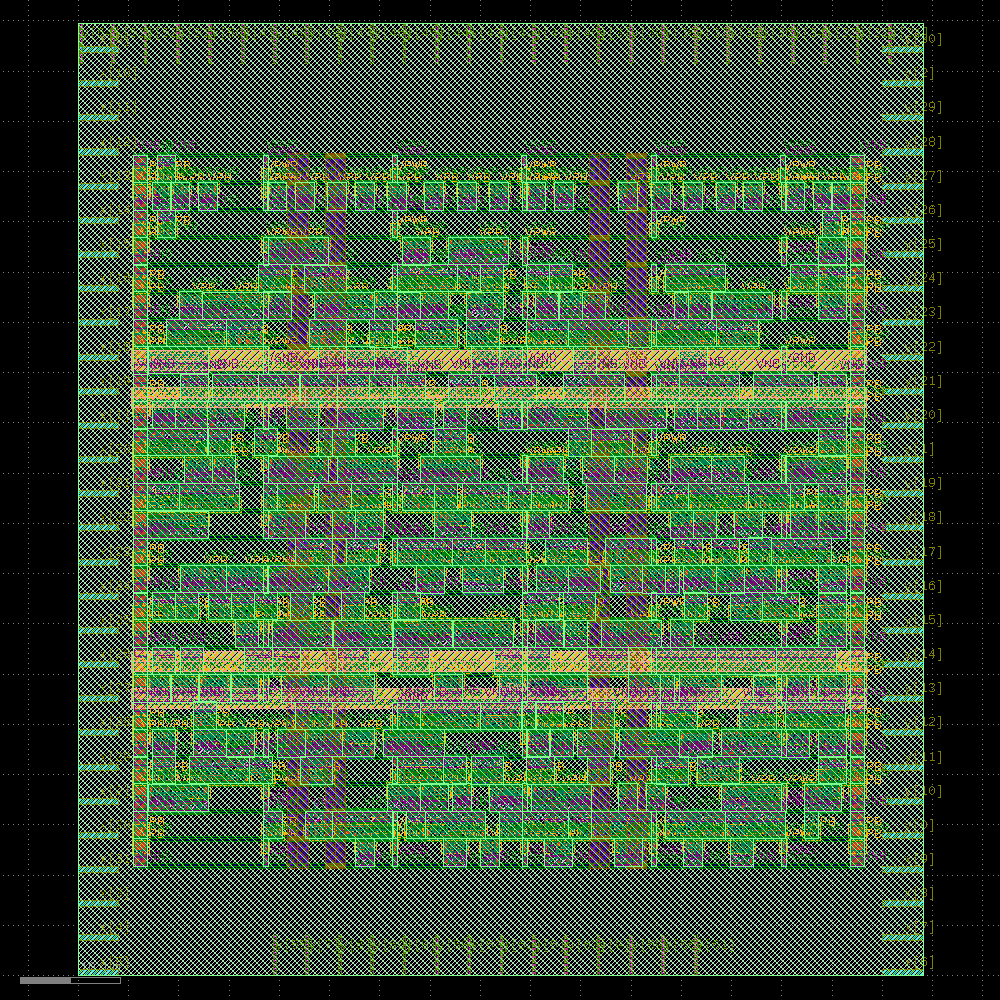

In [294]:
display(dpl)

### Clock Tree Synthesis (CTS)

With the cells now having a final placement, we can go ahead and create what
is known as the clock tree, i.e., the hierarchical set of buffers used
for clock signal to minimize what is known as "clock skew"- variable delay
of the clock cycle from register to register because of factors such as metal
wire length, clock load (number of gates connected to the same clock buffer,)
et cetera.

The CTS step creates the cells and places the between the gaps in the detailed
placement above.

In [295]:
CTS = Step.factory.get("OpenROAD.CTS")

cts = CTS(state_in=dpl.state_out)
cts.start()

────────────────────────────────────────────── Clock Tree Synthesis ───────────────────────────────────────────────

[18:48:20] VERBOSE  Running 'OpenROAD.CTS'…                                                            ]8;id=660525;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=382358;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:48:20] VERBOSE  Logging subprocess to ]8;id=859912;file:///content/openlane_run/121-openroad-cts/openroad-cts.log\openlane_run/]8;;\]8;id=121081;file:///content/openlane_run/121-openroad-cts/openroad-cts.log\121]8;;\]8;id=859912;file:///content/openlane_run/121-openroad-cts/openroad-cts.log\-openroad-cts/openroad-cts.log]8;;\…              ]8;id=549234;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=656425;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Reading timing models for corner nom_tt_025C_1v80…

Reading timing library for the 'nom_tt_025C_1v80' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading timing models for corner nom_ff_n40C_1v95…

Reading timing library for the 'nom_ff_n40C_1v95' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ff_n40C_1v95.lib'…

Reading timing models for corner nom_ss_100C_1v60…

Reading timing library for the 'nom_ss_100C_1v60' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ss_100C_1v60.lib'…

Reading OpenROAD database at '/content/openlane_run/120-openroad-detailedplacement/SISO.odb'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[18:48:23] WARNING  [STA-0366] port 'clk' not found.                                                ]8;id=897762;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=739351;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[18:48:23] WARNING  [STA-0366] port 'clk' not found.                                                ]8;id=151476;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=252746;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[18:48:23] WARNING  [STA-0419] transition time can not be specified for virtual clocks.             ]8;id=454038;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=336588;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting timing derate to: 5%

[18:48:23] WARNING  [STA-0450] virtual clock clk can not be propagated.                             ]8;id=937797;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=840970;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting RC values…

[INFO] Configuring cts characterization…

[INFO] Performing clock tree synthesis…

[INFO] Looking for the following net(s): clk

[INFO] Running Clock Tree Synthesis…

[INFO CTS-0050] Root buffer is sky130_fd_sc_hd__clkbuf_16.

[INFO CTS-0051] Sink buffer is sky130_fd_sc_hd__clkbuf_8.

[INFO CTS-0052] The following clock buffers will be used for CTS:

sky130_fd_sc_hd__clkbuf_2

sky130_fd_sc_hd__clkbuf_4

sky130_fd_sc_hd__clkbuf_8

[INFO CTS-0049] Characterization buffer is sky130_fd_sc_hd__clkbuf_8.

[18:48:32] WARNING  [CTS-0083] No clock nets have been found.                                       ]8;id=540288;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=259127;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO CTS-0008] TritonCTS found 0 clock nets.

[18:48:32] WARNING  [CTS-0082] No valid clock nets in the design.                                   ]8;id=469695;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=334901;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[18:48:32] WARNING  [STA-0450] virtual clock clk can not be propagated.                             ]8;id=906029;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=120745;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Repairing long wires on clock nets…

[INFO RSZ-0058] Using max wire length 6335um.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/121-openroad-cts/SISO.odb'…

Writing netlist to '/content/openlane_run/121-openroad-cts/SISO.nl.v'…

Writing powered netlist to '/content/openlane_run/121-openroad-cts/SISO.pnl.v'…

Writing layout to '/content/openlane_run/121-openroad-cts/SISO.def'…

Writing timing constraints to '/content/openlane_run/121-openroad-cts/SISO.sdc'…

[INFO] Legalizing…

Placement Analysis

---------------------------------

total displacement          0.0 u

average displacement        0.0 u

max displacement            0.0 u

original HPWL            6411.8 u

legalized HPWL           6534.3 u

delta HPWL                    2 %

[INFO DPL-0020] Mirrored 84 instances

[INFO DPL-0021] HPWL before            6534.3 u

[INFO DPL-0022] HPWL after             6411.8 u

[INFO DPL-0023] HPWL delta               -1.9 %

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/121-openroad-cts/SISO.odb'…

Writing netlist to '/content/openlane_run/121-openroad-cts/SISO.nl.v'…

Writing powered netlist to '/content/openlane_run/121-openroad-cts/SISO.pnl.v'…

Writing layout to '/content/openlane_run/121-openroad-cts/SISO.def'…

Writing timing constraints to '/content/openlane_run/121-openroad-cts/SISO.sdc'…

{'nl': Path('/content/openlane_run/121-openroad-cts/SISO.nl.v'), 'pnl': Path('/content/openlane_run/121-openroad-cts/SISO.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/121-openroad-cts/SISO.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/121-openroad-cts/SISO.odb'), 'sdc': Path('/content/openlane_run/121-openroad-cts/SISO.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 363, 'design__instance__area': Decimal('2752.64'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 84.045 94.765', 'design__core__bbox': '5.52 10.88 78.2 81.6', 'flow__warnings__count': 33703, 'flow__errors__count': 0, 'design__io': 98, 'design__die__area': Decimal('7964.52'), 'design__core__area': Decimal('5139.93'), 'design__instance__count__stdcell': 363, 'design__instance__area__stdcell': Decimal('2752.64'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.53554'), 'design__instance__utilization__stdcell': Decimal('0.53554'), 'floorplan__design__io': 96, 'design__io__hpwl': 6283326, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': 0, 'design__instance__displacement__mean': 0, 'design__instance__displacement__max': 0, 'route__wirelength__estimated': Decimal('6534.34'), 'design__violations': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[18:48:33] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=591422;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=257679;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:48:33] VERBOSE  Logging subprocess to ]8;id=345518;file:///tmp/openlane_klayout_tmp_fayuyf3g/klayout-render.log\..]8;;\]8;id=962953;file:///tmp/openlane_klayout_tmp_fayuyf3g/klayout-render.log\/tmp/openlane_klayout_tmp_fayuyf3g/]8;;\]8;id=173328;file:///tmp/openlane_klayout_tmp_fayuyf3g/klayout-render.log\klayout-render.log]8;;\…     ]8;id=624830;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=854668;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 13.03s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
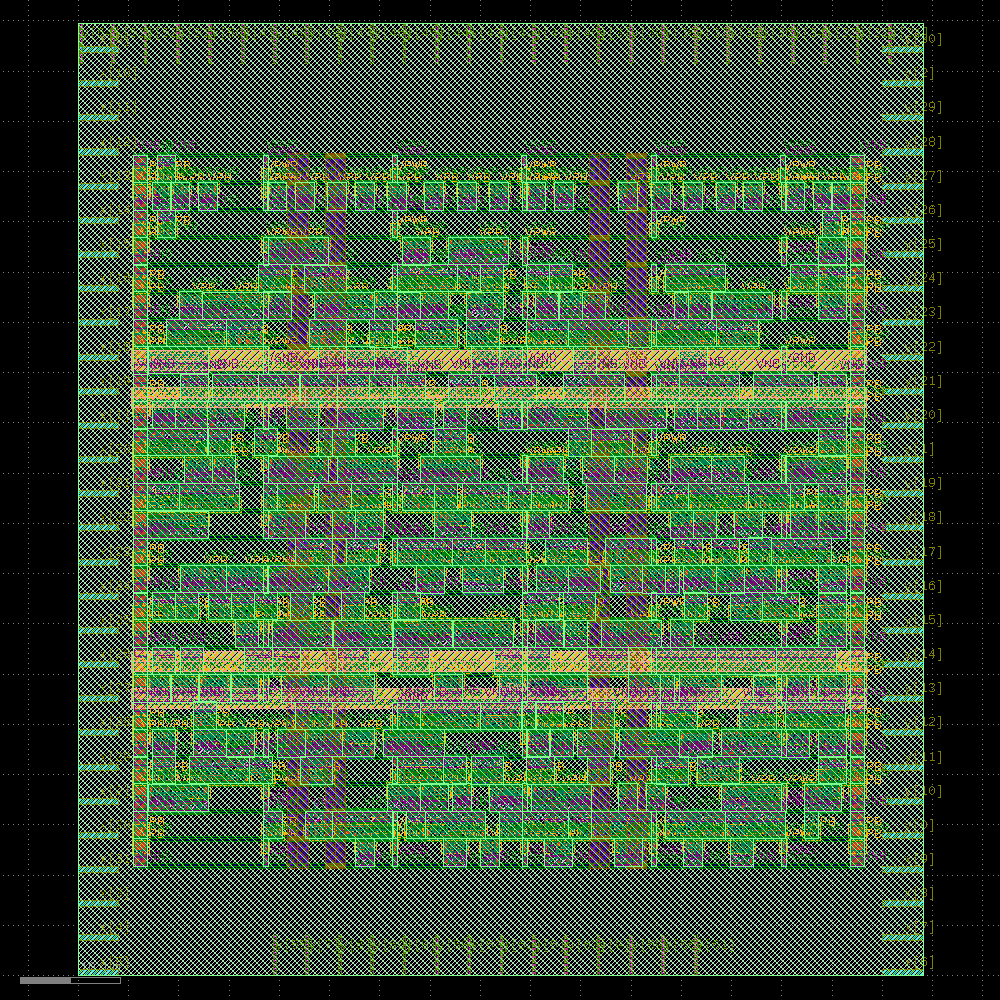

In [296]:
display(cts)

### Global Routing

Global routing "plans" the routes the wires between two gates (or gates and
I/O pins/the PDN) will take. The results of global routing (which are called
"routing guides") are stored in internal data structures and have no effect on
the actual design, so there is no `display()` statement.

In [297]:
GlobalRouting = Step.factory.get("OpenROAD.GlobalRouting")

grt = GlobalRouting(state_in=cts.state_out)
grt.start()

───────────────────────────────────────────────── Global Routing ──────────────────────────────────────────────────

[18:48:34] VERBOSE  Running 'OpenROAD.GlobalRouting'…                                                  ]8;id=397017;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=650359;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:48:34] VERBOSE  Logging subprocess to                                                              ]8;id=542447;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=705010;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=750537;file:///content/openlane_run/122-openroad-globalrouting/openroad-globalrouting.log\openlane_run/]8;;\]8;id=983924;file:///content/openlane_run/122-openroad-globalrouting/openroad-globalrouting.log\122]8;;\]8;id=750537;file:///content/openlane_run/122-openroad-globalrouting/openroad-globalrouting.log\-openroad-globalrouting/openroad-globalrouting.log]8;;\…                            

Reading OpenROAD database at '/content/openlane_run/121-openroad-cts/SISO.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[18:48:35] WARNING  [STA-0366] port 'clk' not found.                                                ]8;id=446969;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=650035;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[18:48:35] WARNING  [STA-0366] port 'clk' not found.                                                ]8;id=227398;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=696670;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[18:48:35] WARNING  [STA-0419] transition time can not be specified for virtual clocks.             ]8;id=250618;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=147281;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting timing derate to: 5%

[18:48:35] WARNING  [STA-0450] virtual clock clk can not be propagated.                             ]8;id=827251;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=171563;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[18:48:35] WARNING  [STA-0450] virtual clock clk can not be propagated.                             ]8;id=661264;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=698275;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting signal min routing layer to: met1 and clock min routing layer to met1.

[INFO] Setting signal max routing layer to: met5 and clock max routing layer to met5.

-congestion_iterations 50 -verbose

[INFO GRT-0020] Min routing layer: met1

[INFO GRT-0021] Max routing layer: met5

[INFO GRT-0022] Global adjustment: 30%

[INFO GRT-0023] Grid origin: (0, 0)

[INFO GRT-0043] No OR_DEFAULT vias defined.

[INFO GRT-0088] Layer li1     Track-Pitch = 0.4600  line-2-Via Pitch: 0.3400

[INFO GRT-0088] Layer met1    Track-Pitch = 0.3400  line-2-Via Pitch: 0.3400

[INFO GRT-0088] Layer met2    Track-Pitch = 0.4600  line-2-Via Pitch: 0.3500

[INFO GRT-0088] Layer met3    Track-Pitch = 0.6800  line-2-Via Pitch: 0.6150

[INFO GRT-0088] Layer met4    Track-Pitch = 0.9200  line-2-Via Pitch: 1.0400

[INFO GRT-0088] Layer met5    Track-Pitch = 3.4000  line-2-Via Pitch: 3.1100

[INFO GRT-0019] Found 0 clock nets.

[INFO GRT-0001] Minimum degree: 2

[INFO GRT-0002] Maximum degree: 34

[INFO GRT-0003] Macros: 0

[INFO GRT-0043] No OR_DEFAULT vias defined.

[INFO GRT-0004] Blockages: 255

[INFO GRT-0053] Routing resources analysis:

Routing      Original      Derated      Resource

Layer     Direction    Resources     Resources    Reduction (%)

---------------------------------------------------------------

li1        Vertical            0             0          0.00%

met1       Horizontal       3280          1619          50.64%

met2       Vertical         2381          1430          39.94%

met3       Horizontal       1634           965          40.94%

met4       Vertical          968           498          48.55%

met5       Horizontal        322           132          59.01%

---------------------------------------------------------------

[INFO GRT-0197] Via related to pin nodes: 1652

[INFO GRT-0198] Via related Steiner nodes: 15

[INFO GRT-0199] Via filling finished.

[INFO GRT-0111] Final number of vias: 2033

[INFO GRT-0112] Final usage 3D: 7006

[INFO GRT-0096] Final congestion report:

Layer         Resource        Demand        Usage (%)    Max H / Max V / Total Overflow

---------------------------------------------------------------------------------------

li1                  0             0            0.00%             0 /  0 /  0

met1              1619           385           23.78%             0 /  0 /  0

met2              1430           422           29.51%             0 /  0 /  0

met3               965            88            9.12%             0 /  0 /  0

met4               498            12            2.41%             0 /  0 /  0

met5               132             0            0.00%             0 /  0 /  0

---------------------------------------------------------------------------------------

Total             4644           907           19.53%             0 /  0 /  0

[INFO GRT-0018] Total wirelength: 11681 um

[INFO GRT-0014] Routed nets: 325

[INFO] Setting RC values…

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/122-openroad-globalrouting/SISO.odb'…

Writing layout to '/content/openlane_run/122-openroad-globalrouting/SISO.def'…

{'nl': Path('/content/openlane_run/121-openroad-cts/SISO.nl.v'), 'pnl': Path('/content/openlane_run/121-openroad-cts/SISO.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/122-openroad-globalrouting/SISO.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/122-openroad-globalrouting/SISO.odb'), 'sdc': Path('/content/openlane_run/121-openroad-cts/SISO.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 363, 'design__instance__area': Decimal('2752.64'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 84.045 94.765', 'design__core__bbox': '5.52 10.88 78.2 81.6', 'flow__warnings__count': 5, 'flow__errors__count': 0, 'design__io': 98, 'design__die__area': Decimal('7964.52'), 'design__core__area': Decimal('5139.93'), 'design__instance__count__stdcell': 363, 'design__instance__area__stdcell': Decimal('2752.64'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.53554'), 'design__instance__utilization__stdcell': Decimal('0.53554'), 'floorplan__design__io': 96, 'design__io__hpwl': 6283326, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': 0, 'design__instance__displacement__mean': 0, 'design__instance__displacement__max': 0, 'route__wirelength__estimated': Decimal('6534.34'), 'design__violations': 0, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0}}

### Detailed Routing

Detailed routing uses the guides from Global Routing to actually create wires
on the metal layers and connect the gates, making the connections finally physical.

This is typically the longest step in the flow.

In [298]:
DetailedRouting = Step.factory.get("OpenROAD.DetailedRouting")

drt = DetailedRouting(state_in=grt.state_out)
drt.start()

──────────────────────────────────────────────── Detailed Routing ─────────────────────────────────────────────────

[18:48:36] VERBOSE  Running 'OpenROAD.DetailedRouting'…                                                ]8;id=792945;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=785278;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:48:36] INFO     Running TritonRoute with 2 threads…                                            ]8;id=890641;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=883624;file:///content/openlane_ipynb/openlane/steps/openroad.py#1619\1619]8;;\

[18:48:36] VERBOSE  Logging subprocess to                                                              ]8;id=185555;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=948025;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=116431;file:///content/openlane_run/123-openroad-detailedrouting/openroad-detailedrouting.log\openlane_run/]8;;\]8;id=833574;file:///content/openlane_run/123-openroad-detailedrouting/openroad-detailedrouting.log\123]8;;\]8;id=116431;file:///content/openlane_run/123-openroad-detailedrouting/openroad-detailedrouting.log\-openroad-detailedrouting/openroad-detailedrouting.log]8;;\…                        

Reading OpenROAD database at '/content/openlane_run/122-openroad-globalrouting/SISO.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[18:48:36] WARNING  [STA-0366] port 'clk' not found.                                                ]8;id=939386;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=909966;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[18:48:36] WARNING  [STA-0366] port 'clk' not found.                                                ]8;id=962243;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=408744;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[18:48:36] WARNING  [STA-0419] transition time can not be specified for virtual clocks.             ]8;id=64818;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=898444;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting timing derate to: 5%

[18:48:36] WARNING  [STA-0450] virtual clock clk can not be propagated.                             ]8;id=708704;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=174840;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO ORD-0030] Using 2 thread(s).

[INFO DRT-0149] Reading tech and libs.

[18:48:36] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=87731;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=775554;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer mcon                                                                                     

[18:48:36] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=153985;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=938721;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer mcon                                                                                     

[18:48:36] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=627169;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=146258;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via                                                                                      

[18:48:36] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=806637;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=780947;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via                                                                                      

[18:48:36] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=903364;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=187355;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via2                                                                                     

[18:48:36] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=414667;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=268444;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via2                                                                                     

[18:48:36] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=869522;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=912403;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via3                                                                                     

[18:48:36] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=930449;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=564217;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via3                                                                                     

[18:48:36] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=103426;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=461062;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via4                                                                                     

[18:48:36] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=48495;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=78927;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via4                                                                                     

Units:                1000

Number of layers:     13

Number of macros:     441

Number of vias:       29

Number of viarulegen: 25

[INFO DRT-0150] Reading design.

Design:                   SISO

Die area:                 ( 0 0 ) ( 84045 94765 )

Number of track patterns: 12

Number of DEF vias:       0

Number of components:     415

Number of terminals:      98

Number of snets:          2

Number of nets:           325

[INFO DRT-0167] List of default vias:

Layer via

default via: M1M2_PR

Layer via2

default via: M2M3_PR

Layer via3

default via: M3M4_PR

Layer via4

default via: M4M5_PR

[INFO DRT-0162] Library cell analysis.

[INFO DRT-0163] Instance analysis.

[INFO DRT-0164] Number of unique instances = 110.

[INFO DRT-0168] Init region query.

[INFO DRT-0024]   Complete FR_MASTERSLICE.

[INFO DRT-0024]   Complete Fr_VIA.

[INFO DRT-0024]   Complete li1.

[INFO DRT-0024]   Complete mcon.

[INFO DRT-0024]   Complete met1.

[INFO DRT-0024]   Complete via.

[INFO DRT-0024]   Complete met2.

[INFO DRT-0024]   Complete via2.

[INFO DRT-0024]   Complete met3.

[INFO DRT-0024]   Complete via3.

[INFO DRT-0024]   Complete met4.

[INFO DRT-0024]   Complete via4.

[INFO DRT-0024]   Complete met5.

[INFO DRT-0033] FR_MASTERSLICE shape region query size = 0.

[INFO DRT-0033] FR_VIA shape region query size = 0.

[INFO DRT-0033] li1 shape region query size = 8401.

[INFO DRT-0033] mcon shape region query size = 0.

[INFO DRT-0033] met1 shape region query size = 1164.

[INFO DRT-0033] via shape region query size = 324.

[INFO DRT-0033] met2 shape region query size = 148.

[INFO DRT-0033] via2 shape region query size = 270.

[INFO DRT-0033] met3 shape region query size = 218.

[INFO DRT-0033] via3 shape region query size = 270.

[INFO DRT-0033] met4 shape region query size = 70.

[INFO DRT-0033] via4 shape region query size = 8.

[INFO DRT-0033] met5 shape region query size = 16.

[INFO DRT-0165] Start pin access.

[INFO DRT-0078]   Complete 407 pins.

[INFO DRT-0079]   Complete 100 unique inst patterns.

[INFO DRT-0081]   Complete 104 unique inst patterns.

[INFO DRT-0084]   Complete 200 groups.

#scanned instances     = 415

#unique  instances     = 110

#stdCellGenAp          = 2810

#stdCellValidPlanarAp  = 28

#stdCellValidViaAp     = 2224

#stdCellPinNoAp        = 0

#stdCellPinCnt         = 998

#instTermValidViaApCnt = 0

#macroGenAp            = 0

#macroValidPlanarAp    = 0

#macroValidViaAp       = 0

#macroNoAp             = 0

[INFO DRT-0166] Complete pin access.

[INFO DRT-0267] cpu time = 00:00:17, elapsed time = 00:00:09, memory = 115.72 (MB), peak = 254.99 (MB)

Number of guides:     2119

[INFO DRT-0169] Post process guides.

[INFO DRT-0176] GCELLGRID X 0 DO 12 STEP 6900 ;

[INFO DRT-0177] GCELLGRID Y 0 DO 13 STEP 6900 ;

[INFO DRT-0028]   Complete FR_MASTERSLICE.

[INFO DRT-0028]   Complete Fr_VIA.

[INFO DRT-0028]   Complete li1.

[INFO DRT-0028]   Complete mcon.

[INFO DRT-0028]   Complete met1.

[INFO DRT-0028]   Complete via.

[INFO DRT-0028]   Complete met2.

[INFO DRT-0028]   Complete via2.

[INFO DRT-0028]   Complete met3.

[INFO DRT-0028]   Complete via3.

[INFO DRT-0028]   Complete met4.

[INFO DRT-0028]   Complete via4.

[INFO DRT-0028]   Complete met5.

[INFO DRT-0178] Init guide query.

[INFO DRT-0035]   Complete FR_MASTERSLICE (guide).

[INFO DRT-0035]   Complete Fr_VIA (guide).

[INFO DRT-0035]   Complete li1 (guide).

[INFO DRT-0035]   Complete mcon (guide).

[INFO DRT-0035]   Complete met1 (guide).

[INFO DRT-0035]   Complete via (guide).

[INFO DRT-0035]   Complete met2 (guide).

[INFO DRT-0035]   Complete via2 (guide).

[INFO DRT-0035]   Complete met3 (guide).

[INFO DRT-0035]   Complete via3 (guide).

[INFO DRT-0035]   Complete met4 (guide).

[INFO DRT-0035]   Complete via4 (guide).

[INFO DRT-0035]   Complete met5 (guide).

[INFO DRT-0036] FR_MASTERSLICE guide region query size = 0.

[INFO DRT-0036] FR_VIA guide region query size = 0.

[INFO DRT-0036] li1 guide region query size = 726.

[INFO DRT-0036] mcon guide region query size = 0.

[INFO DRT-0036] met1 guide region query size = 554.

[INFO DRT-0036] via guide region query size = 0.

[INFO DRT-0036] met2 guide region query size = 318.

[INFO DRT-0036] via2 guide region query size = 0.

[INFO DRT-0036] met3 guide region query size = 60.

[INFO DRT-0036] via3 guide region query size = 0.

[INFO DRT-0036] met4 guide region query size = 2.

[INFO DRT-0036] via4 guide region query size = 0.

[INFO DRT-0036] met5 guide region query size = 0.

[INFO DRT-0179] Init gr pin query.

[INFO DRT-0245] skipped writing guide updates to database.

[INFO DRT-0185] Post process initialize RPin region query.

[INFO DRT-0181] Start track assignment.

[INFO DRT-0184] Done with 1046 vertical wires in 1 frboxes and 614 horizontal wires in 1 frboxes.

[INFO DRT-0186] Done with 94 vertical wires in 1 frboxes and 133 horizontal wires in 1 frboxes.

[INFO DRT-0182] Complete track assignment.

[INFO DRT-0267] cpu time = 00:00:00, elapsed time = 00:00:00, memory = 118.77 (MB), peak = 254.99 (MB)

[INFO DRT-0187] Start routing data preparation.

[INFO DRT-0267] cpu time = 00:00:00, elapsed time = 00:00:00, memory = 118.77 (MB), peak = 254.99 (MB)

[INFO DRT-0194] Start detail routing.

[INFO DRT-0195] Start 0th optimization iteration.

Completing 10% with 0 violations.

elapsed time = 00:00:01, memory = 126.77 (MB).

Completing 20% with 15 violations.

elapsed time = 00:00:02, memory = 143.52 (MB).

Completing 30% with 30 violations.

elapsed time = 00:00:04, memory = 151.11 (MB).

Completing 40% with 52 violations.

elapsed time = 00:00:04, memory = 151.11 (MB).

[INFO DRT-0199]   Number of violations = 83.

Viol/Layer         li1   met1   met2

Metal Spacing        2     23      1

Recheck              1      8      6

Short                0     28     14

[INFO DRT-0267] cpu time = 00:00:05, elapsed time = 00:00:05, memory = 498.50 (MB), peak = 498.50 (MB)

Total wire length = 6947 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 2752 um.

Total wire length on LAYER met2 = 3178 um.

Total wire length on LAYER met3 = 945 um.

Total wire length on LAYER met4 = 70 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 2024.

Up-via summary (total 2024):

-----------------------

FR_MASTERSLICE       0

li1     979

met1     980

met2      61

met3       4

met4       0

-----------------------

2024

[INFO DRT-0195] Start 1st optimization iteration.

Completing 10% with 83 violations.

elapsed time = 00:00:00, memory = 498.50 (MB).

Completing 20% with 83 violations.

elapsed time = 00:00:00, memory = 498.50 (MB).

Completing 30% with 83 violations.

elapsed time = 00:00:00, memory = 498.50 (MB).

Completing 40% with 76 violations.

elapsed time = 00:00:00, memory = 498.50 (MB).

Completing 50% with 76 violations.

elapsed time = 00:00:01, memory = 498.50 (MB).

Completing 60% with 50 violations.

elapsed time = 00:00:02, memory = 498.50 (MB).

[INFO DRT-0199]   Number of violations = 7.

Viol/Layer        met1   met2

Metal Spacing        4      1

Recheck              2      0

[INFO DRT-0267] cpu time = 00:00:03, elapsed time = 00:00:02, memory = 498.50 (MB), peak = 498.50 (MB)

Total wire length = 6858 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 2719 um.

Total wire length on LAYER met2 = 3127 um.

Total wire length on LAYER met3 = 941 um.

Total wire length on LAYER met4 = 70 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 1990.

Up-via summary (total 1990):

-----------------------

FR_MASTERSLICE       0

li1     978

met1     945

met2      63

met3       4

met4       0

-----------------------

1990

[INFO DRT-0195] Start 2nd optimization iteration.

Completing 10% with 7 violations.

elapsed time = 00:00:00, memory = 498.50 (MB).

Completing 20% with 7 violations.

elapsed time = 00:00:00, memory = 498.50 (MB).

Completing 30% with 7 violations.

elapsed time = 00:00:00, memory = 498.50 (MB).

Completing 40% with 7 violations.

elapsed time = 00:00:00, memory = 498.50 (MB).

Completing 50% with 7 violations.

elapsed time = 00:00:00, memory = 498.50 (MB).

Completing 60% with 7 violations.

elapsed time = 00:00:00, memory = 498.50 (MB).

Completing 70% with 7 violations.

elapsed time = 00:00:00, memory = 498.50 (MB).

Completing 80% with 7 violations.

elapsed time = 00:00:00, memory = 498.50 (MB).

Completing 90% with 2 violations.

elapsed time = 00:00:02, memory = 498.50 (MB).

Completing 100% with 2 violations.

elapsed time = 00:00:02, memory = 498.50 (MB).

[INFO DRT-0199]   Number of violations = 2.

Viol/Layer        met1   met2

Metal Spacing        1      1

[INFO DRT-0267] cpu time = 00:00:02, elapsed time = 00:00:02, memory = 498.50 (MB), peak = 498.50 (MB)

Total wire length = 6841 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 2705 um.

Total wire length on LAYER met2 = 3122 um.

Total wire length on LAYER met3 = 942 um.

Total wire length on LAYER met4 = 70 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 1987.

Up-via summary (total 1987):

-----------------------

FR_MASTERSLICE       0

li1     978

met1     942

met2      63

met3       4

met4       0

-----------------------

1987

[INFO DRT-0195] Start 3rd optimization iteration.

Completing 10% with 2 violations.

elapsed time = 00:00:00, memory = 498.50 (MB).

Completing 20% with 0 violations.

elapsed time = 00:00:00, memory = 498.50 (MB).

Completing 30% with 0 violations.

elapsed time = 00:00:00, memory = 498.50 (MB).

Completing 40% with 0 violations.

elapsed time = 00:00:00, memory = 498.50 (MB).

[INFO DRT-0199]   Number of violations = 0.

[INFO DRT-0267] cpu time = 00:00:00, elapsed time = 00:00:00, memory = 498.50 (MB), peak = 498.50 (MB)

Total wire length = 6835 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 2696 um.

Total wire length on LAYER met2 = 3125 um.

Total wire length on LAYER met3 = 942 um.

Total wire length on LAYER met4 = 70 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 1988.

Up-via summary (total 1988):

-----------------------

FR_MASTERSLICE       0

li1     978

met1     943

met2      63

met3       4

met4       0

-----------------------

1988

[INFO DRT-0198] Complete detail routing.

Total wire length = 6835 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 2696 um.

Total wire length on LAYER met2 = 3125 um.

Total wire length on LAYER met3 = 942 um.

Total wire length on LAYER met4 = 70 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 1988.

Up-via summary (total 1988):

-----------------------

FR_MASTERSLICE       0

li1     978

met1     943

met2      63

met3       4

met4       0

-----------------------

1988

[INFO DRT-0267] cpu time = 00:00:12, elapsed time = 00:00:11, memory = 498.50 (MB), peak = 498.50 (MB)

[INFO DRT-0180] Post processing.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/123-openroad-detailedrouting/SISO.odb'…

Writing netlist to '/content/openlane_run/123-openroad-detailedrouting/SISO.nl.v'…

Writing powered netlist to '/content/openlane_run/123-openroad-detailedrouting/SISO.pnl.v'…

Writing layout to '/content/openlane_run/123-openroad-detailedrouting/SISO.def'…

Writing timing constraints to '/content/openlane_run/123-openroad-detailedrouting/SISO.sdc'…

{'nl': Path('/content/openlane_run/123-openroad-detailedrouting/SISO.nl.v'), 'pnl': Path('/content/openlane_run/123-openroad-detailedrouting/SISO.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/123-openroad-detailedrouting/SISO.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/123-openroad-detailedrouting/SISO.odb'), 'sdc': Path('/content/openlane_run/123-openroad-detailedrouting/SISO.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 363, 'design__instance__area': Decimal('2752.64'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 84.045 94.765', 'design__core__bbox': '5.52 10.88 78.2 81.6', 'flow__warnings__count': 14, 'flow__errors__count': 0, 'design__io': 98, 'design__die__area': Decimal('7964.52'), 'design__core__area': Decimal('5139.93'), 'design__instance__count__stdcell': 363, 'design__instance__area__stdcell': Decimal('2752.64'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.53554'), 'design__instance__utilization__stdcell': Decimal('0.53554'), 'floorplan__design__io': 96, 'design__io__hpwl': 6283326, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': 0, 'design__instance__displacement__mean': 0, 'design__instance__displacement__max': 0, 'route__wirelength__estimated': Decimal('6534.34'), 'design__violations': 0, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0, 'route__net': 325, 'route__net__special': 2, 'route__drc_errors__iter:1': 83, 'route__wirelength__iter:1': 6947, 'route__drc_errors__iter:2': 7, 'route__wirelength__iter:2': 6858, 'route__drc_errors__iter:3': 2, 'route__wirelength__iter:3': 6841, 'route__drc_errors__iter:4': 0, 'route__wirelength__iter:4': 6835, 'route__drc_errors': 0, 'route__wirelength': 6835, 'route__vias': 1988, 'route__vias__singlecut': 1988, 'route__vias__multicut': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[18:48:58] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=782984;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=976156;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:48:58] VERBOSE  Logging subprocess to ]8;id=686434;file:///tmp/openlane_klayout_tmp_r2lx_ntc/klayout-render.log\..]8;;\]8;id=381302;file:///tmp/openlane_klayout_tmp_r2lx_ntc/klayout-render.log\/tmp/openlane_klayout_tmp_r2lx_ntc/]8;;\]8;id=120013;file:///tmp/openlane_klayout_tmp_r2lx_ntc/klayout-render.log\klayout-render.log]8;;\…     ]8;id=195036;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=505812;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 22.87s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
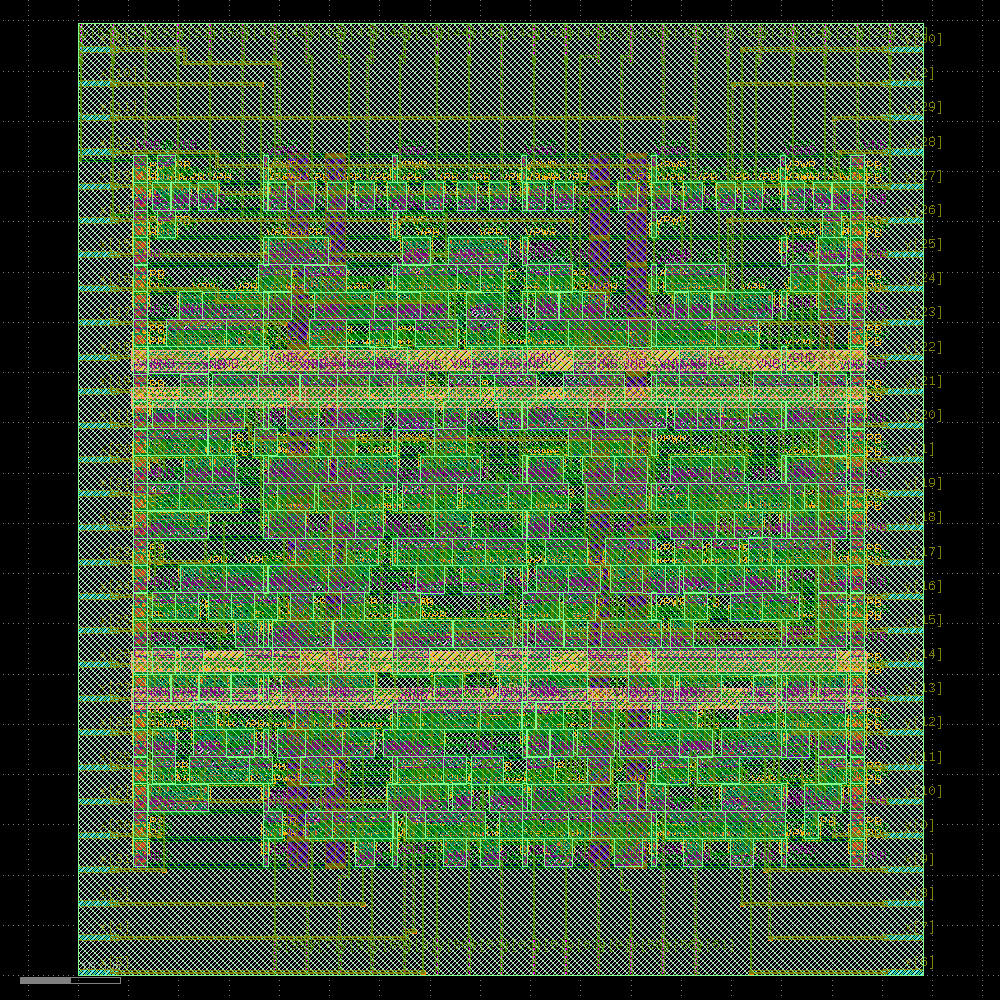

In [299]:
display(drt)

### Fill Insertion

Finally, as we're done placing all the essential cells, the only thing left to
do is fill in the gaps.

We prioritize the use of decap (decoupling capacitor) cells, which
further supports the power distribution network, but when there aren't any
small enough cells, we just use regular fill cells.

In [300]:
FillInsertion = Step.factory.get("OpenROAD.FillInsertion")

fill = FillInsertion(state_in=drt.state_out)
fill.start()

───────────────────────────────────────────────── Fill Insertion ──────────────────────────────────────────────────

[18:49:00] VERBOSE  Running 'OpenROAD.FillInsertion'…                                                  ]8;id=328662;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=671301;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:49:00] VERBOSE  Logging subprocess to                                                              ]8;id=566619;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=183225;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=819364;file:///content/openlane_run/124-openroad-fillinsertion/openroad-fillinsertion.log\openlane_run/]8;;\]8;id=982992;file:///content/openlane_run/124-openroad-fillinsertion/openroad-fillinsertion.log\124]8;;\]8;id=819364;file:///content/openlane_run/124-openroad-fillinsertion/openroad-fillinsertion.log\-openroad-fillinsertion/openroad-fillinsertion.log]8;;\…                            

Reading OpenROAD database at '/content/openlane_run/123-openroad-detailedrouting/SISO.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[18:49:00] WARNING  [STA-0366] port 'clk' not found.                                                ]8;id=446263;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=987936;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[18:49:00] WARNING  [STA-0366] port 'clk' not found.                                                ]8;id=824711;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=839619;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[18:49:00] WARNING  [STA-0419] transition time can not be specified for virtual clocks.             ]8;id=739632;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=217443;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

[INFO] Setting timing derate to: 5%

[18:49:00] WARNING  [STA-0450] virtual clock clk can not be propagated.                             ]8;id=447410;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=544312;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\

sky130_ef_sc_hd__decap_12 sky130_fd_sc_hd__decap_8 sky130_fd_sc_hd__decap_6 sky130_fd_sc_hd__decap_4               
sky130_fd_sc_hd__decap_3 sky130_fd_sc_hd__fill*

[INFO DPL-0001] Placed 362 filler instances.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/124-openroad-fillinsertion/SISO.odb'…

Writing netlist to '/content/openlane_run/124-openroad-fillinsertion/SISO.nl.v'…

Writing powered netlist to '/content/openlane_run/124-openroad-fillinsertion/SISO.pnl.v'…

Writing layout to '/content/openlane_run/124-openroad-fillinsertion/SISO.def'…

Writing timing constraints to '/content/openlane_run/124-openroad-fillinsertion/SISO.sdc'…

{'nl': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.nl.v'), 'pnl': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.odb'), 'sdc': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 363, 'design__instance__area': Decimal('2752.64'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 84.045 94.765', 'design__core__bbox': '5.52 10.88 78.2 81.6', 'flow__warnings__count': 4, 'flow__errors__count': 0, 'design__io': 98, 'design__die__area': Decimal('7964.52'), 'design__core__area': Decimal('5139.93'), 'design__instance__count__stdcell': 363, 'design__instance__area__stdcell': Decimal('2752.64'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.53554'), 'design__instance__utilization__stdcell': Decimal('0.53554'), 'floorplan__design__io': 96, 'design__io__hpwl': 6283326, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': 0, 'design__instance__displacement__mean': 0, 'design__instance__displacement__max': 0, 'route__wirelength__estimated': Decimal('6534.34'), 'design__violations': 0, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0, 'route__net': 325, 'route__net__special': 2, 'route__drc_errors__iter:1': 83, 'route__wirelength__iter:1': 6947, 'route__drc_errors__iter:2': 7, 'route__wirelength__iter:2': 6858, 'route__drc_errors__iter:3': 2, 'route__wirelength__iter:3': 6841, 'route__drc_errors__iter:4': 0, 'route__wirelength__iter:4': 6835, 'route__drc_errors': 0, 'route__wirelength': 6835, 'route__vias': 1988, 'route__vias__singlecut': 1988, 'route__vias__multicut': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[18:49:01] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=482008;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=262436;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:49:01] VERBOSE  Logging subprocess to ]8;id=590804;file:///tmp/openlane_klayout_tmp_kd1_kcfj/klayout-render.log\..]8;;\]8;id=908831;file:///tmp/openlane_klayout_tmp_kd1_kcfj/klayout-render.log\/tmp/openlane_klayout_tmp_kd1_kcfj/]8;;\]8;id=569550;file:///tmp/openlane_klayout_tmp_kd1_kcfj/klayout-render.log\klayout-render.log]8;;\…     ]8;id=905363;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=593781;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 1.14s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
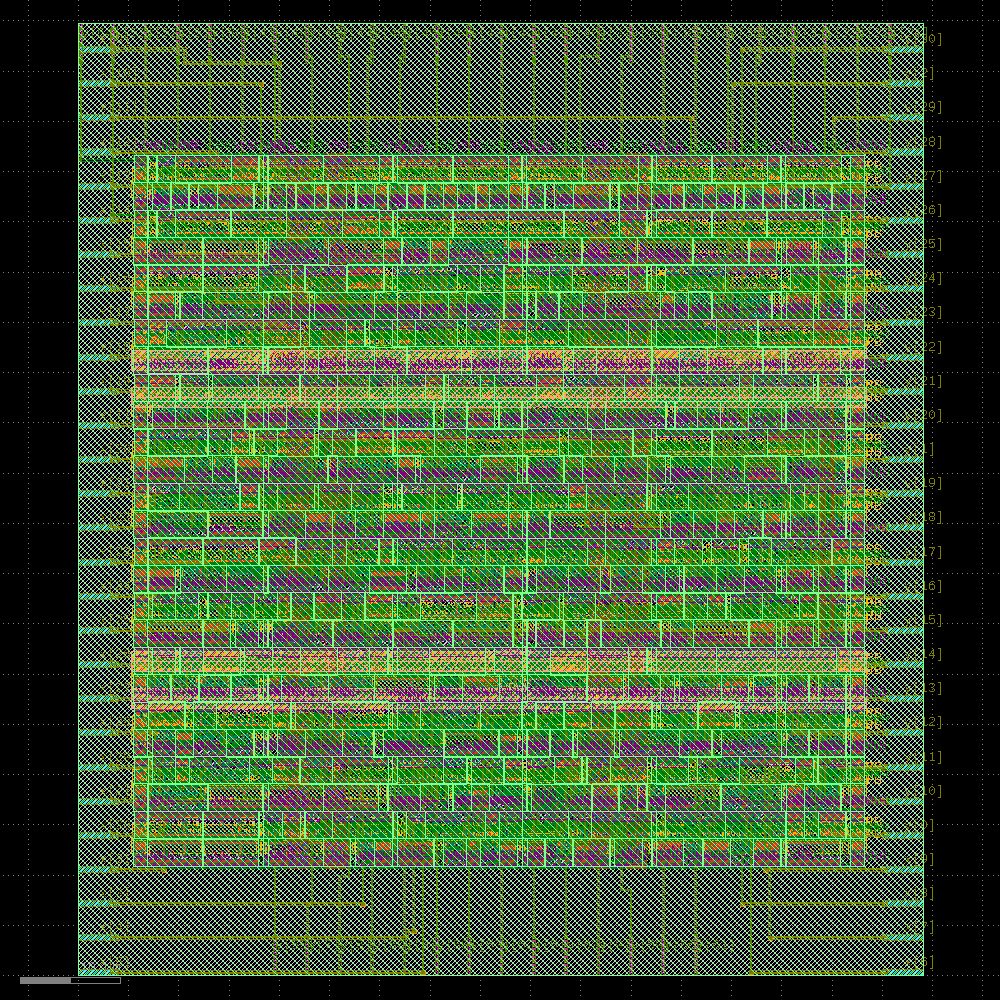

In [301]:
display(fill)

### Parasitics Extraction a.k.a. Resistance/Capacitance Extraction (RCX)

This step does not alter the design- rather, it computes the
[Parasitic elements](https://en.wikipedia.org/wiki/Parasitic_element_(electrical_networks))
of the circuit, which have an effect of timing, as we prepare to do the final
timing analysis.

The parasitic elements are saved in the **Standard Parasitics Exchange Format**,
or SPEF. OpenLane creates a SPEF file for each interconnect corner as described in
the [Corners and STA](https://openlane2.readthedocs.io/en/latest/usage/corners_and_sta.html)
section of the documentation.

In [302]:
RCX = Step.factory.get("OpenROAD.RCX")

rcx = RCX(state_in=fill.state_out)
rcx.start()

─────────────────────────────────── Parasitic Resistance/Capacitance Extraction ───────────────────────────────────

[18:49:02] VERBOSE  Running 'OpenROAD.RCX'…                                                            ]8;id=236890;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=855552;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:49:02] INFO     Running RCX for corners matching nom_*                                         ]8;id=57451;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=369434;file:///content/openlane_ipynb/openlane/steps/openroad.py#1748\1748]8;;\
                    (/content/openlane_run/125-openroad-rcx/nom/rcx.log)…                                          

[18:49:02] VERBOSE  Logging subprocess to ]8;id=655448;file:///content/openlane_run/125-openroad-rcx/nom/rcx.log\openlane_run/]8;;\]8;id=526744;file:///content/openlane_run/125-openroad-rcx/nom/rcx.log\125]8;;\]8;id=655448;file:///content/openlane_run/125-openroad-rcx/nom/rcx.log\-openroad-rcx/nom/rcx.log]8;;\…                   ]8;id=101421;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=384045;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

[18:49:02] INFO     Running RCX for corners matching min_*                                         ]8;id=581607;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=172858;file:///content/openlane_ipynb/openlane/steps/openroad.py#1748\1748]8;;\
                    (/content/openlane_run/125-openroad-rcx/min/rcx.log)…                                          

[18:49:02] VERBOSE  Logging subprocess to ]8;id=542376;file:///content/openlane_run/125-openroad-rcx/min/rcx.log\openlane_run/]8;;\]8;id=961480;file:///content/openlane_run/125-openroad-rcx/min/rcx.log\125]8;;\]8;id=542376;file:///content/openlane_run/125-openroad-rcx/min/rcx.log\-openroad-rcx/min/rcx.log]8;;\…                   ]8;id=330632;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=976009;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

[18:49:03] INFO     Finished RCX for corners matching min_*.                                       ]8;id=241849;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=349121;file:///content/openlane_ipynb/openlane/steps/openroad.py#1757\1757]8;;\

[18:49:03] INFO     Finished RCX for corners matching nom_*.                                       ]8;id=978443;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=745027;file:///content/openlane_ipynb/openlane/steps/openroad.py#1757\1757]8;;\

[18:49:03] INFO     Running RCX for corners matching max_*                                         ]8;id=983858;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=839086;file:///content/openlane_ipynb/openlane/steps/openroad.py#1748\1748]8;;\
                    (/content/openlane_run/125-openroad-rcx/max/rcx.log)…                                          

[18:49:03] VERBOSE  Logging subprocess to ]8;id=561902;file:///content/openlane_run/125-openroad-rcx/max/rcx.log\openlane_run/]8;;\]8;id=555281;file:///content/openlane_run/125-openroad-rcx/max/rcx.log\125]8;;\]8;id=561902;file:///content/openlane_run/125-openroad-rcx/max/rcx.log\-openroad-rcx/max/rcx.log]8;;\…                   ]8;id=453205;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=81573;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

[18:49:04] INFO     Finished RCX for corners matching max_*.                                       ]8;id=466289;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=814267;file:///content/openlane_ipynb/openlane/steps/openroad.py#1757\1757]8;;\

{'nl': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.nl.v'), 'pnl': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.odb'), 'sdc': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.sdc'), 'sdf': None, 'spef': {'nom_*': Path('/content/openlane_run/125-openroad-rcx/nom/SISO.nom.spef'), 'min_*': Path('/content/openlane_run/125-openroad-rcx/min/SISO.min.spef'), 'max_*': Path('/content/openlane_run/125-openroad-rcx/max/SISO.max.spef')}, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 363, 'design__instance__area': Decimal('2752.64'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 84.045 94.765', 'design__core__bbox': '5.52 10.88 78.2 81.6', 'flow__warnings__count': 4, 'flow__errors__count': 0, 'design__io': 98, 'design__die__area': Decimal('7964.52'), 'design__core__area': Decimal('5139.93'), 'design__instance__count__stdcell': 363, 'design__instance__area__stdcell': Decimal('2752.64'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.53554'), 'design__instance__utilization__stdcell': Decimal('0.53554'), 'floorplan__design__io': 96, 'design__io__hpwl': 6283326, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': 0, 'design__instance__displacement__mean': 0, 'design__instance__displacement__max': 0, 'route__wirelength__estimated': Decimal('6534.34'), 'design__violations': 0, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0, 'route__net': 325, 'route__net__special': 2, 'route__drc_errors__iter:1': 83, 'route__wirelength__iter:1': 6947, 'route__drc_errors__iter:2': 7, 'route__wirelength__iter:2': 6858, 'route__drc_errors__iter:3': 2, 'route__wirelength__iter:3': 6841, 'route__drc_errors__iter:4': 0, 'route__wirelength__iter:4': 6835, 'route__drc_errors': 0, 'route__wirelength': 6835, 'route__vias': 1988, 'route__vias__singlecut': 1988, 'route__vias__multicut': 0}}

### Static Timing Analysis (Post-PnR)

STA is a process that verifies that a chip meets certain constraints on clock
and data timings to run at its rated clock speed. See [Corners and STA](https://openlane2.readthedocs.io/en/latest/usage/corners_and_sta.html)
in the documentation for more info.

---

This step generates two kinds of files:
* `.lib`: Liberty™-compatible Library files. Can be used to do static timing
  analysis when creating a design with this design as a sub-macro.
* `.sdf`: Standard Delay Format. Can be used with certain simulation software
  to do *dynamic* timing analysis.

Unfortunately, the `.lib` files coming out of OpenLane right now are not super
reliable for timing purposes and are only provided for completeness.
When using OpenLane-created macros withing other designs, it is best to use the
macro's final netlist and extracted parasitics instead.

In [303]:
STAPostPNR = Step.factory.get("OpenROAD.STAPostPNR")

sta_post_pnr = STAPostPNR(state_in=rcx.state_out)
sta_post_pnr.start()

──────────────────────────────────────── Static Timing Analysis (Post-PnR) ────────────────────────────────────────

[18:49:04] VERBOSE  Running 'OpenROAD.STAPostPNR'…                                                     ]8;id=62225;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=361854;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:49:04] INFO     Starting STA for the nom_tt_025C_1v80 timing corner…                            ]8;id=644200;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=652;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[18:49:04] INFO     Starting STA for the nom_ss_100C_1v60 timing corner…                            ]8;id=789324;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=757000;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[18:49:04] VERBOSE  Logging subprocess to                                                              ]8;id=843784;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=748958;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=886344;file:///content/openlane_run/126-openroad-stapostpnr/nom_ss_100C_1v60/sta.log\openlane_run/]8;;\]8;id=319222;file:///content/openlane_run/126-openroad-stapostpnr/nom_ss_100C_1v60/sta.log\126]8;;\]8;id=886344;file:///content/openlane_run/126-openroad-stapostpnr/nom_ss_100C_1v60/sta.log\-openroad-stapostpnr/nom_ss_100C_1v60/sta.log]8;;\…                                 

[18:49:04] VERBOSE  Logging subprocess to                                                              ]8;id=87394;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=747483;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=221566;file:///content/openlane_run/126-openroad-stapostpnr/nom_tt_025C_1v80/sta.log\openlane_run/]8;;\]8;id=545747;file:///content/openlane_run/126-openroad-stapostpnr/nom_tt_025C_1v80/sta.log\126]8;;\]8;id=221566;file:///content/openlane_run/126-openroad-stapostpnr/nom_tt_025C_1v80/sta.log\-openroad-stapostpnr/nom_tt_025C_1v80/sta.log]8;;\…                                 

[18:49:05] INFO     Finished STA for the nom_ss_100C_1v60 timing corner.                            ]8;id=250346;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=421859;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[18:49:05] VERBOSE  Logging subprocess to                                                              ]8;id=926479;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=924516;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=596496;file:///content/openlane_run/126-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log\openlane_run/]8;;\]8;id=593925;file:///content/openlane_run/126-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log\126]8;;\]8;id=596496;file:///content/openlane_run/126-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log\-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log]8;;\…                  

[18:49:05] INFO     Finished STA for the nom_tt_025C_1v80 timing corner.                            ]8;id=869777;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=530641;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[18:49:05] VERBOSE  Logging subprocess to                                                              ]8;id=121148;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=411283;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=677551;file:///content/openlane_run/126-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log\openlane_run/]8;;\]8;id=280771;file:///content/openlane_run/126-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log\126]8;;\]8;id=677551;file:///content/openlane_run/126-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log\-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log]8;;\…                  

[18:49:06] INFO     Starting STA for the nom_ff_n40C_1v95 timing corner…                            ]8;id=509442;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=493241;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[18:49:06] VERBOSE  Logging subprocess to                                                              ]8;id=591360;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=435449;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=17591;file:///content/openlane_run/126-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log\openlane_run/]8;;\]8;id=665865;file:///content/openlane_run/126-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log\126]8;;\]8;id=17591;file:///content/openlane_run/126-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log\-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log]8;;\…                                 

[18:49:06] INFO     Starting STA for the min_tt_025C_1v80 timing corner…                            ]8;id=673695;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=565535;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[18:49:06] VERBOSE  Logging subprocess to                                                              ]8;id=21542;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=186631;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=519741;file:///content/openlane_run/126-openroad-stapostpnr/min_tt_025C_1v80/sta.log\openlane_run/]8;;\]8;id=369928;file:///content/openlane_run/126-openroad-stapostpnr/min_tt_025C_1v80/sta.log\126]8;;\]8;id=519741;file:///content/openlane_run/126-openroad-stapostpnr/min_tt_025C_1v80/sta.log\-openroad-stapostpnr/min_tt_025C_1v80/sta.log]8;;\…                                 

[18:49:08] INFO     Finished STA for the min_tt_025C_1v80 timing corner.                            ]8;id=483315;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=4431;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[18:49:08] VERBOSE  Logging subprocess to                                                              ]8;id=163257;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=221363;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=757694;file:///content/openlane_run/126-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log\openlane_run/]8;;\]8;id=133857;file:///content/openlane_run/126-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log\126]8;;\]8;id=757694;file:///content/openlane_run/126-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log\-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log]8;;\…                  

[18:49:08] INFO     Finished STA for the nom_ff_n40C_1v95 timing corner.                            ]8;id=354611;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=701193;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[18:49:08] VERBOSE  Logging subprocess to                                                              ]8;id=764486;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=311168;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=105006;file:///content/openlane_run/126-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log\openlane_run/]8;;\]8;id=280172;file:///content/openlane_run/126-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log\126]8;;\]8;id=105006;file:///content/openlane_run/126-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log\-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log]8;;\…                  

[18:49:09] INFO     Starting STA for the min_ss_100C_1v60 timing corner…                            ]8;id=171956;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=246955;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[18:49:09] VERBOSE  Logging subprocess to                                                              ]8;id=217093;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=94092;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=913667;file:///content/openlane_run/126-openroad-stapostpnr/min_ss_100C_1v60/sta.log\openlane_run/]8;;\]8;id=558111;file:///content/openlane_run/126-openroad-stapostpnr/min_ss_100C_1v60/sta.log\126]8;;\]8;id=913667;file:///content/openlane_run/126-openroad-stapostpnr/min_ss_100C_1v60/sta.log\-openroad-stapostpnr/min_ss_100C_1v60/sta.log]8;;\…                                 

[18:49:09] INFO     Starting STA for the min_ff_n40C_1v95 timing corner…                            ]8;id=954129;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=703771;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[18:49:09] VERBOSE  Logging subprocess to                                                              ]8;id=161830;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=130989;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=32393;file:///content/openlane_run/126-openroad-stapostpnr/min_ff_n40C_1v95/sta.log\openlane_run/]8;;\]8;id=116222;file:///content/openlane_run/126-openroad-stapostpnr/min_ff_n40C_1v95/sta.log\126]8;;\]8;id=32393;file:///content/openlane_run/126-openroad-stapostpnr/min_ff_n40C_1v95/sta.log\-openroad-stapostpnr/min_ff_n40C_1v95/sta.log]8;;\…                                 

[18:49:10] INFO     Finished STA for the min_ss_100C_1v60 timing corner.                            ]8;id=717112;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=441449;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[18:49:10] VERBOSE  Logging subprocess to                                                              ]8;id=625094;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=588967;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=583565;file:///content/openlane_run/126-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log\openlane_run/]8;;\]8;id=736357;file:///content/openlane_run/126-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log\126]8;;\]8;id=583565;file:///content/openlane_run/126-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log\-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log]8;;\…                  

[18:49:11] INFO     Starting STA for the max_tt_025C_1v80 timing corner…                            ]8;id=775629;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=460435;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[18:49:11] VERBOSE  Logging subprocess to                                                              ]8;id=387662;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=917305;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=894929;file:///content/openlane_run/126-openroad-stapostpnr/max_tt_025C_1v80/sta.log\openlane_run/]8;;\]8;id=821350;file:///content/openlane_run/126-openroad-stapostpnr/max_tt_025C_1v80/sta.log\126]8;;\]8;id=894929;file:///content/openlane_run/126-openroad-stapostpnr/max_tt_025C_1v80/sta.log\-openroad-stapostpnr/max_tt_025C_1v80/sta.log]8;;\…                                 

[18:49:11] INFO     Finished STA for the min_ff_n40C_1v95 timing corner.                            ]8;id=870878;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=582517;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[18:49:12] VERBOSE  Logging subprocess to                                                              ]8;id=360317;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=159485;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=199861;file:///content/openlane_run/126-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log\openlane_run/]8;;\]8;id=336440;file:///content/openlane_run/126-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log\126]8;;\]8;id=199861;file:///content/openlane_run/126-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log\-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log]8;;\…                  

[18:49:12] INFO     Starting STA for the max_ss_100C_1v60 timing corner…                            ]8;id=991236;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=402301;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[18:49:12] VERBOSE  Logging subprocess to                                                              ]8;id=979439;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=154088;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=563993;file:///content/openlane_run/126-openroad-stapostpnr/max_ss_100C_1v60/sta.log\openlane_run/]8;;\]8;id=805682;file:///content/openlane_run/126-openroad-stapostpnr/max_ss_100C_1v60/sta.log\126]8;;\]8;id=563993;file:///content/openlane_run/126-openroad-stapostpnr/max_ss_100C_1v60/sta.log\-openroad-stapostpnr/max_ss_100C_1v60/sta.log]8;;\…                                 

[18:49:12] INFO     Finished STA for the max_tt_025C_1v80 timing corner.                            ]8;id=177816;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=912374;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[18:49:12] VERBOSE  Logging subprocess to                                                              ]8;id=16228;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=461901;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=194154;file:///content/openlane_run/126-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log\openlane_run/]8;;\]8;id=961781;file:///content/openlane_run/126-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log\126]8;;\]8;id=194154;file:///content/openlane_run/126-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log\-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log]8;;\…                  

[18:49:14] INFO     Starting STA for the max_ff_n40C_1v95 timing corner…                            ]8;id=287805;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=776560;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[18:49:14] VERBOSE  Logging subprocess to                                                              ]8;id=466856;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=809978;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=251232;file:///content/openlane_run/126-openroad-stapostpnr/max_ff_n40C_1v95/sta.log\openlane_run/]8;;\]8;id=251603;file:///content/openlane_run/126-openroad-stapostpnr/max_ff_n40C_1v95/sta.log\126]8;;\]8;id=251232;file:///content/openlane_run/126-openroad-stapostpnr/max_ff_n40C_1v95/sta.log\-openroad-stapostpnr/max_ff_n40C_1v95/sta.log]8;;\…                                 

[18:49:14] INFO     Finished STA for the max_ss_100C_1v60 timing corner.                            ]8;id=506558;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=544197;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[18:49:14] VERBOSE  Logging subprocess to                                                              ]8;id=754732;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=678194;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=30459;file:///content/openlane_run/126-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log\openlane_run/]8;;\]8;id=151375;file:///content/openlane_run/126-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log\126]8;;\]8;id=30459;file:///content/openlane_run/126-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log\-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log]8;;\…                  

[18:49:17] INFO     Finished STA for the max_ff_n40C_1v95 timing corner.                            ]8;id=714415;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=618223;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[18:49:17] VERBOSE  Logging subprocess to                                                              ]8;id=947696;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=876813;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=499966;file:///content/openlane_run/126-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log\openlane_run/]8;;\]8;id=361561;file:///content/openlane_run/126-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log\126]8;;\]8;id=499966;file:///content/openlane_run/126-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log\-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log]8;;\…                  

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┓
┃                      ┃       ┃       ┃      ┃       ┃ of   ┃       ┃      ┃       ┃      ┃ of    ┃      ┃       ┃
┃                      ┃       ┃ Reg   ┃      ┃       ┃ whi… ┃       ┃ Reg  ┃       ┃      ┃ which ┃      ┃       ┃
┃                      ┃ Hold  ┃ to    ┃      ┃ Hold  ┃ reg  ┃ Setup ┃ to   ┃       ┃ Set… ┃ reg   ┃ Max  ┃ Max   ┃
┃                      ┃ Worst ┃ Reg   ┃ Hold ┃ Vio   ┃ to   ┃ Worst ┃ Reg  ┃ Setup ┃ Vio  ┃ to    ┃ Cap  ┃ Slew  ┃
┃ Corner/Group         ┃ Slack ┃ Paths ┃ TNS  ┃ Count ┃ reg  ┃ Slack ┃ Pat… ┃ TNS   ┃ Cou… ┃ reg   ┃ Vio… ┃ Viol… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━┩
│ Overall              │ 4.02… │ N/A   │ 0.0… │ 0     │ 0    │ -2.4… │ N/A  │ -64.… │ 93   │ 0     │ 5    │ 36    │
│ nom_tt_025C_1v80     │ 4.18… │ N/A   │ 0.0… │ 0     │ 0    │ 1.72… │ N/A  │ 0.00… │ 0    │ 0     │ 0    │ 36    │
│ nom_ss_100C_1v60     │ 4.59… │ N/A   │ 0.0… │ 0     │ 0    │ -2.3… │ N/A  │ -62.… │ 31   │ 0     │ 5    │ 36    │
│ nom_ff_n40C_1v95     │ 4.02… │ N/A   │ 0.0… │ 0     │ 0    │ 3.26… │ N/A  │ 0.00… │ 0    │ 0     │ 0    │ 4     │
│ min_tt_025C_1v80     │ 4.17… │ N/A   │ 0.0… │ 0     │ 0    │ 1.76… │ N/A  │ 0.00… │ 0    │ 0     │ 0    │ 36    │
│ min_ss_100C_1v60     │ 4.58… │ N/A   │ 0.0… │ 0     │ 0    │ -2.2… │ N/A  │ -60.… │ 31   │ 0     │ 3    │ 36    │
│ min_ff_n40C_1v95     │ 4.02… │ N/A   │ 0.0… │ 0     │ 0    │ 3.29… │ N/A  │ 0.00… │ 0    │ 0     │ 0    │ 2     │
│ max_tt_025C_1v80     │ 4.18… │ N/A   │ 0.0… │ 0     │ 0    │ 1.68… │ N/A  │ 0.00… │ 0    │ 0     │ 0    │ 36    │
│ max_ss_100C_1v60     │ 4.60… │ N/A   │ 0.0… │ 0     │ 0    │ -2.4… │ N/A  │ -64.… │ 31   │ 0     │ 5    │ 36    │
│ max_ff_n40C_1v95     │ 4.03… │ N/A   │ 0.0… │ 0     │ 0    │ 3.23… │ N/A  │ 0.00… │ 0    │ 0     │ 0    │ 4     │
└──────────────────────┴───────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┘

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃                      ┃ Hold     ┃ Reg to   ┃          ┃          ┃ of which  ┃ Setup    ┃           ┃          ┃           ┃ of which ┃           ┃          ┃
┃                      ┃ Worst    ┃ Reg      ┃          ┃ Hold Vio ┃ reg to    ┃ Worst    ┃ Reg to    ┃ Setup    ┃ Setup Vio ┃ reg to   ┃ Max Cap   ┃ Max Slew ┃
┃ Corner/Group         ┃ Slack    ┃ Paths    ┃ Hold TNS ┃ Count    ┃ reg       ┃ Slack    ┃ Reg Paths ┃ TNS      ┃ Count     ┃ reg      ┃ Violatio… ┃ Violati… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ Overall              │ 4.0245   │ N/A      │ 0.0000   │ 0        │ 0         │ -2.4145  │ N/A       │ -64.1156 │ 93        │ 0        │ 5         │ 36       │
│ nom_tt_025C_1v80     │ 4.1817   │ N/A      │ 0.0000   │ 0        │ 0         │ 1.7292   │ N/A       │ 0.0000   │ 0         │ 0        │ 0         │ 36       │
│ nom_ss_100C_1v60     │ 4.5913   │ N/A      │ 0.0000   │ 0        │ 0         │ -2.3454  │ N/A       │ -62.0659 │ 31        │ 0        │ 5         │ 36       │
│ nom_ff_n40C_1v95     │ 4.0279   │ N/A      │ 0.0000   │ 0        │ 0         │ 3.2657   │ N/A       │ 0.0000   │ 0         │ 0        │ 0         │ 4        │
│ min_tt_025C_1v80     │ 4.1751   │ N/A      │ 0.0000   │ 0        │ 0         │ 1.7661   │ N/A       │ 0.0000   │ 0         │ 0        │ 0         │ 36       │
│ min_ss_100C_1v60     │ 4.5837   │ N/A      │ 0.0000   │ 0        │ 0         │ -2.2977  │ N/A       │ -60.4811 │ 31        │ 0        │ 3         │ 36       │
│ min_ff_n40C_1v95     │ 4.0245   │ N/A      │ 0.0000   │ 0        │ 0         │ 3.2913   │ N/A       │ 0.0000   │ 0         │ 0        │ 0         │ 2        │
│ max_tt_025C_1v80     │ 4.1888   │ N/A      │ 0.0000   │ 0        │ 0         │ 1.6889   │ N/A       │ 0.0000   │ 0         │ 0        │ 0         │ 36       │
│ max_ss_100C_1v60     │ 4.6011   │ N/A      │ 0.0000   │ 0        │ 0         │ -2.4145  │ N/A       │ -64.1156 │ 31        │ 0        │ 5         │ 36       │
│ max_ff_n40C_1v95     │ 4.0325   │ N/A      │ 0.0000   │ 0        │ 0         │ 3.2373   │ N/A       │ 0.0000   │ 0         │ 0        │ 0         │ 4        │
└──────────────────────┴──────────┴──────────┴──────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┘

{'nl': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.nl.v'), 'pnl': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.odb'), 'sdc': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/nom_tt_025C_1v80/SISO__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/nom_ss_100C_1v60/SISO__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/nom_ff_n40C_1v95/SISO__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/min_tt_025C_1v80/SISO__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/min_ss_100C_1v60/SISO__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/min_ff_n40C_1v95/SISO__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/max_tt_025C_1v80/SISO__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/max_ss_100C_1v60/SISO__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/max_ff_n40C_1v95/SISO__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/125-openroad-rcx/nom/SISO.nom.spef'), 'min_*': Path('/content/openlane_run/125-openroad-rcx/min/SISO.min.spef'), 'max_*': Path('/content/openlane_run/125-openroad-rcx/max/SISO.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/nom_tt_025C_1v80/SISO__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/nom_ss_100C_1v60/SISO__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/nom_ff_n40C_1v95/SISO__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/min_tt_025C_1v80/SISO__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/min_ss_100C_1v60/SISO__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/min_ff_n40C_1v95/SISO__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/max_tt_025C_1v80/SISO__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/max_ss_100C_1v60/SISO__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/max_ff_n40C_1v95/SISO__max_ff_n40C_1v95.lib')}, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 363, 'design__instance__area': Decimal('2752.64'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 84.045 94.765', 'design__core__bbox': '5.52 10.88 78.2 81.6', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 98, 'design__die__area': Decimal('7964.52'), 'design__core__area': Decimal('5139.93'), 'design__instance__count__stdcell': 363, 'design__instance__area__stdcell': Decimal('2752.64'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.53554'), 'design__instance__utilization__stdcell': Decimal('0.53554'), 'floorplan__design__io': 96, 'design__io__hpwl': 6283326, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': 0, 'design__instance__displacement__mean': 0, 'design__instance__displacement__max': 0, 'route__wireleng

### Stream-out

Stream-out is the process of converting the designs from the abstract formats
using during floorplanning, placement and routing into a concrete format called
GDSII (lit. Graphic Design System 2), which is the final file that is then sent
for fabrication.

In [304]:
StreamOut = Step.factory.get("KLayout.StreamOut")

gds = StreamOut(state_in=sta_post_pnr.state_out)
gds.start()

─────────────────────────────────────────── GDSII Stream Out (KLayout) ────────────────────────────────────────────

[18:49:17] VERBOSE  Running 'KLayout.StreamOut'…                                                       ]8;id=307510;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=366616;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:49:17] VERBOSE  Logging subprocess to ]8;id=528294;file:///content/openlane_run/127-klayout-streamout/klayout-streamout.log\openlane_run/]8;;\]8;id=341120;file:///content/openlane_run/127-klayout-streamout/klayout-streamout.log\127]8;;\]8;id=528294;file:///content/openlane_run/127-klayout-streamout/klayout-streamout.log\-klayout-streamout/klayout-streamout.log]8;;\…    ]8;id=472957;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=404103;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

[INFO] Clearing cells…

[INFO] Merging GDS files…

[INFO] Copying top level cell 'SISO'…

[INFO] Checking for missing GDS…

[INFO] All LEF cells have matching GDS cells.

[INFO] Writing out GDS '/content/openlane_run/127-klayout-streamout/SISO.klayout.gds'…

[INFO] Done.

{'nl': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.nl.v'), 'pnl': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.odb'), 'sdc': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/nom_tt_025C_1v80/SISO__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/nom_ss_100C_1v60/SISO__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/nom_ff_n40C_1v95/SISO__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/min_tt_025C_1v80/SISO__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/min_ss_100C_1v60/SISO__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/min_ff_n40C_1v95/SISO__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/max_tt_025C_1v80/SISO__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/max_ss_100C_1v60/SISO__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/max_ff_n40C_1v95/SISO__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/125-openroad-rcx/nom/SISO.nom.spef'), 'min_*': Path('/content/openlane_run/125-openroad-rcx/min/SISO.min.spef'), 'max_*': Path('/content/openlane_run/125-openroad-rcx/max/SISO.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/nom_tt_025C_1v80/SISO__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/nom_ss_100C_1v60/SISO__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/nom_ff_n40C_1v95/SISO__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/min_tt_025C_1v80/SISO__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/min_ss_100C_1v60/SISO__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/min_ff_n40C_1v95/SISO__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/max_tt_025C_1v80/SISO__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/max_ss_100C_1v60/SISO__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/max_ff_n40C_1v95/SISO__max_ff_n40C_1v95.lib')}, 'spice': None, 'mag': None, 'gds': Path('/content/openlane_run/127-klayout-streamout/SISO.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/127-klayout-streamout/SISO.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 363, 'design__instance__area': Decimal('2752.64'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 84.045 94.765', 'design__core__bbox': '5.52 10.88 78.2 81.6', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 98, 'design__die__area': Decimal('7964.52'), 'design__core__area': Decimal('5139.93'), 'design__instance__count__stdcell': 363, 'design__instance__area__stdcell': Decimal('2752.64'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.53554'), 'design__instance__utilization__stdcell': Decimal('0.53554'), 'floorplan__design__io': 96, 'design__io__hpwl': 6283326, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displa

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[18:49:18] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=283899;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=601081;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:49:18] VERBOSE  Logging subprocess to ]8;id=764145;file:///tmp/openlane_klayout_tmp_zsa7uf06/klayout-render.log\..]8;;\]8;id=706863;file:///tmp/openlane_klayout_tmp_zsa7uf06/klayout-render.log\/tmp/openlane_klayout_tmp_zsa7uf06/]8;;\]8;id=764094;file:///tmp/openlane_klayout_tmp_zsa7uf06/klayout-render.log\klayout-render.log]8;;\…     ]8;id=512270;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=250288;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 0.62s
#### Views updated:
* GDSII Stream
* GDSII Stream (KLayout)
#### Preview:
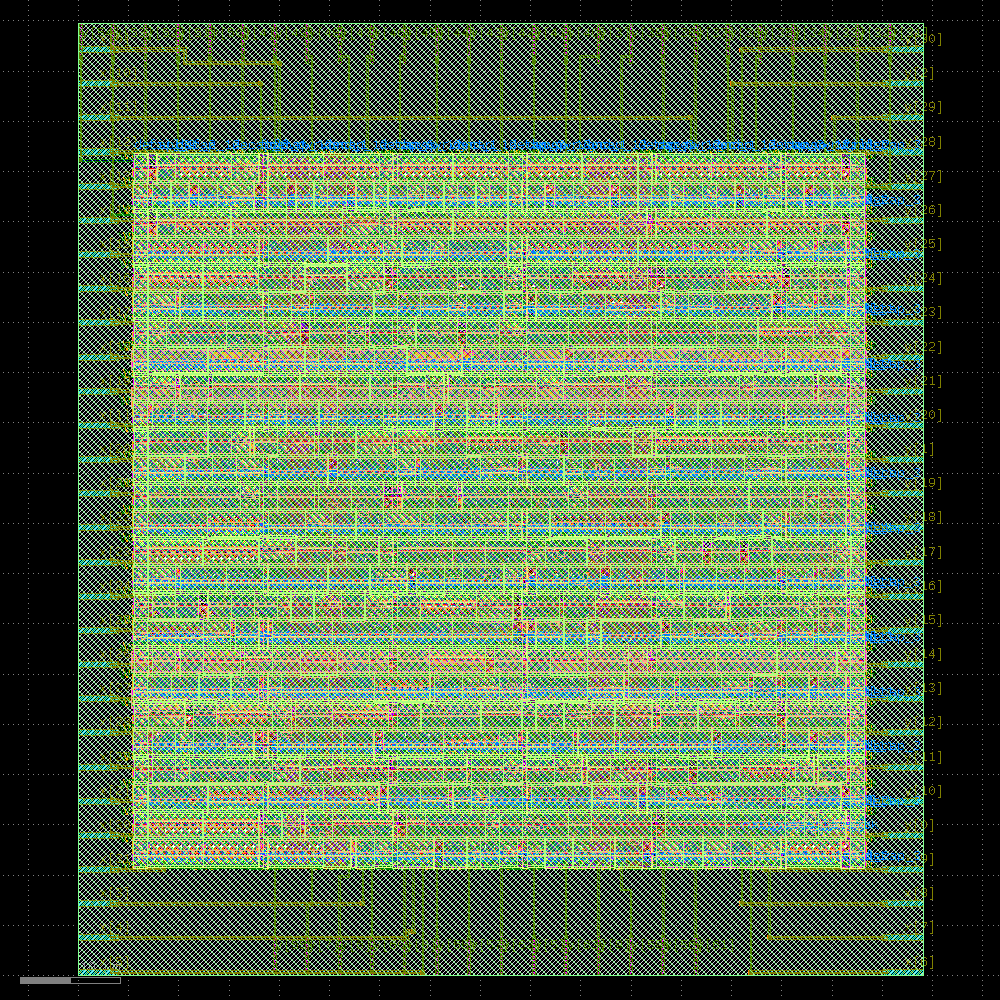

In [305]:
display(gds)

### Design Rule Checks (DRC)

DRC determines that the final layout does not violate any of the rules set by
the foundry to ensure the design is actually manufacturable- for example,
not enough space between two wires, *too much* space between tap cells, and so
on.

A design not passing DRC will typically be rejected by the foundry, who
also run DRC on their side.

In [306]:
DRC = Step.factory.get("Magic.DRC")

drc = DRC(state_in=gds.state_out)
drc.start()

─────────────────────────────────────────────── Design Rule Checks ────────────────────────────────────────────────

[18:49:19] VERBOSE  Running 'Magic.DRC'…                                                               ]8;id=405186;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=882889;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:49:19] VERBOSE  Logging subprocess to ]8;id=680195;file:///content/openlane_run/128-magic-drc/magic-drc.log\openlane_run/]8;;\]8;id=383621;file:///content/openlane_run/128-magic-drc/magic-drc.log\128]8;;\]8;id=680195;file:///content/openlane_run/128-magic-drc/magic-drc.log\-magic-drc/magic-drc.log]8;;\…                    ]8;id=405973;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=512736;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Magic 8.3 revision 483 - Compiled on Sun Jun  2 18:57:41 UTC 2024.

Starting magic under Tcl interpreter

Using the terminal as the console.

Using NULL graphics device.

Processing system .magicrc file

Sourcing design .magicrc for technology sky130A ...

2 Magic internal units = 1 Lambda

Input style sky130(): scaleFactor=2, multiplier=2

The following types are not handled by extraction and will be treated as non-electrical types:

ubm

Scaled tech values by 2 / 1 to match internal grid scaling

Loading sky130A Device Generator Menu ...

Loading "/content/openlane_ipynb/openlane/scripts/magic/wrapper.tcl" from command line.

Warning: Calma reading is not undoable!  I hope that's OK.

Library written using GDS-II Release 6.0

Library name: LIB

Reading "VIA_M3M4_PR".

Reading "VIA_M2M3_PR".

Reading "VIA_M1M2_PR_MR".

Reading "VIA_M1M2_PR".

Reading "VIA_L1M1_PR_MR".

Reading "VIA_via2_3_2000_480_1_6_320_320".

Reading "VIA_via3_4_2000_480_1_5_400_400".

Reading "VIA_via4_5_2000_480_1_5_400_400".

Reading "VIA_via5_6_2000_2000_1_1_1600_1600".

Reading "sky130_fd_sc_hd__buf_2".

Reading "sky130_fd_sc_hd__conb_1".

Reading "sky130_fd_sc_hd__nor4b_2".

Reading "sky130_fd_sc_hd__a211o_2".

Reading "sky130_fd_sc_hd__nor4_2".

Reading "sky130_fd_sc_hd__and4b_2".

Reading "sky130_fd_sc_hd__o2111a_2".

Reading "sky130_fd_sc_hd__and3b_2".

Reading "sky130_fd_sc_hd__nor3_2".

Reading "sky130_fd_sc_hd__a31oi_2".

Reading "sky130_fd_sc_hd__o221a_2".

Reading "sky130_fd_sc_hd__o31a_2".

Reading "sky130_fd_sc_hd__or4_2".

Reading "sky130_fd_sc_hd__nand3_2".

Reading "sky130_fd_sc_hd__a22o_2".

Reading "sky130_fd_sc_hd__nand4_2".

Reading "sky130_fd_sc_hd__o211a_2".

Reading "sky130_fd_sc_hd__o22a_2".

Reading "sky130_fd_sc_hd__o21bai_2".

Reading "sky130_fd_sc_hd__o2bb2a_2".

Reading "sky130_fd_sc_hd__a2111o_2".

Reading "sky130_fd_sc_hd__a21bo_2".

Reading "sky130_fd_sc_hd__or3b_2".

Reading "sky130_fd_sc_hd__nand2b_2".

Reading "sky130_fd_sc_hd__a22oi_2".

Reading "sky130_fd_sc_hd__a21o_2".

Reading "sky130_fd_sc_hd__a21boi_2".

Reading "sky130_fd_sc_hd__o32a_2".

Reading "sky130_fd_sc_hd__or4b_2".

Reading "sky130_fd_sc_hd__a31o_2".

Reading "sky130_fd_sc_hd__and4bb_2".

Reading "sky130_fd_sc_hd__a221o_2".

Reading "sky130_fd_sc_hd__and4_2".

Reading "sky130_fd_sc_hd__o21a_2".

Reading "sky130_fd_sc_hd__and2b_2".

Reading "sky130_fd_sc_hd__o21ai_2".

Reading "sky130_fd_sc_hd__a32o_2".

Reading "sky130_fd_sc_hd__or3_2".

Reading "sky130_fd_sc_hd__nor2_2".

Reading "sky130_fd_sc_hd__xnor2_2".

Reading "sky130_fd_sc_hd__xor2_2".

Reading "sky130_fd_sc_hd__a21oi_2".

Reading "sky130_fd_sc_hd__and3_2".

Reading "sky130_fd_sc_hd__and2_2".

Reading "sky130_fd_sc_hd__or2_2".

Reading "sky130_fd_sc_hd__nand2_2".

Reading "sky130_fd_sc_hd__inv_2".

Reading "sky130_fd_sc_hd__tapvpwrvgnd_1".

Reading "sky130_fd_sc_hd__decap_3".

Reading "sky130_fd_sc_hd__decap_8".

Reading "sky130_fd_sc_hd__decap_4".

Reading "sky130_ef_sc_hd__decap_12".

Reading "sky130_fd_sc_hd__decap_6".

Reading "sky130_fd_sc_hd__fill_2".

Reading "sky130_fd_sc_hd__fill_1".

Reading "SISO".

[INFO] Loading SISO

DRC style is now "drc(full)"

Loading DRC CIF style.

No errors found.

[INFO] COUNT: 0

[INFO] Should be divided by 3 or 4

[INFO] DRC Checking DONE (/content/openlane_run/128-magic-drc/reports/drc_violations.magic.rpt)

[INFO] Saving mag view with DRC errors (/content/openlane_run/128-magic-drc/views/SISO.drc.mag)

[INFO] Saved

{'nl': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.nl.v'), 'pnl': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.odb'), 'sdc': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/nom_tt_025C_1v80/SISO__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/nom_ss_100C_1v60/SISO__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/nom_ff_n40C_1v95/SISO__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/min_tt_025C_1v80/SISO__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/min_ss_100C_1v60/SISO__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/min_ff_n40C_1v95/SISO__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/max_tt_025C_1v80/SISO__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/max_ss_100C_1v60/SISO__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/max_ff_n40C_1v95/SISO__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/125-openroad-rcx/nom/SISO.nom.spef'), 'min_*': Path('/content/openlane_run/125-openroad-rcx/min/SISO.min.spef'), 'max_*': Path('/content/openlane_run/125-openroad-rcx/max/SISO.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/nom_tt_025C_1v80/SISO__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/nom_ss_100C_1v60/SISO__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/nom_ff_n40C_1v95/SISO__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/min_tt_025C_1v80/SISO__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/min_ss_100C_1v60/SISO__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/min_ff_n40C_1v95/SISO__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/max_tt_025C_1v80/SISO__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/max_ss_100C_1v60/SISO__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/max_ff_n40C_1v95/SISO__max_ff_n40C_1v95.lib')}, 'spice': None, 'mag': None, 'gds': Path('/content/openlane_run/127-klayout-streamout/SISO.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/127-klayout-streamout/SISO.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 363, 'design__instance__area': Decimal('2752.64'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 84.045 94.765', 'design__core__bbox': '5.52 10.88 78.2 81.6', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 98, 'design__die__area': Decimal('7964.52'), 'design__core__area': Decimal('5139.93'), 'design__instance__count__stdcell': 363, 'design__instance__area__stdcell': Decimal('2752.64'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.53554'), 'design__instance__utilization__stdcell': Decimal('0.53554'), 'floorplan__design__io': 96, 'design__io__hpwl': 6283326, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displa

### SPICE Extraction for Layout vs. Schematic Check

This step tries to reconstruct a SPICE netlist from the GDSII file, so it can
later be used for the **Layout vs. Schematic** (LVS) check.

In [307]:
SpiceExtraction = Step.factory.get("Magic.SpiceExtraction")

spx = SpiceExtraction(state_in=drc.state_out)
spx.start()

───────────────────────────────────────────── SPICE Model Extraction ──────────────────────────────────────────────

[18:49:21] VERBOSE  Running 'Magic.SpiceExtraction'…                                                   ]8;id=759415;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=472483;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:49:21] VERBOSE  Logging subprocess to                                                              ]8;id=798244;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=501252;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=95978;file:///content/openlane_run/129-magic-spiceextraction/magic-spiceextraction.log\openlane_run/]8;;\]8;id=574576;file:///content/openlane_run/129-magic-spiceextraction/magic-spiceextraction.log\129]8;;\]8;id=95978;file:///content/openlane_run/129-magic-spiceextraction/magic-spiceextraction.log\-magic-spiceextraction/magic-spiceextraction.log]8;;\…                              

Magic 8.3 revision 483 - Compiled on Sun Jun  2 18:57:41 UTC 2024.

Starting magic under Tcl interpreter

Using the terminal as the console.

Using NULL graphics device.

Processing system .magicrc file

Sourcing design .magicrc for technology sky130A ...

2 Magic internal units = 1 Lambda

Input style sky130(): scaleFactor=2, multiplier=2

The following types are not handled by extraction and will be treated as non-electrical types:

ubm

Scaled tech values by 2 / 1 to match internal grid scaling

Loading sky130A Device Generator Menu ...

Loading "/content/openlane_ipynb/openlane/scripts/magic/wrapper.tcl" from command line.

> lef read /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef

Reading LEF data from file /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef.

This action cannot be undone.

LEF read, Line 78 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 79 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 112 (Message): Unknown keyword "MINENCLOSEDAREA" in LEF file; ignoring.

LEF read, Line 114 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 115 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 121 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 122 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 123 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 156 (Message): Unknown keyword "MINENCLOSEDAREA" in LEF file; ignoring.

LEF read, Line 164 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 165 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 167 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 168 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 169 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 206 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 207 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 209 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 210 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 211 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 248 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 249 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 251 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 252 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 253 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 290 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 291 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read: Processed 797 lines.

> lef read /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef

Reading LEF data from file /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef.

This action cannot be undone.

LEF read: Processed 56535 lines.

> lef read /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef

Reading LEF data from file /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef.

This action cannot be undone.

LEF read: Processed 278 lines.

> def read /content/openlane_run/124-openroad-fillinsertion/SISO.def -noblockage -labels

Reading DEF data from file /content/openlane_run/124-openroad-fillinsertion/SISO.def.

This action cannot be undone.

Processed 4 vias total.

Processed 777 subcell instances total.

Processed 98 pins total.

Processed 2 special nets total.

Processed 325 nets total.

DEF read: Processed 5643 lines.

Moving label "_018_" from metal1 to via1 in cell SISO.

Moving label "_029_" from metal1 to via1 in cell SISO.

Moving label "_043_" from metal2 to via1 in cell SISO.

Moving label "_064_" from metal1 to via1 in cell SISO.

Moving label "_193_" from metal2 to via2 in cell SISO.

Moving label "y[13]" from metal2 to via2 in cell SISO.

Moving label "y[21]" from metal2 to via2 in cell SISO.

Moving label "y[23]" from metal2 to via2 in cell SISO.

Processing SISO

Extracting sky130_ef_sc_hd__decap_12 into sky130_ef_sc_hd__decap_12.ext:

Extracting sky130_fd_sc_hd__decap_3 into sky130_fd_sc_hd__decap_3.ext:

Extracting sky130_fd_sc_hd__fill_1 into sky130_fd_sc_hd__fill_1.ext:

Extracting sky130_fd_sc_hd__decap_6 into sky130_fd_sc_hd__decap_6.ext:

Extracting sky130_fd_sc_hd__decap_4 into sky130_fd_sc_hd__decap_4.ext:

Extracting sky130_fd_sc_hd__tapvpwrvgnd_1 into sky130_fd_sc_hd__tapvpwrvgnd_1.ext:

Extracting sky130_fd_sc_hd__and3_2 into sky130_fd_sc_hd__and3_2.ext:

Extracting sky130_fd_sc_hd__buf_2 into sky130_fd_sc_hd__buf_2.ext:

Extracting sky130_fd_sc_hd__xor2_2 into sky130_fd_sc_hd__xor2_2.ext:

Extracting sky130_fd_sc_hd__decap_8 into sky130_fd_sc_hd__decap_8.ext:

Extracting sky130_fd_sc_hd__fill_2 into sky130_fd_sc_hd__fill_2.ext:

Extracting sky130_fd_sc_hd__nand2_2 into sky130_fd_sc_hd__nand2_2.ext:

Extracting sky130_fd_sc_hd__xnor2_2 into sky130_fd_sc_hd__xnor2_2.ext:

Extracting sky130_fd_sc_hd__or2_2 into sky130_fd_sc_hd__or2_2.ext:

Extracting sky130_fd_sc_hd__and2_2 into sky130_fd_sc_hd__and2_2.ext:

Extracting sky130_fd_sc_hd__and4bb_2 into sky130_fd_sc_hd__and4bb_2.ext:

Extracting sky130_fd_sc_hd__conb_1 into sky130_fd_sc_hd__conb_1.ext:

Extracting sky130_fd_sc_hd__a31o_2 into sky130_fd_sc_hd__a31o_2.ext:

Extracting sky130_fd_sc_hd__and3b_2 into sky130_fd_sc_hd__and3b_2.ext:

Extracting sky130_fd_sc_hd__o21a_2 into sky130_fd_sc_hd__o21a_2.ext:

Extracting sky130_fd_sc_hd__nor2_2 into sky130_fd_sc_hd__nor2_2.ext:

Extracting sky130_fd_sc_hd__nor4_2 into sky130_fd_sc_hd__nor4_2.ext:

Extracting sky130_fd_sc_hd__o32a_2 into sky130_fd_sc_hd__o32a_2.ext:

Extracting sky130_fd_sc_hd__o21ai_2 into sky130_fd_sc_hd__o21ai_2.ext:

Extracting sky130_fd_sc_hd__a21oi_2 into sky130_fd_sc_hd__a21oi_2.ext:

Extracting sky130_fd_sc_hd__nor3_2 into sky130_fd_sc_hd__nor3_2.ext:

Extracting sky130_fd_sc_hd__or3_2 into sky130_fd_sc_hd__or3_2.ext:

Extracting sky130_fd_sc_hd__and4_2 into sky130_fd_sc_hd__and4_2.ext:

Extracting sky130_fd_sc_hd__a221o_2 into sky130_fd_sc_hd__a221o_2.ext:

Extracting sky130_fd_sc_hd__inv_2 into sky130_fd_sc_hd__inv_2.ext:

Extracting sky130_fd_sc_hd__or4b_2 into sky130_fd_sc_hd__or4b_2.ext:

Extracting sky130_fd_sc_hd__a21bo_2 into sky130_fd_sc_hd__a21bo_2.ext:

Extracting sky130_fd_sc_hd__a31oi_2 into sky130_fd_sc_hd__a31oi_2.ext:

Extracting sky130_fd_sc_hd__a21o_2 into sky130_fd_sc_hd__a21o_2.ext:

Extracting sky130_fd_sc_hd__a21boi_2 into sky130_fd_sc_hd__a21boi_2.ext:

Extracting sky130_fd_sc_hd__nand2b_2 into sky130_fd_sc_hd__nand2b_2.ext:

Extracting sky130_fd_sc_hd__nand4_2 into sky130_fd_sc_hd__nand4_2.ext:

Extracting sky130_fd_sc_hd__a22o_2 into sky130_fd_sc_hd__a22o_2.ext:

Extracting sky130_fd_sc_hd__o221a_2 into sky130_fd_sc_hd__o221a_2.ext:

Extracting sky130_fd_sc_hd__and4b_2 into sky130_fd_sc_hd__and4b_2.ext:

Extracting sky130_fd_sc_hd__and2b_2 into sky130_fd_sc_hd__and2b_2.ext:

Extracting sky130_fd_sc_hd__nand3_2 into sky130_fd_sc_hd__nand3_2.ext:

Extracting sky130_fd_sc_hd__nor4b_2 into sky130_fd_sc_hd__nor4b_2.ext:

Extracting sky130_fd_sc_hd__o21bai_2 into sky130_fd_sc_hd__o21bai_2.ext:

Extracting sky130_fd_sc_hd__o2111a_2 into sky130_fd_sc_hd__o2111a_2.ext:

Extracting sky130_fd_sc_hd__o31a_2 into sky130_fd_sc_hd__o31a_2.ext:

Extracting sky130_fd_sc_hd__o211a_2 into sky130_fd_sc_hd__o211a_2.ext:

Extracting sky130_fd_sc_hd__or4_2 into sky130_fd_sc_hd__or4_2.ext:

Extracting sky130_fd_sc_hd__o22a_2 into sky130_fd_sc_hd__o22a_2.ext:

Extracting sky130_fd_sc_hd__or3b_2 into sky130_fd_sc_hd__or3b_2.ext:

Extracting sky130_fd_sc_hd__a2111o_2 into sky130_fd_sc_hd__a2111o_2.ext:

Extracting sky130_fd_sc_hd__a211o_2 into sky130_fd_sc_hd__a211o_2.ext:

Extracting sky130_fd_sc_hd__a22oi_2 into sky130_fd_sc_hd__a22oi_2.ext:

Extracting sky130_fd_sc_hd__o2bb2a_2 into sky130_fd_sc_hd__o2bb2a_2.ext:

Extracting sky130_fd_sc_hd__a32o_2 into sky130_fd_sc_hd__a32o_2.ext:

Extracting SISO into SISO.ext:

exttospice finished.

Using technology "sky130A", version 1.0.466-0-gbdc9412

{'nl': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.nl.v'), 'pnl': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.odb'), 'sdc': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/nom_tt_025C_1v80/SISO__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/nom_ss_100C_1v60/SISO__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/nom_ff_n40C_1v95/SISO__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/min_tt_025C_1v80/SISO__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/min_ss_100C_1v60/SISO__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/min_ff_n40C_1v95/SISO__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/max_tt_025C_1v80/SISO__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/max_ss_100C_1v60/SISO__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/max_ff_n40C_1v95/SISO__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/125-openroad-rcx/nom/SISO.nom.spef'), 'min_*': Path('/content/openlane_run/125-openroad-rcx/min/SISO.min.spef'), 'max_*': Path('/content/openlane_run/125-openroad-rcx/max/SISO.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/nom_tt_025C_1v80/SISO__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/nom_ss_100C_1v60/SISO__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/nom_ff_n40C_1v95/SISO__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/min_tt_025C_1v80/SISO__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/min_ss_100C_1v60/SISO__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/min_ff_n40C_1v95/SISO__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/max_tt_025C_1v80/SISO__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/max_ss_100C_1v60/SISO__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/max_ff_n40C_1v95/SISO__max_ff_n40C_1v95.lib')}, 'spice': Path('/content/openlane_run/129-magic-spiceextraction/SISO.spice'), 'mag': None, 'gds': Path('/content/openlane_run/127-klayout-streamout/SISO.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/127-klayout-streamout/SISO.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 363, 'design__instance__area': Decimal('2752.64'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 84.045 94.765', 'design__core__bbox': '5.52 10.88 78.2 81.6', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 98, 'design__die__area': Decimal('7964.52'), 'design__core__area': Decimal('5139.93'), 'design__instance__count__stdcell': 363, 'design__instance__area__stdcell': Decimal('2752.64'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.53554'), 'design__instance__utilization__stdcell': Decimal('0.53554'), 'floorplan__design__io': 96, 'design__io__hpwl': 6283326, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'desi

### Layout vs. Schematic (LVS)

A comparison between the final Verilog netlist (from PnR) and the final
SPICE netlist (extracted.)

This check effectively compares the physically implemented circuit to the final
Verilog netlist output by OpenROAD.

The idea is, if there are any disconnects, shorts or other mismatches in the
physical implementation that do not exist in the logical view of the design,
they would be caught at this step.

Common issues that result in LVS violations include:
* Lack of fill cells or tap cells in the design
* Two unrelated signals to be shorted, or a wire to be disconnected (most
  commonly seen with misconfigured PDN)

Chips with LVS errors are typically dead on arrival.

In [308]:
LVS = Step.factory.get("Netgen.LVS")

lvs = LVS(state_in=spx.state_out)
lvs.start()

─────────────────────────────────────────────────── Netgen LVS ────────────────────────────────────────────────────

[18:49:22] VERBOSE  Running 'Netgen.LVS'…                                                              ]8;id=131206;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=852413;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[18:49:22] VERBOSE  Logging subprocess to ]8;id=792403;file:///content/openlane_run/130-netgen-lvs/netgen-lvs.log\openlane_run/]8;;\]8;id=523611;file:///content/openlane_run/130-netgen-lvs/netgen-lvs.log\130]8;;\]8;id=792403;file:///content/openlane_run/130-netgen-lvs/netgen-lvs.log\-netgen-lvs/netgen-lvs.log]8;;\…                  ]8;id=810413;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=16824;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Netgen 1.5.270 compiled on Sun Jun  2 19:00:27 UTC 2024

Warning: netgen command 'format' use fully-qualified name '::netgen::format'

Warning: netgen command 'global' use fully-qualified name '::netgen::global'

Warning:  A case-insensitive file has been read and so the      verilog file must be treated case-insensitive to   
match.

Reading SPICE netlist file                                                                                         
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__decap_12.spice'...

Call to undefined subcircuit sky130_fd_pr__pfet_01v8_hvt

Creating placeholder cell definition.

Call to undefined subcircuit sky130_fd_pr__nfet_01v8

Creating placeholder cell definition.

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_12.spice'...

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_4.spice'...

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_8.spice'...

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice'...

Call to undefined subcircuit sky130_fd_sc_hd__nand2_2

Creating placeholder cell definition.

Call to undefined subcircuit sky130_fd_sc_hd__nor2_2

Creating placeholder cell definition.

Warning:  A case-insensitive file has been read and so the      verilog file must be treated case-insensitive to   
match.

Note:  Implicit pin HI in instance _489_ of sky130_fd_sc_hd__conb_1 in cell SISO

Treating empty subcircuits as black-box cells

Generating JSON file result

Reading setup file /content/openlane_ipynb/openlane/scripts/netgen/setup.tcl

Model sky130_fd_pr__res_generic_po pin end_a == end_b

No property mult found for device sky130_fd_pr__res_generic_po

Model sky130_fd_pr__nfet_01v8 pin 1 == 3

No property mult found for device sky130_fd_pr__nfet_01v8

No property sa found for device sky130_fd_pr__nfet_01v8

No property sb found for device sky130_fd_pr__nfet_01v8

No property sd found for device sky130_fd_pr__nfet_01v8

No property nf found for device sky130_fd_pr__nfet_01v8

No property nrd found for device sky130_fd_pr__nfet_01v8

No property nrs found for device sky130_fd_pr__nfet_01v8

No property area found for device sky130_fd_pr__nfet_01v8

No property perim found for device sky130_fd_pr__nfet_01v8

No property topography found for device sky130_fd_pr__nfet_01v8

Model sky130_fd_pr__pfet_01v8_hvt pin 1 == 3

No property mult found for device sky130_fd_pr__pfet_01v8_hvt

No property sa found for device sky130_fd_pr__pfet_01v8_hvt

No property sb found for device sky130_fd_pr__pfet_01v8_hvt

No property sd found for device sky130_fd_pr__pfet_01v8_hvt

No property nf found for device sky130_fd_pr__pfet_01v8_hvt

No property nrd found for device sky130_fd_pr__pfet_01v8_hvt

No property nrs found for device sky130_fd_pr__pfet_01v8_hvt

No property area found for device sky130_fd_pr__pfet_01v8_hvt

No property perim found for device sky130_fd_pr__pfet_01v8_hvt

No property topography found for device sky130_fd_pr__pfet_01v8_hvt

No property value found for device sky130_fd_pr__diode_pw2nd_05v5

No property mult found for device sky130_fd_pr__diode_pw2nd_05v5

No property perim found for device sky130_fd_pr__diode_pw2nd_05v5

Comparison output logged to file /content/openlane_run/130-netgen-lvs/reports/lvs.netgen.rpt

Logging to file "/content/openlane_run/130-netgen-lvs/reports/lvs.netgen.rpt" enabled

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__buf_2'

Circuit sky130_fd_sc_hd__buf_2 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__buf_2'

Circuit sky130_fd_sc_hd__buf_2 contains 6 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   3

Class: sky130_fd_pr__pfet_01v8_hvt instances:   3

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__buf_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__xnor2_2'

Circuit sky130_fd_sc_hd__xnor2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__xnor2_2'

Circuit sky130_fd_sc_hd__xnor2_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__xnor2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or2_2'

Circuit sky130_fd_sc_hd__or2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or2_2'

Circuit sky130_fd_sc_hd__or2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__or2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and4_2'

Circuit sky130_fd_sc_hd__and4_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and4_2'

Circuit sky130_fd_sc_hd__and4_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__and4_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_4'

Circuit sky130_fd_sc_hd__decap_4 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_4'

Circuit sky130_fd_sc_hd__decap_4 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_8'

Circuit sky130_fd_sc_hd__decap_8 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_8'

Circuit sky130_fd_sc_hd__decap_8 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_8 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand2_2'

Circuit sky130_fd_sc_hd__nand2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand2_2'

Circuit sky130_fd_sc_hd__nand2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__nand2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a31o_2'

Circuit sky130_fd_sc_hd__a31o_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a31o_2'

Circuit sky130_fd_sc_hd__a31o_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a31o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_ef_sc_hd__decap_12'

Circuit sky130_ef_sc_hd__decap_12 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_ef_sc_hd__decap_12'

Circuit sky130_ef_sc_hd__decap_12 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_ef_sc_hd__decap_12 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__fill_2'

Circuit sky130_fd_sc_hd__fill_2 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__fill_2'

Circuit sky130_fd_sc_hd__fill_2 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Circuit sky130_fd_sc_hd__fill_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__fill_1'

Circuit sky130_fd_sc_hd__fill_1 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__fill_1'

Circuit sky130_fd_sc_hd__fill_1 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Circuit sky130_fd_sc_hd__fill_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__tapvpwrvgnd_1'

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains 0 device instances.

Circuit contains 0 nets, and 2 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__tapvpwrvgnd_1'

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains 0 device instances.

Circuit contains 0 nets, and 2 disconnected pins.

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand2b_2'

Circuit sky130_fd_sc_hd__nand2b_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand2b_2'

Circuit sky130_fd_sc_hd__nand2b_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__nand2b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__xor2_2'

Circuit sky130_fd_sc_hd__xor2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__xor2_2'

Circuit sky130_fd_sc_hd__xor2_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__xor2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor4_2'

Circuit sky130_fd_sc_hd__nor4_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor4_2'

Circuit sky130_fd_sc_hd__nor4_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__nor4_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_3'

Circuit sky130_fd_sc_hd__decap_3 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_3'

Circuit sky130_fd_sc_hd__decap_3 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_3 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_6'

Circuit sky130_fd_sc_hd__decap_6 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_6'

Circuit sky130_fd_sc_hd__decap_6 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_6 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and2_2'

Circuit sky130_fd_sc_hd__and2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and2_2'

Circuit sky130_fd_sc_hd__and2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__and2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a221o_2'

Circuit sky130_fd_sc_hd__a221o_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a221o_2'

Circuit sky130_fd_sc_hd__a221o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a221o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__conb_1'

Circuit sky130_fd_sc_hd__conb_1 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__conb_1'

Circuit sky130_fd_sc_hd__conb_1 contains 2 device instances.

Class: sky130_fd_pr__res_generic_po instances:   2

Circuit contains 4 nets, and 2 disconnected pins.

Circuit sky130_fd_sc_hd__conb_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor2_2'

Circuit sky130_fd_sc_hd__nor2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor2_2'

Circuit sky130_fd_sc_hd__nor2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__nor2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or3_2'

Circuit sky130_fd_sc_hd__or3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or3_2'

Circuit sky130_fd_sc_hd__or3_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__or3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21ai_2'

Circuit sky130_fd_sc_hd__o21ai_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21ai_2'

Circuit sky130_fd_sc_hd__o21ai_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__o21ai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and3_2'

Circuit sky130_fd_sc_hd__and3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and3_2'

Circuit sky130_fd_sc_hd__and3_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__and3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21oi_2'

Circuit sky130_fd_sc_hd__a21oi_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21oi_2'

Circuit sky130_fd_sc_hd__a21oi_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__a21oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21a_2'

Circuit sky130_fd_sc_hd__o21a_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21a_2'

Circuit sky130_fd_sc_hd__o21a_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__o21a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a32o_2'

Circuit sky130_fd_sc_hd__a32o_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a32o_2'

Circuit sky130_fd_sc_hd__a32o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a32o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21o_2'

Circuit sky130_fd_sc_hd__a21o_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21o_2'

Circuit sky130_fd_sc_hd__a21o_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__a21o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o211a_2'

Circuit sky130_fd_sc_hd__o211a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o211a_2'

Circuit sky130_fd_sc_hd__o211a_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o211a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21boi_2'

Circuit sky130_fd_sc_hd__a21boi_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21boi_2'

Circuit sky130_fd_sc_hd__a21boi_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a21boi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and2b_2'

Circuit sky130_fd_sc_hd__and2b_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and2b_2'

Circuit sky130_fd_sc_hd__and2b_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__and2b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and3b_2'

Circuit sky130_fd_sc_hd__and3b_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and3b_2'

Circuit sky130_fd_sc_hd__and3b_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__and3b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor3_2'

Circuit sky130_fd_sc_hd__nor3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor3_2'

Circuit sky130_fd_sc_hd__nor3_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__nor3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o32a_2'

Circuit sky130_fd_sc_hd__o32a_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o32a_2'

Circuit sky130_fd_sc_hd__o32a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o32a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a211o_2'

Circuit sky130_fd_sc_hd__a211o_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a211o_2'

Circuit sky130_fd_sc_hd__a211o_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a211o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o221a_2'

Circuit sky130_fd_sc_hd__o221a_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o221a_2'

Circuit sky130_fd_sc_hd__o221a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o221a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__inv_2'

Circuit sky130_fd_sc_hd__inv_2 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__inv_2'

Circuit sky130_fd_sc_hd__inv_2 contains 4 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   2

Class: sky130_fd_pr__pfet_01v8_hvt instances:   2

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__inv_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o31a_2'

Circuit sky130_fd_sc_hd__o31a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o31a_2'

Circuit sky130_fd_sc_hd__o31a_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o31a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or4b_2'

Circuit sky130_fd_sc_hd__or4b_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or4b_2'

Circuit sky130_fd_sc_hd__or4b_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__or4b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o21bai_2'

Circuit sky130_fd_sc_hd__o21bai_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o21bai_2'

Circuit sky130_fd_sc_hd__o21bai_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__o21bai_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a31oi_2'

Circuit sky130_fd_sc_hd__a31oi_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a31oi_2'

Circuit sky130_fd_sc_hd__a31oi_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a31oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or4_2'

Circuit sky130_fd_sc_hd__or4_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or4_2'

Circuit sky130_fd_sc_hd__or4_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__or4_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21bo_2'

Circuit sky130_fd_sc_hd__a21bo_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21bo_2'

Circuit sky130_fd_sc_hd__a21bo_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a21bo_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and4b_2'

Circuit sky130_fd_sc_hd__and4b_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and4b_2'

Circuit sky130_fd_sc_hd__and4b_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__and4b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and4bb_2'

Circuit sky130_fd_sc_hd__and4bb_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and4bb_2'

Circuit sky130_fd_sc_hd__and4bb_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__and4bb_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o2111a_2'

Circuit sky130_fd_sc_hd__o2111a_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o2111a_2'

Circuit sky130_fd_sc_hd__o2111a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__o2111a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__or3b_2'

Circuit sky130_fd_sc_hd__or3b_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__or3b_2'

Circuit sky130_fd_sc_hd__or3b_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__or3b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o22a_2'

Circuit sky130_fd_sc_hd__o22a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o22a_2'

Circuit sky130_fd_sc_hd__o22a_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__o22a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a22oi_2'

Circuit sky130_fd_sc_hd__a22oi_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a22oi_2'

Circuit sky130_fd_sc_hd__a22oi_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__a22oi_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nor4b_2'

Circuit sky130_fd_sc_hd__nor4b_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nor4b_2'

Circuit sky130_fd_sc_hd__nor4b_2 contains 18 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   9

Class: sky130_fd_pr__pfet_01v8_hvt instances:   9

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__nor4b_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand3_2'

Circuit sky130_fd_sc_hd__nand3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand3_2'

Circuit sky130_fd_sc_hd__nand3_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__nand3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a22o_2'

Circuit sky130_fd_sc_hd__a22o_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a22o_2'

Circuit sky130_fd_sc_hd__a22o_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a22o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__o2bb2a_2'

Circuit sky130_fd_sc_hd__o2bb2a_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__o2bb2a_2'

Circuit sky130_fd_sc_hd__o2bb2a_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 14 nets.

Circuit sky130_fd_sc_hd__o2bb2a_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand4_2'

Circuit sky130_fd_sc_hd__nand4_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand4_2'

Circuit sky130_fd_sc_hd__nand4_2 contains 16 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   8

Class: sky130_fd_pr__pfet_01v8_hvt instances:   8

Circuit contains 12 nets.

Circuit sky130_fd_sc_hd__nand4_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a2111o_2'

Circuit sky130_fd_sc_hd__a2111o_2 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a2111o_2'

Circuit sky130_fd_sc_hd__a2111o_2 contains 14 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   7

Class: sky130_fd_pr__pfet_01v8_hvt instances:   7

Circuit contains 15 nets.

Circuit sky130_fd_sc_hd__a2111o_2 contains no devices.

Contents of circuit 1:  Circuit: 'SISO'

Circuit SISO contains 777 device instances.

Class: sky130_fd_sc_hd__a31o_2 instances:   3

Class: sky130_fd_sc_hd__a21o_2 instances:   9

Class: sky130_fd_sc_hd__or4_2 instances:   1

Class: sky130_fd_sc_hd__a31oi_2 instances:   1

Class: sky130_fd_sc_hd__nand4_2 instances:   1

Class: sky130_fd_sc_hd__buf_2 instances:  32

Class: sky130_fd_sc_hd__and3b_2 instances:   1

Class: sky130_fd_sc_hd__xor2_2 instances:  20

Class: sky130_ef_sc_hd__decap_12 instances:  67

Class: sky130_fd_sc_hd__and4_2 instances:   6

Class: sky130_fd_sc_hd__inv_2 instances:   7

Class: sky130_fd_sc_hd__or3_2 instances:   6

Class: sky130_fd_sc_hd__nand3_2 instances:   1

Class: sky130_fd_sc_hd__and2b_2 instances:   3

Class: sky130_fd_sc_hd__conb_1 instances:   1

Class: sky130_fd_sc_hd__a21boi_2 instances:   4

Class: sky130_fd_sc_hd__a21bo_2 instances:   2

Class: sky130_fd_sc_hd__and3_2 instances:  28

Class: sky130_fd_sc_hd__a2111o_2 instances:   1

Class: sky130_fd_sc_hd__decap_3 instances:  85

Class: sky130_fd_sc_hd__decap_4 instances:  49

Class: sky130_fd_sc_hd__decap_6 instances:  32

Class: sky130_fd_sc_hd__decap_8 instances:  32

Class: sky130_fd_sc_hd__or2_2 instances:  21

Class: sky130_fd_sc_hd__nand2_2 instances:  43

Class: sky130_fd_sc_hd__nor4b_2 instances:   1

Class: sky130_fd_sc_hd__and2_2 instances:  12

Class: sky130_fd_sc_hd__or4b_2 instances:   1

Class: sky130_fd_sc_hd__nor4_2 instances:   3

Class: sky130_fd_sc_hd__o32a_2 instances:   3

Class: sky130_fd_sc_hd__o22a_2 instances:   2

Class: sky130_fd_sc_hd__xnor2_2 instances:  31

Class: sky130_fd_sc_hd__o221a_2 instances:   1

Class: sky130_fd_sc_hd__o21bai_2 instances:   4

Class: sky130_fd_sc_hd__o211a_2 instances:   3

Class: sky130_fd_sc_hd__nand2b_2 instances:   3

Class: sky130_fd_sc_hd__a221o_2 instances:   1

Class: sky130_fd_sc_hd__a211o_2 instances:   1

Class: sky130_fd_sc_hd__o2111a_2 instances:   1

Class: sky130_fd_sc_hd__or3b_2 instances:   2

Class: sky130_fd_sc_hd__nor3_2 instances:   2

Class: sky130_fd_sc_hd__a32o_2 instances:   1

Class: sky130_fd_sc_hd__a22o_2 instances:   1

Class: sky130_fd_sc_hd__o31a_2 instances:   1

Class: sky130_fd_sc_hd__o2bb2a_2 instances:   1

Class: sky130_fd_sc_hd__o21a_2 instances:   5

Class: sky130_fd_sc_hd__a22oi_2 instances:   1

Class: sky130_fd_sc_hd__and4b_2 instances:   2

Class: sky130_fd_sc_hd__o21ai_2 instances:   5

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances:  70

Class: sky130_fd_sc_hd__a21oi_2 instances:   7

Class: sky130_fd_sc_hd__fill_1 instances:  93

Class: sky130_fd_sc_hd__fill_2 instances:  56

Class: sky130_fd_sc_hd__and4bb_2 instances:   1

Class: sky130_fd_sc_hd__nor2_2 instances:   6

Circuit contains 328 nets.

Contents of circuit 2:  Circuit: 'SISO'

Circuit SISO contains 777 device instances.

Class: sky130_fd_sc_hd__a31o_2 instances:   3

Class: sky130_fd_sc_hd__a21o_2 instances:   9

Class: sky130_fd_sc_hd__or4_2 instances:   1

Class: sky130_fd_sc_hd__a31oi_2 instances:   1

Class: sky130_fd_sc_hd__nand4_2 instances:   1

Class: sky130_fd_sc_hd__buf_2 instances:  32

Class: sky130_fd_sc_hd__and3b_2 instances:   1

Class: sky130_fd_sc_hd__xor2_2 instances:  20

Class: sky130_ef_sc_hd__decap_12 instances:  67

Class: sky130_fd_sc_hd__and4_2 instances:   6

Class: sky130_fd_sc_hd__inv_2 instances:   7

Class: sky130_fd_sc_hd__or3_2 instances:   6

Class: sky130_fd_sc_hd__nand3_2 instances:   1

Class: sky130_fd_sc_hd__conb_1 instances:   1

Class: sky130_fd_sc_hd__and2b_2 instances:   3

Class: sky130_fd_sc_hd__a21boi_2 instances:   4

Class: sky130_fd_sc_hd__a21bo_2 instances:   2

Class: sky130_fd_sc_hd__and3_2 instances:  28

Class: sky130_fd_sc_hd__a2111o_2 instances:   1

Class: sky130_fd_sc_hd__decap_3 instances:  85

Class: sky130_fd_sc_hd__decap_4 instances:  49

Class: sky130_fd_sc_hd__decap_6 instances:  32

Class: sky130_fd_sc_hd__decap_8 instances:  32

Class: sky130_fd_sc_hd__or2_2 instances:  21

Class: sky130_fd_sc_hd__nand2_2 instances:  43

Class: sky130_fd_sc_hd__nor4b_2 instances:   1

Class: sky130_fd_sc_hd__and2_2 instances:  12

Class: sky130_fd_sc_hd__or4b_2 instances:   1

Class: sky130_fd_sc_hd__nor4_2 instances:   3

Class: sky130_fd_sc_hd__o32a_2 instances:   3

Class: sky130_fd_sc_hd__o22a_2 instances:   2

Class: sky130_fd_sc_hd__xnor2_2 instances:  31

Class: sky130_fd_sc_hd__o221a_2 instances:   1

Class: sky130_fd_sc_hd__o21bai_2 instances:   4

Class: sky130_fd_sc_hd__o211a_2 instances:   3

Class: sky130_fd_sc_hd__nand2b_2 instances:   3

Class: sky130_fd_sc_hd__a221o_2 instances:   1

Class: sky130_fd_sc_hd__a211o_2 instances:   1

Class: sky130_fd_sc_hd__o2111a_2 instances:   1

Class: sky130_fd_sc_hd__or3b_2 instances:   2

Class: sky130_fd_sc_hd__nor3_2 instances:   2

Class: sky130_fd_sc_hd__a32o_2 instances:   1

Class: sky130_fd_sc_hd__a22o_2 instances:   1

Class: sky130_fd_sc_hd__o31a_2 instances:   1

Class: sky130_fd_sc_hd__o2bb2a_2 instances:   1

Class: sky130_fd_sc_hd__o21a_2 instances:   5

Class: sky130_fd_sc_hd__a22oi_2 instances:   1

Class: sky130_fd_sc_hd__and4b_2 instances:   2

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances:  70

Class: sky130_fd_sc_hd__o21ai_2 instances:   5

Class: sky130_fd_sc_hd__a21oi_2 instances:   7

Class: sky130_fd_sc_hd__fill_1 instances:  93

Class: sky130_fd_sc_hd__fill_2 instances:  56

Class: sky130_fd_sc_hd__and4bb_2 instances:   1

Class: sky130_fd_sc_hd__nor2_2 instances:   6

Circuit contains 328 nets.

Circuit was modified by parallel/series device merging.

New circuit summary:

Contents of circuit 1:  Circuit: 'SISO'

Circuit SISO contains 301 device instances.

Class: sky130_fd_sc_hd__a31o_2 instances:   3

Class: sky130_fd_sc_hd__a21o_2 instances:   9

Class: sky130_fd_sc_hd__or4_2 instances:   1

Class: sky130_fd_sc_hd__a31oi_2 instances:   1

Class: sky130_fd_sc_hd__nand4_2 instances:   1

Class: sky130_fd_sc_hd__buf_2 instances:  32

Class: sky130_fd_sc_hd__and3b_2 instances:   1

Class: sky130_fd_sc_hd__xor2_2 instances:  20

Class: sky130_ef_sc_hd__decap_12 instances:   1

Class: sky130_fd_sc_hd__and4_2 instances:   6

Class: sky130_fd_sc_hd__inv_2 instances:   7

Class: sky130_fd_sc_hd__or3_2 instances:   6

Class: sky130_fd_sc_hd__nand3_2 instances:   1

Class: sky130_fd_sc_hd__and2b_2 instances:   3

Class: sky130_fd_sc_hd__conb_1 instances:   1

Class: sky130_fd_sc_hd__a21boi_2 instances:   4

Class: sky130_fd_sc_hd__a21bo_2 instances:   2

Class: sky130_fd_sc_hd__and3_2 instances:  28

Class: sky130_fd_sc_hd__a2111o_2 instances:   1

Class: sky130_fd_sc_hd__decap_3 instances:   1

Class: sky130_fd_sc_hd__decap_4 instances:   1

Class: sky130_fd_sc_hd__decap_6 instances:   1

Class: sky130_fd_sc_hd__decap_8 instances:   1

Class: sky130_fd_sc_hd__or2_2 instances:  21

Class: sky130_fd_sc_hd__nand2_2 instances:  43

Class: sky130_fd_sc_hd__nor4b_2 instances:   1

Class: sky130_fd_sc_hd__and2_2 instances:  12

Class: sky130_fd_sc_hd__or4b_2 instances:   1

Class: sky130_fd_sc_hd__nor4_2 instances:   3

Class: sky130_fd_sc_hd__o32a_2 instances:   3

Class: sky130_fd_sc_hd__o22a_2 instances:   2

Class: sky130_fd_sc_hd__xnor2_2 instances:  31

Class: sky130_fd_sc_hd__o221a_2 instances:   1

Class: sky130_fd_sc_hd__o21bai_2 instances:   4

Class: sky130_fd_sc_hd__o211a_2 instances:   3

Class: sky130_fd_sc_hd__nand2b_2 instances:   3

Class: sky130_fd_sc_hd__a221o_2 instances:   1

Class: sky130_fd_sc_hd__a211o_2 instances:   1

Class: sky130_fd_sc_hd__o2111a_2 instances:   1

Class: sky130_fd_sc_hd__or3b_2 instances:   2

Class: sky130_fd_sc_hd__nor3_2 instances:   2

Class: sky130_fd_sc_hd__a32o_2 instances:   1

Class: sky130_fd_sc_hd__a22o_2 instances:   1

Class: sky130_fd_sc_hd__o31a_2 instances:   1

Class: sky130_fd_sc_hd__o2bb2a_2 instances:   1

Class: sky130_fd_sc_hd__o21a_2 instances:   5

Class: sky130_fd_sc_hd__a22oi_2 instances:   1

Class: sky130_fd_sc_hd__and4b_2 instances:   2

Class: sky130_fd_sc_hd__o21ai_2 instances:   5

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances:   1

Class: sky130_fd_sc_hd__a21oi_2 instances:   7

Class: sky130_fd_sc_hd__fill_1 instances:   1

Class: sky130_fd_sc_hd__fill_2 instances:   1

Class: sky130_fd_sc_hd__and4bb_2 instances:   1

Class: sky130_fd_sc_hd__nor2_2 instances:   6

Circuit contains 328 nets.

Contents of circuit 2:  Circuit: 'SISO'

Circuit SISO contains 301 device instances.

Class: sky130_fd_sc_hd__a31o_2 instances:   3

Class: sky130_fd_sc_hd__a21o_2 instances:   9

Class: sky130_fd_sc_hd__or4_2 instances:   1

Class: sky130_fd_sc_hd__a31oi_2 instances:   1

Class: sky130_fd_sc_hd__nand4_2 instances:   1

Class: sky130_fd_sc_hd__buf_2 instances:  32

Class: sky130_fd_sc_hd__and3b_2 instances:   1

Class: sky130_fd_sc_hd__xor2_2 instances:  20

Class: sky130_ef_sc_hd__decap_12 instances:   1

Class: sky130_fd_sc_hd__and4_2 instances:   6

Class: sky130_fd_sc_hd__inv_2 instances:   7

Class: sky130_fd_sc_hd__or3_2 instances:   6

Class: sky130_fd_sc_hd__nand3_2 instances:   1

Class: sky130_fd_sc_hd__conb_1 instances:   1

Class: sky130_fd_sc_hd__and2b_2 instances:   3

Class: sky130_fd_sc_hd__a21boi_2 instances:   4

Class: sky130_fd_sc_hd__a21bo_2 instances:   2

Class: sky130_fd_sc_hd__and3_2 instances:  28

Class: sky130_fd_sc_hd__a2111o_2 instances:   1

Class: sky130_fd_sc_hd__decap_3 instances:   1

Class: sky130_fd_sc_hd__decap_4 instances:   1

Class: sky130_fd_sc_hd__decap_6 instances:   1

Class: sky130_fd_sc_hd__decap_8 instances:   1

Class: sky130_fd_sc_hd__or2_2 instances:  21

Class: sky130_fd_sc_hd__nand2_2 instances:  43

Class: sky130_fd_sc_hd__nor4b_2 instances:   1

Class: sky130_fd_sc_hd__and2_2 instances:  12

Class: sky130_fd_sc_hd__or4b_2 instances:   1

Class: sky130_fd_sc_hd__nor4_2 instances:   3

Class: sky130_fd_sc_hd__o32a_2 instances:   3

Class: sky130_fd_sc_hd__o22a_2 instances:   2

Class: sky130_fd_sc_hd__xnor2_2 instances:  31

Class: sky130_fd_sc_hd__o221a_2 instances:   1

Class: sky130_fd_sc_hd__o21bai_2 instances:   4

Class: sky130_fd_sc_hd__o211a_2 instances:   3

Class: sky130_fd_sc_hd__nand2b_2 instances:   3

Class: sky130_fd_sc_hd__a221o_2 instances:   1

Class: sky130_fd_sc_hd__a211o_2 instances:   1

Class: sky130_fd_sc_hd__o2111a_2 instances:   1

Class: sky130_fd_sc_hd__or3b_2 instances:   2

Class: sky130_fd_sc_hd__nor3_2 instances:   2

Class: sky130_fd_sc_hd__a32o_2 instances:   1

Class: sky130_fd_sc_hd__a22o_2 instances:   1

Class: sky130_fd_sc_hd__o31a_2 instances:   1

Class: sky130_fd_sc_hd__o2bb2a_2 instances:   1

Class: sky130_fd_sc_hd__o21a_2 instances:   5

Class: sky130_fd_sc_hd__a22oi_2 instances:   1

Class: sky130_fd_sc_hd__and4b_2 instances:   2

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances:   1

Class: sky130_fd_sc_hd__o21ai_2 instances:   5

Class: sky130_fd_sc_hd__a21oi_2 instances:   7

Class: sky130_fd_sc_hd__fill_1 instances:   1

Class: sky130_fd_sc_hd__fill_2 instances:   1

Class: sky130_fd_sc_hd__and4bb_2 instances:   1

Class: sky130_fd_sc_hd__nor2_2 instances:   6

Circuit contains 328 nets.

Circuit 1 contains 301 devices, Circuit 2 contains 301 devices.

Circuit 1 contains 328 nets,    Circuit 2 contains 328 nets.

Final result:

Circuits match uniquely.

.

Logging to file "/content/openlane_run/130-netgen-lvs/reports/lvs.netgen.rpt" disabled

LVS Done.

{'nl': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.nl.v'), 'pnl': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.odb'), 'sdc': Path('/content/openlane_run/124-openroad-fillinsertion/SISO.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/nom_tt_025C_1v80/SISO__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/nom_ss_100C_1v60/SISO__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/nom_ff_n40C_1v95/SISO__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/min_tt_025C_1v80/SISO__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/min_ss_100C_1v60/SISO__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/min_ff_n40C_1v95/SISO__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/max_tt_025C_1v80/SISO__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/max_ss_100C_1v60/SISO__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/max_ff_n40C_1v95/SISO__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/125-openroad-rcx/nom/SISO.nom.spef'), 'min_*': Path('/content/openlane_run/125-openroad-rcx/min/SISO.min.spef'), 'max_*': Path('/content/openlane_run/125-openroad-rcx/max/SISO.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/nom_tt_025C_1v80/SISO__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/nom_ss_100C_1v60/SISO__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/nom_ff_n40C_1v95/SISO__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/min_tt_025C_1v80/SISO__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/min_ss_100C_1v60/SISO__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/min_ff_n40C_1v95/SISO__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/126-openroad-stapostpnr/max_tt_025C_1v80/SISO__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/126-openroad-stapostpnr/max_ss_100C_1v60/SISO__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/126-openroad-stapostpnr/max_ff_n40C_1v95/SISO__max_ff_n40C_1v95.lib')}, 'spice': Path('/content/openlane_run/129-magic-spiceextraction/SISO.spice'), 'mag': None, 'gds': Path('/content/openlane_run/127-klayout-streamout/SISO.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/127-klayout-streamout/SISO.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 363, 'design__instance__area': Decimal('2752.64'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 84.045 94.765', 'design__core__bbox': '5.52 10.88 78.2 81.6', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 98, 'design__die__area': Decimal('7964.52'), 'design__core__area': Decimal('5139.93'), 'design__instance__count__stdcell': 363, 'design__instance__area__stdcell': Decimal('2752.64'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.53554'), 'design__instance__utilization__stdcell': Decimal('0.53554'), 'floorplan__design__io': 96, 'design__io__hpwl': 6283326, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'desi